In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'native','im':'t1t2','fe':['b25'],'fi':['roi']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_1_0_0_1_t1t2_normalized_e_n_e_0_0_e_0_1_connectivity_data_norm_b25_roi_t1t2_native_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_0_42_n_native_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(3944610, 1040)
(3944610, 8)
validation
(464344, 1040)
(464344, 8)
test
(574820, 1040)
(574820, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 1040)]            0         


 dense (Dense)               (None, 1024)              1065984   


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1756040 (6.70 MB)


Trainable params: 1756040 (6.70 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

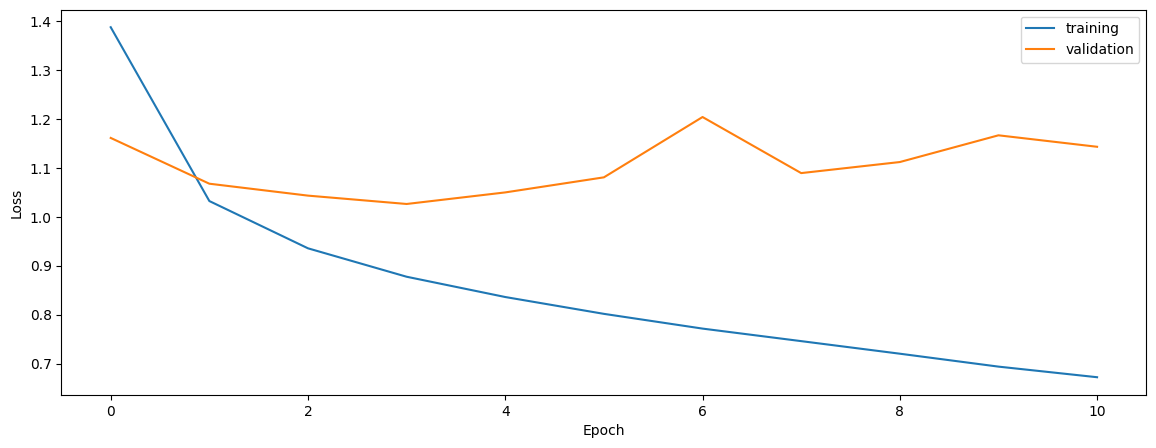

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
props1 = props
model1 = model

In [8]:
props = props.copy()
props['binarize'] = False
props['not_connected'] = False
props['collapse_max'] = True

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_1_0_0_1_1_t1t2_normalized_e_n_e_0_0_e_0_0_connectivity_data_norm_b25_roi_t1t2_native_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_0_42_n_native_08_05_06


In [9]:
gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(1068345, 1040)
(1068345, 1)
validation
(123115, 1040)
(123115, 1)
test
(152076, 1040)
(152076, 1)


In [10]:
stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_2 (InputLayer)        [(None, 1040)]            0         


 dense_5 (Dense)             (None, 1024)              1065984   


 dense_6 (Dense)             (None, 512)               524800    


 dense_7 (Dense)             (None, 256)               131328    


 dense_8 (Dense)             (None, 128)               32896     


 dense_9 (Dense)             (None, 1)                 129       


Total params: 1755137 (6.70 MB)


Trainable params: 1755137 (6.70 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [11]:
if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/107 [..............................] - ETA: 2:38 - loss: 0.2437 - STD: 1.1743e-04 - MAE: 0.4817

  3/107 [..............................] - ETA: 2s - loss: 0.2341 - STD: 3.6718e-04 - MAE: 0.4431  

  5/107 [>.............................] - ETA: 2s - loss: 0.2299 - STD: 4.2266e-04 - MAE: 0.4385

  7/107 [>.............................] - ETA: 17s - loss: 0.2272 - STD: 5.4011e-04 - MAE: 0.4433

  9/107 [=>............................] - ETA: 13s - loss: 0.2258 - STD: 6.6928e-04 - MAE: 0.4467

 11/107 [==>...........................] - ETA: 10s - loss: 0.2242 - STD: 7.8832e-04 - MAE: 0.4463

 13/107 [==>...........................] - ETA: 9s - loss: 0.2236 - STD: 9.0083e-04 - MAE: 0.4442 

 15/107 [===>..........................] - ETA: 8s - loss: 0.2227 - STD: 0.0010 - MAE: 0.4427    

 17/107 [===>..........................] - ETA: 7s - loss: 0.2220 - STD: 0.0012 - MAE: 0.4424

 19/107 [====>.........................] - ETA: 6s - loss: 0.2214 - STD: 0.0013 - MAE: 0.4429

 21/107 [====>.........................] - ETA: 5s - loss: 0.2210 - STD: 0.0015 - MAE: 0.4437

 23/107 [=====>........................] - ETA: 5s - loss: 0.2206 - STD: 0.0016 - MAE: 0.4440

 25/107 [======>.......................] - ETA: 5s - loss: 0.2203 - STD: 0.0018 - MAE: 0.4437

 27/107 [======>.......................] - ETA: 4s - loss: 0.2200 - STD: 0.0020 - MAE: 0.4432

 29/107 [=======>......................] - ETA: 4s - loss: 0.2198 - STD: 0.0023 - MAE: 0.4429

 31/107 [=======>......................] - ETA: 4s - loss: 0.2195 - STD: 0.0026 - MAE: 0.4429

 33/107 [========>.....................] - ETA: 3s - loss: 0.2193 - STD: 0.0030 - MAE: 0.4431

 35/107 [========>.....................] - ETA: 3s - loss: 0.2190 - STD: 0.0035 - MAE: 0.4432

 37/107 [=========>....................] - ETA: 3s - loss: 0.2187 - STD: 0.0041 - MAE: 0.4429

 39/107 [=========>....................] - ETA: 3s - loss: 0.2184 - STD: 0.0048 - MAE: 0.4425

 41/107 [==========>...................] - ETA: 3s - loss: 0.2181 - STD: 0.0058 - MAE: 0.4421

 43/107 [===========>..................] - ETA: 3s - loss: 0.2178 - STD: 0.0070 - MAE: 0.4420

 45/107 [===========>..................] - ETA: 2s - loss: 0.2173 - STD: 0.0086 - MAE: 0.4417

 47/107 [============>.................] - ETA: 2s - loss: 0.2169 - STD: 0.0105 - MAE: 0.4410

 49/107 [============>.................] - ETA: 2s - loss: 0.2163 - STD: 0.0130 - MAE: 0.4403

 51/107 [=============>................] - ETA: 2s - loss: 0.2157 - STD: 0.0160 - MAE: 0.4393

 53/107 [=============>................] - ETA: 2s - loss: 0.2151 - STD: 0.0195 - MAE: 0.4382

 55/107 [==============>...............] - ETA: 2s - loss: 0.2145 - STD: 0.0233 - MAE: 0.4370

 57/107 [==============>...............] - ETA: 2s - loss: 0.2138 - STD: 0.0273 - MAE: 0.4358

 59/107 [===============>..............] - ETA: 1s - loss: 0.2132 - STD: 0.0309 - MAE: 0.4345

 61/107 [================>.............] - ETA: 1s - loss: 0.2126 - STD: 0.0342 - MAE: 0.4333

 63/107 [================>.............] - ETA: 1s - loss: 0.2120 - STD: 0.0373 - MAE: 0.4323

 65/107 [=================>............] - ETA: 1s - loss: 0.2114 - STD: 0.0401 - MAE: 0.4313

 67/107 [=================>............] - ETA: 1s - loss: 0.2107 - STD: 0.0432 - MAE: 0.4302

 69/107 [==================>...........] - ETA: 1s - loss: 0.2101 - STD: 0.0465 - MAE: 0.4290

 71/107 [==================>...........] - ETA: 1s - loss: 0.2095 - STD: 0.0498 - MAE: 0.4277

 73/107 [===================>..........] - ETA: 1s - loss: 0.2089 - STD: 0.0529 - MAE: 0.4265

 75/107 [====================>.........] - ETA: 1s - loss: 0.2082 - STD: 0.0557 - MAE: 0.4254

 77/107 [====================>.........] - ETA: 1s - loss: 0.2076 - STD: 0.0585 - MAE: 0.4243

 79/107 [=====================>........] - ETA: 1s - loss: 0.2069 - STD: 0.0612 - MAE: 0.4231

 81/107 [=====================>........] - ETA: 0s - loss: 0.2062 - STD: 0.0640 - MAE: 0.4218

 83/107 [======================>.......] - ETA: 0s - loss: 0.2055 - STD: 0.0669 - MAE: 0.4205

 85/107 [======================>.......] - ETA: 0s - loss: 0.2049 - STD: 0.0697 - MAE: 0.4192

 87/107 [=======================>......] - ETA: 0s - loss: 0.2043 - STD: 0.0727 - MAE: 0.4181

 89/107 [=======================>......] - ETA: 0s - loss: 0.2037 - STD: 0.0752 - MAE: 0.4167

 91/107 [========================>.....] - ETA: 0s - loss: 0.2032 - STD: 0.0780 - MAE: 0.4157

 93/107 [=========================>....] - ETA: 0s - loss: 0.2027 - STD: 0.0802 - MAE: 0.4145

 95/107 [=========================>....] - ETA: 0s - loss: 0.2021 - STD: 0.0828 - MAE: 0.4135

 97/107 [==========================>...] - ETA: 0s - loss: 0.2015 - STD: 0.0849 - MAE: 0.4124

 99/107 [==========================>...] - ETA: 0s - loss: 0.2010 - STD: 0.0873 - MAE: 0.4114

101/107 [===========================>..] - ETA: 0s - loss: 0.2004 - STD: 0.0894 - MAE: 0.4104

103/107 [===========================>..] - ETA: 0s - loss: 0.1999 - STD: 0.0915 - MAE: 0.4094

105/107 [============================>.] - ETA: 0s - loss: 0.1994 - STD: 0.0937 - MAE: 0.4085

107/107 [==============================] - ETA: 0s - loss: 0.1989 - STD: 0.0957 - MAE: 0.4075

107/107 [==============================] - 6s 42ms/step - loss: 0.1989 - STD: 0.0957 - MAE: 0.4075 - val_loss: 0.1631 - val_STD: 0.1821 - val_MAE: 0.3488


Epoch 2/10000


  1/107 [..............................] - ETA: 7s - loss: 0.1724 - STD: 0.2117 - MAE: 0.3594

  3/107 [..............................] - ETA: 2s - loss: 0.1715 - STD: 0.2060 - MAE: 0.3554

  5/107 [>.............................] - ETA: 2s - loss: 0.1714 - STD: 0.2083 - MAE: 0.3554

  7/107 [>.............................] - ETA: 2s - loss: 0.1722 - STD: 0.2076 - MAE: 0.3558

  9/107 [=>............................] - ETA: 2s - loss: 0.1717 - STD: 0.2085 - MAE: 0.3554

 11/107 [==>...........................] - ETA: 2s - loss: 0.1715 - STD: 0.2076 - MAE: 0.3550

 13/107 [==>...........................] - ETA: 2s - loss: 0.1713 - STD: 0.2084 - MAE: 0.3550

 15/107 [===>..........................] - ETA: 2s - loss: 0.1711 - STD: 0.2079 - MAE: 0.3546

 17/107 [===>..........................] - ETA: 2s - loss: 0.1712 - STD: 0.2082 - MAE: 0.3547

 19/107 [====>.........................] - ETA: 2s - loss: 0.1709 - STD: 0.2084 - MAE: 0.3543

 21/107 [====>.........................] - ETA: 2s - loss: 0.1708 - STD: 0.2090 - MAE: 0.3542

 23/107 [=====>........................] - ETA: 2s - loss: 0.1707 - STD: 0.2090 - MAE: 0.3539

 25/107 [======>.......................] - ETA: 2s - loss: 0.1707 - STD: 0.2096 - MAE: 0.3538

 27/107 [======>.......................] - ETA: 2s - loss: 0.1707 - STD: 0.2099 - MAE: 0.3536

 29/107 [=======>......................] - ETA: 2s - loss: 0.1707 - STD: 0.2103 - MAE: 0.3536

 31/107 [=======>......................] - ETA: 1s - loss: 0.1707 - STD: 0.2104 - MAE: 0.3534

 34/107 [========>.....................] - ETA: 1s - loss: 0.1705 - STD: 0.2106 - MAE: 0.3533

 36/107 [=========>....................] - ETA: 1s - loss: 0.1705 - STD: 0.2106 - MAE: 0.3533

 38/107 [=========>....................] - ETA: 1s - loss: 0.1705 - STD: 0.2107 - MAE: 0.3532

 40/107 [==========>...................] - ETA: 1s - loss: 0.1703 - STD: 0.2108 - MAE: 0.3529

 42/107 [==========>...................] - ETA: 1s - loss: 0.1703 - STD: 0.2112 - MAE: 0.3528

 44/107 [===========>..................] - ETA: 1s - loss: 0.1703 - STD: 0.2113 - MAE: 0.3527

 46/107 [===========>..................] - ETA: 1s - loss: 0.1701 - STD: 0.2116 - MAE: 0.3525

 48/107 [============>.................] - ETA: 1s - loss: 0.1700 - STD: 0.2119 - MAE: 0.3523

 50/107 [=============>................] - ETA: 1s - loss: 0.1699 - STD: 0.2121 - MAE: 0.3521

 52/107 [=============>................] - ETA: 1s - loss: 0.1698 - STD: 0.2123 - MAE: 0.3519

 54/107 [==============>...............] - ETA: 1s - loss: 0.1697 - STD: 0.2124 - MAE: 0.3518

 56/107 [==============>...............] - ETA: 1s - loss: 0.1696 - STD: 0.2127 - MAE: 0.3516

 58/107 [===============>..............] - ETA: 1s - loss: 0.1696 - STD: 0.2128 - MAE: 0.3515

 60/107 [===============>..............] - ETA: 1s - loss: 0.1695 - STD: 0.2130 - MAE: 0.3513

 62/107 [================>.............] - ETA: 1s - loss: 0.1695 - STD: 0.2133 - MAE: 0.3513

 64/107 [================>.............] - ETA: 1s - loss: 0.1695 - STD: 0.2133 - MAE: 0.3512

 66/107 [=================>............] - ETA: 1s - loss: 0.1694 - STD: 0.2134 - MAE: 0.3512

 68/107 [==================>...........] - ETA: 1s - loss: 0.1694 - STD: 0.2134 - MAE: 0.3510

 70/107 [==================>...........] - ETA: 0s - loss: 0.1693 - STD: 0.2137 - MAE: 0.3510

 72/107 [===================>..........] - ETA: 0s - loss: 0.1693 - STD: 0.2137 - MAE: 0.3508

 74/107 [===================>..........] - ETA: 0s - loss: 0.1692 - STD: 0.2140 - MAE: 0.3506

 76/107 [====================>.........] - ETA: 0s - loss: 0.1691 - STD: 0.2142 - MAE: 0.3505

 78/107 [====================>.........] - ETA: 0s - loss: 0.1691 - STD: 0.2142 - MAE: 0.3504

 80/107 [=====================>........] - ETA: 0s - loss: 0.1690 - STD: 0.2145 - MAE: 0.3503

 82/107 [=====================>........] - ETA: 0s - loss: 0.1690 - STD: 0.2144 - MAE: 0.3502

 84/107 [======================>.......] - ETA: 0s - loss: 0.1690 - STD: 0.2146 - MAE: 0.3502

 86/107 [=======================>......] - ETA: 0s - loss: 0.1689 - STD: 0.2145 - MAE: 0.3500

 88/107 [=======================>......] - ETA: 0s - loss: 0.1689 - STD: 0.2146 - MAE: 0.3500

 90/107 [========================>.....] - ETA: 0s - loss: 0.1689 - STD: 0.2146 - MAE: 0.3500

 92/107 [========================>.....] - ETA: 0s - loss: 0.1689 - STD: 0.2146 - MAE: 0.3500

 94/107 [=========================>....] - ETA: 0s - loss: 0.1688 - STD: 0.2147 - MAE: 0.3499

 96/107 [=========================>....] - ETA: 0s - loss: 0.1687 - STD: 0.2148 - MAE: 0.3498

 98/107 [==========================>...] - ETA: 0s - loss: 0.1687 - STD: 0.2151 - MAE: 0.3496

100/107 [===========================>..] - ETA: 0s - loss: 0.1686 - STD: 0.2153 - MAE: 0.3495

102/107 [===========================>..] - ETA: 0s - loss: 0.1686 - STD: 0.2155 - MAE: 0.3494

104/107 [============================>.] - ETA: 0s - loss: 0.1686 - STD: 0.2157 - MAE: 0.3493

106/107 [============================>.] - ETA: 0s - loss: 0.1685 - STD: 0.2157 - MAE: 0.3492

107/107 [==============================] - 3s 29ms/step - loss: 0.1685 - STD: 0.2158 - MAE: 0.3492 - val_loss: 0.1589 - val_STD: 0.1843 - val_MAE: 0.3329


Epoch 3/10000


  1/107 [..............................] - ETA: 6s - loss: 0.1652 - STD: 0.2178 - MAE: 0.3415

  3/107 [..............................] - ETA: 2s - loss: 0.1643 - STD: 0.2222 - MAE: 0.3420

  5/107 [>.............................] - ETA: 2s - loss: 0.1651 - STD: 0.2205 - MAE: 0.3436

  7/107 [>.............................] - ETA: 2s - loss: 0.1658 - STD: 0.2206 - MAE: 0.3446

  9/107 [=>............................] - ETA: 2s - loss: 0.1670 - STD: 0.2200 - MAE: 0.3459

 12/107 [==>...........................] - ETA: 2s - loss: 0.1675 - STD: 0.2188 - MAE: 0.3467

 14/107 [==>...........................] - ETA: 2s - loss: 0.1675 - STD: 0.2183 - MAE: 0.3467

 16/107 [===>..........................] - ETA: 2s - loss: 0.1674 - STD: 0.2186 - MAE: 0.3468

 18/107 [====>.........................] - ETA: 2s - loss: 0.1675 - STD: 0.2179 - MAE: 0.3468

 20/107 [====>.........................] - ETA: 2s - loss: 0.1675 - STD: 0.2186 - MAE: 0.3468

 22/107 [=====>........................] - ETA: 2s - loss: 0.1676 - STD: 0.2186 - MAE: 0.3468

 24/107 [=====>........................] - ETA: 2s - loss: 0.1674 - STD: 0.2186 - MAE: 0.3464

 26/107 [======>.......................] - ETA: 2s - loss: 0.1674 - STD: 0.2191 - MAE: 0.3465

 28/107 [======>.......................] - ETA: 2s - loss: 0.1673 - STD: 0.2190 - MAE: 0.3463

 30/107 [=======>......................] - ETA: 2s - loss: 0.1674 - STD: 0.2194 - MAE: 0.3464

 32/107 [=======>......................] - ETA: 1s - loss: 0.1672 - STD: 0.2193 - MAE: 0.3461

 34/107 [========>.....................] - ETA: 1s - loss: 0.1671 - STD: 0.2196 - MAE: 0.3460

 36/107 [=========>....................] - ETA: 1s - loss: 0.1671 - STD: 0.2197 - MAE: 0.3459

 38/107 [=========>....................] - ETA: 1s - loss: 0.1669 - STD: 0.2201 - MAE: 0.3457

 40/107 [==========>...................] - ETA: 1s - loss: 0.1668 - STD: 0.2203 - MAE: 0.3455

 42/107 [==========>...................] - ETA: 1s - loss: 0.1667 - STD: 0.2208 - MAE: 0.3452

 44/107 [===========>..................] - ETA: 1s - loss: 0.1666 - STD: 0.2211 - MAE: 0.3450

 46/107 [===========>..................] - ETA: 1s - loss: 0.1667 - STD: 0.2212 - MAE: 0.3449

 48/107 [============>.................] - ETA: 1s - loss: 0.1667 - STD: 0.2217 - MAE: 0.3448

 50/107 [=============>................] - ETA: 1s - loss: 0.1667 - STD: 0.2215 - MAE: 0.3447

 52/107 [=============>................] - ETA: 1s - loss: 0.1666 - STD: 0.2217 - MAE: 0.3447

 54/107 [==============>...............] - ETA: 1s - loss: 0.1666 - STD: 0.2214 - MAE: 0.3446

 56/107 [==============>...............] - ETA: 1s - loss: 0.1666 - STD: 0.2214 - MAE: 0.3446

 58/107 [===============>..............] - ETA: 1s - loss: 0.1666 - STD: 0.2214 - MAE: 0.3447

 60/107 [===============>..............] - ETA: 1s - loss: 0.1666 - STD: 0.2212 - MAE: 0.3447

 62/107 [================>.............] - ETA: 1s - loss: 0.1665 - STD: 0.2213 - MAE: 0.3446

 64/107 [================>.............] - ETA: 1s - loss: 0.1666 - STD: 0.2212 - MAE: 0.3447

 66/107 [=================>............] - ETA: 1s - loss: 0.1665 - STD: 0.2213 - MAE: 0.3446

 68/107 [==================>...........] - ETA: 1s - loss: 0.1664 - STD: 0.2214 - MAE: 0.3445

 70/107 [==================>...........] - ETA: 0s - loss: 0.1663 - STD: 0.2216 - MAE: 0.3443

 72/107 [===================>..........] - ETA: 0s - loss: 0.1663 - STD: 0.2219 - MAE: 0.3443

 74/107 [===================>..........] - ETA: 0s - loss: 0.1663 - STD: 0.2220 - MAE: 0.3442

 76/107 [====================>.........] - ETA: 0s - loss: 0.1662 - STD: 0.2222 - MAE: 0.3440

 78/107 [====================>.........] - ETA: 0s - loss: 0.1662 - STD: 0.2224 - MAE: 0.3439

 80/107 [=====================>........] - ETA: 0s - loss: 0.1661 - STD: 0.2224 - MAE: 0.3438

 82/107 [=====================>........] - ETA: 0s - loss: 0.1660 - STD: 0.2226 - MAE: 0.3438

 84/107 [======================>.......] - ETA: 0s - loss: 0.1660 - STD: 0.2226 - MAE: 0.3437

 86/107 [=======================>......] - ETA: 0s - loss: 0.1660 - STD: 0.2227 - MAE: 0.3436

 88/107 [=======================>......] - ETA: 0s - loss: 0.1659 - STD: 0.2229 - MAE: 0.3436

 90/107 [========================>.....] - ETA: 0s - loss: 0.1659 - STD: 0.2230 - MAE: 0.3435

 92/107 [========================>.....] - ETA: 0s - loss: 0.1659 - STD: 0.2231 - MAE: 0.3435

 94/107 [=========================>....] - ETA: 0s - loss: 0.1659 - STD: 0.2232 - MAE: 0.3435

 96/107 [=========================>....] - ETA: 0s - loss: 0.1658 - STD: 0.2232 - MAE: 0.3434

 98/107 [==========================>...] - ETA: 0s - loss: 0.1658 - STD: 0.2233 - MAE: 0.3433

100/107 [===========================>..] - ETA: 0s - loss: 0.1657 - STD: 0.2234 - MAE: 0.3432

102/107 [===========================>..] - ETA: 0s - loss: 0.1657 - STD: 0.2235 - MAE: 0.3431

104/107 [============================>.] - ETA: 0s - loss: 0.1656 - STD: 0.2236 - MAE: 0.3430

106/107 [============================>.] - ETA: 0s - loss: 0.1656 - STD: 0.2237 - MAE: 0.3429

107/107 [==============================] - 3s 29ms/step - loss: 0.1656 - STD: 0.2238 - MAE: 0.3429 - val_loss: 0.1557 - val_STD: 0.1964 - val_MAE: 0.3288


Epoch 4/10000


  1/107 [..............................] - ETA: 5s - loss: 0.1642 - STD: 0.2328 - MAE: 0.3391

  3/107 [..............................] - ETA: 2s - loss: 0.1640 - STD: 0.2297 - MAE: 0.3403

  5/107 [>.............................] - ETA: 2s - loss: 0.1632 - STD: 0.2289 - MAE: 0.3389

  7/107 [>.............................] - ETA: 2s - loss: 0.1631 - STD: 0.2302 - MAE: 0.3390

  9/107 [=>............................] - ETA: 2s - loss: 0.1632 - STD: 0.2302 - MAE: 0.3385

 11/107 [==>...........................] - ETA: 2s - loss: 0.1632 - STD: 0.2299 - MAE: 0.3385

 13/107 [==>...........................] - ETA: 2s - loss: 0.1629 - STD: 0.2302 - MAE: 0.3382

 15/107 [===>..........................] - ETA: 2s - loss: 0.1630 - STD: 0.2305 - MAE: 0.3382

 17/107 [===>..........................] - ETA: 2s - loss: 0.1631 - STD: 0.2307 - MAE: 0.3383

 19/107 [====>.........................] - ETA: 2s - loss: 0.1629 - STD: 0.2308 - MAE: 0.3382

 21/107 [====>.........................] - ETA: 2s - loss: 0.1628 - STD: 0.2307 - MAE: 0.3379

 23/107 [=====>........................] - ETA: 2s - loss: 0.1634 - STD: 0.2306 - MAE: 0.3383

 25/107 [======>.......................] - ETA: 2s - loss: 0.1634 - STD: 0.2312 - MAE: 0.3383

 27/107 [======>.......................] - ETA: 2s - loss: 0.1634 - STD: 0.2309 - MAE: 0.3383

 29/107 [=======>......................] - ETA: 2s - loss: 0.1634 - STD: 0.2307 - MAE: 0.3383

 31/107 [=======>......................] - ETA: 2s - loss: 0.1635 - STD: 0.2303 - MAE: 0.3386

 33/107 [========>.....................] - ETA: 1s - loss: 0.1636 - STD: 0.2298 - MAE: 0.3389

 35/107 [========>.....................] - ETA: 1s - loss: 0.1636 - STD: 0.2294 - MAE: 0.3391

 37/107 [=========>....................] - ETA: 1s - loss: 0.1637 - STD: 0.2290 - MAE: 0.3393

 39/107 [=========>....................] - ETA: 1s - loss: 0.1637 - STD: 0.2287 - MAE: 0.3394

 41/107 [==========>...................] - ETA: 1s - loss: 0.1638 - STD: 0.2287 - MAE: 0.3394

 43/107 [===========>..................] - ETA: 1s - loss: 0.1638 - STD: 0.2290 - MAE: 0.3395

 45/107 [===========>..................] - ETA: 1s - loss: 0.1638 - STD: 0.2290 - MAE: 0.3393

 47/107 [============>.................] - ETA: 1s - loss: 0.1641 - STD: 0.2290 - MAE: 0.3394

 49/107 [============>.................] - ETA: 1s - loss: 0.1641 - STD: 0.2291 - MAE: 0.3395

 51/107 [=============>................] - ETA: 1s - loss: 0.1642 - STD: 0.2284 - MAE: 0.3394

 53/107 [=============>................] - ETA: 1s - loss: 0.1644 - STD: 0.2283 - MAE: 0.3397

 55/107 [==============>...............] - ETA: 1s - loss: 0.1645 - STD: 0.2278 - MAE: 0.3399

 57/107 [==============>...............] - ETA: 1s - loss: 0.1646 - STD: 0.2275 - MAE: 0.3402

 59/107 [===============>..............] - ETA: 1s - loss: 0.1646 - STD: 0.2273 - MAE: 0.3403

 61/107 [================>.............] - ETA: 1s - loss: 0.1645 - STD: 0.2270 - MAE: 0.3404

 63/107 [================>.............] - ETA: 1s - loss: 0.1645 - STD: 0.2269 - MAE: 0.3404

 66/107 [=================>............] - ETA: 1s - loss: 0.1644 - STD: 0.2269 - MAE: 0.3403

 68/107 [==================>...........] - ETA: 1s - loss: 0.1643 - STD: 0.2271 - MAE: 0.3401

 70/107 [==================>...........] - ETA: 0s - loss: 0.1642 - STD: 0.2274 - MAE: 0.3400

 72/107 [===================>..........] - ETA: 0s - loss: 0.1642 - STD: 0.2275 - MAE: 0.3399

 74/107 [===================>..........] - ETA: 0s - loss: 0.1642 - STD: 0.2279 - MAE: 0.3398

 76/107 [====================>.........] - ETA: 0s - loss: 0.1642 - STD: 0.2281 - MAE: 0.3396

 78/107 [====================>.........] - ETA: 0s - loss: 0.1642 - STD: 0.2284 - MAE: 0.3396

 80/107 [=====================>........] - ETA: 0s - loss: 0.1642 - STD: 0.2285 - MAE: 0.3395

 82/107 [=====================>........] - ETA: 0s - loss: 0.1641 - STD: 0.2284 - MAE: 0.3394

 84/107 [======================>.......] - ETA: 0s - loss: 0.1640 - STD: 0.2283 - MAE: 0.3394

 86/107 [=======================>......] - ETA: 0s - loss: 0.1640 - STD: 0.2282 - MAE: 0.3394

 88/107 [=======================>......] - ETA: 0s - loss: 0.1639 - STD: 0.2281 - MAE: 0.3394

 90/107 [========================>.....] - ETA: 0s - loss: 0.1639 - STD: 0.2282 - MAE: 0.3394

 92/107 [========================>.....] - ETA: 0s - loss: 0.1638 - STD: 0.2282 - MAE: 0.3393

 94/107 [=========================>....] - ETA: 0s - loss: 0.1638 - STD: 0.2283 - MAE: 0.3392

 96/107 [=========================>....] - ETA: 0s - loss: 0.1638 - STD: 0.2285 - MAE: 0.3392

 98/107 [==========================>...] - ETA: 0s - loss: 0.1638 - STD: 0.2285 - MAE: 0.3391

100/107 [===========================>..] - ETA: 0s - loss: 0.1638 - STD: 0.2287 - MAE: 0.3390

102/107 [===========================>..] - ETA: 0s - loss: 0.1637 - STD: 0.2288 - MAE: 0.3389

104/107 [============================>.] - ETA: 0s - loss: 0.1636 - STD: 0.2288 - MAE: 0.3388

106/107 [============================>.] - ETA: 0s - loss: 0.1636 - STD: 0.2288 - MAE: 0.3388

107/107 [==============================] - 3s 29ms/step - loss: 0.1636 - STD: 0.2288 - MAE: 0.3387 - val_loss: 0.1547 - val_STD: 0.1996 - val_MAE: 0.3276


Epoch 5/10000


  1/107 [..............................] - ETA: 6s - loss: 0.1602 - STD: 0.2351 - MAE: 0.3359

  3/107 [..............................] - ETA: 2s - loss: 0.1601 - STD: 0.2323 - MAE: 0.3351

  5/107 [>.............................] - ETA: 2s - loss: 0.1612 - STD: 0.2331 - MAE: 0.3357

  7/107 [>.............................] - ETA: 2s - loss: 0.1611 - STD: 0.2332 - MAE: 0.3354

  9/107 [=>............................] - ETA: 2s - loss: 0.1610 - STD: 0.2331 - MAE: 0.3354

 11/107 [==>...........................] - ETA: 2s - loss: 0.1613 - STD: 0.2333 - MAE: 0.3356

 13/107 [==>...........................] - ETA: 2s - loss: 0.1615 - STD: 0.2329 - MAE: 0.3358

 15/107 [===>..........................] - ETA: 2s - loss: 0.1616 - STD: 0.2328 - MAE: 0.3358

 17/107 [===>..........................] - ETA: 2s - loss: 0.1615 - STD: 0.2334 - MAE: 0.3355

 19/107 [====>.........................] - ETA: 2s - loss: 0.1617 - STD: 0.2334 - MAE: 0.3354

 21/107 [====>.........................] - ETA: 2s - loss: 0.1617 - STD: 0.2334 - MAE: 0.3352

 23/107 [=====>........................] - ETA: 2s - loss: 0.1617 - STD: 0.2337 - MAE: 0.3352

 25/107 [======>.......................] - ETA: 2s - loss: 0.1619 - STD: 0.2335 - MAE: 0.3356

 27/107 [======>.......................] - ETA: 2s - loss: 0.1620 - STD: 0.2328 - MAE: 0.3357

 29/107 [=======>......................] - ETA: 2s - loss: 0.1622 - STD: 0.2322 - MAE: 0.3361

 31/107 [=======>......................] - ETA: 1s - loss: 0.1622 - STD: 0.2322 - MAE: 0.3364

 33/107 [========>.....................] - ETA: 1s - loss: 0.1624 - STD: 0.2316 - MAE: 0.3365

 35/107 [========>.....................] - ETA: 1s - loss: 0.1626 - STD: 0.2316 - MAE: 0.3366

 37/107 [=========>....................] - ETA: 1s - loss: 0.1628 - STD: 0.2320 - MAE: 0.3367

 39/107 [=========>....................] - ETA: 1s - loss: 0.1628 - STD: 0.2315 - MAE: 0.3366

 41/107 [==========>...................] - ETA: 1s - loss: 0.1628 - STD: 0.2315 - MAE: 0.3367

 43/107 [===========>..................] - ETA: 1s - loss: 0.1627 - STD: 0.2312 - MAE: 0.3368

 45/107 [===========>..................] - ETA: 1s - loss: 0.1628 - STD: 0.2308 - MAE: 0.3369

 47/107 [============>.................] - ETA: 1s - loss: 0.1628 - STD: 0.2307 - MAE: 0.3371

 49/107 [============>.................] - ETA: 1s - loss: 0.1627 - STD: 0.2302 - MAE: 0.3371

 51/107 [=============>................] - ETA: 1s - loss: 0.1627 - STD: 0.2304 - MAE: 0.3371

 53/107 [=============>................] - ETA: 1s - loss: 0.1625 - STD: 0.2305 - MAE: 0.3368

 55/107 [==============>...............] - ETA: 1s - loss: 0.1624 - STD: 0.2308 - MAE: 0.3366

 57/107 [==============>...............] - ETA: 1s - loss: 0.1623 - STD: 0.2312 - MAE: 0.3364

 59/107 [===============>..............] - ETA: 1s - loss: 0.1623 - STD: 0.2316 - MAE: 0.3362

 61/107 [================>.............] - ETA: 1s - loss: 0.1622 - STD: 0.2317 - MAE: 0.3360

 63/107 [================>.............] - ETA: 1s - loss: 0.1622 - STD: 0.2319 - MAE: 0.3360

 65/107 [=================>............] - ETA: 1s - loss: 0.1621 - STD: 0.2319 - MAE: 0.3359

 67/107 [=================>............] - ETA: 1s - loss: 0.1621 - STD: 0.2320 - MAE: 0.3359

 69/107 [==================>...........] - ETA: 0s - loss: 0.1621 - STD: 0.2321 - MAE: 0.3359

 71/107 [==================>...........] - ETA: 0s - loss: 0.1621 - STD: 0.2321 - MAE: 0.3358

 73/107 [===================>..........] - ETA: 0s - loss: 0.1621 - STD: 0.2321 - MAE: 0.3359

 75/107 [====================>.........] - ETA: 0s - loss: 0.1621 - STD: 0.2321 - MAE: 0.3359

 77/107 [====================>.........] - ETA: 0s - loss: 0.1620 - STD: 0.2321 - MAE: 0.3358

 79/107 [=====================>........] - ETA: 0s - loss: 0.1621 - STD: 0.2320 - MAE: 0.3358

 81/107 [=====================>........] - ETA: 0s - loss: 0.1621 - STD: 0.2322 - MAE: 0.3358

 83/107 [======================>.......] - ETA: 0s - loss: 0.1621 - STD: 0.2321 - MAE: 0.3357

 85/107 [======================>.......] - ETA: 0s - loss: 0.1622 - STD: 0.2322 - MAE: 0.3358

 87/107 [=======================>......] - ETA: 0s - loss: 0.1623 - STD: 0.2322 - MAE: 0.3359

 89/107 [=======================>......] - ETA: 0s - loss: 0.1623 - STD: 0.2319 - MAE: 0.3359

 91/107 [========================>.....] - ETA: 0s - loss: 0.1623 - STD: 0.2319 - MAE: 0.3359

 93/107 [=========================>....] - ETA: 0s - loss: 0.1623 - STD: 0.2316 - MAE: 0.3360

 95/107 [=========================>....] - ETA: 0s - loss: 0.1622 - STD: 0.2315 - MAE: 0.3360

 97/107 [==========================>...] - ETA: 0s - loss: 0.1622 - STD: 0.2314 - MAE: 0.3361

 99/107 [==========================>...] - ETA: 0s - loss: 0.1622 - STD: 0.2313 - MAE: 0.3361

102/107 [===========================>..] - ETA: 0s - loss: 0.1622 - STD: 0.2313 - MAE: 0.3360

104/107 [============================>.] - ETA: 0s - loss: 0.1621 - STD: 0.2314 - MAE: 0.3359

106/107 [============================>.] - ETA: 0s - loss: 0.1621 - STD: 0.2314 - MAE: 0.3359

107/107 [==============================] - 3s 29ms/step - loss: 0.1621 - STD: 0.2314 - MAE: 0.3359 - val_loss: 0.1536 - val_STD: 0.2058 - val_MAE: 0.3258


Epoch 6/10000


  1/107 [..............................] - ETA: 6s - loss: 0.1607 - STD: 0.2400 - MAE: 0.3363

  3/107 [..............................] - ETA: 2s - loss: 0.1602 - STD: 0.2347 - MAE: 0.3337

  5/107 [>.............................] - ETA: 2s - loss: 0.1610 - STD: 0.2367 - MAE: 0.3340

  7/107 [>.............................] - ETA: 2s - loss: 0.1608 - STD: 0.2366 - MAE: 0.3336

  9/107 [=>............................] - ETA: 2s - loss: 0.1607 - STD: 0.2355 - MAE: 0.3334

 11/107 [==>...........................] - ETA: 2s - loss: 0.1606 - STD: 0.2360 - MAE: 0.3335

 14/107 [==>...........................] - ETA: 2s - loss: 0.1606 - STD: 0.2359 - MAE: 0.3335

 16/107 [===>..........................] - ETA: 2s - loss: 0.1606 - STD: 0.2354 - MAE: 0.3331

 18/107 [====>.........................] - ETA: 2s - loss: 0.1610 - STD: 0.2356 - MAE: 0.3334

 20/107 [====>.........................] - ETA: 2s - loss: 0.1609 - STD: 0.2358 - MAE: 0.3333

 22/107 [=====>........................] - ETA: 2s - loss: 0.1610 - STD: 0.2356 - MAE: 0.3332

 24/107 [=====>........................] - ETA: 2s - loss: 0.1609 - STD: 0.2357 - MAE: 0.3334

 26/107 [======>.......................] - ETA: 2s - loss: 0.1609 - STD: 0.2349 - MAE: 0.3337

 28/107 [======>.......................] - ETA: 2s - loss: 0.1609 - STD: 0.2342 - MAE: 0.3338

 30/107 [=======>......................] - ETA: 2s - loss: 0.1608 - STD: 0.2343 - MAE: 0.3340

 32/107 [=======>......................] - ETA: 1s - loss: 0.1607 - STD: 0.2342 - MAE: 0.3337

 34/107 [========>.....................] - ETA: 1s - loss: 0.1606 - STD: 0.2348 - MAE: 0.3336

 36/107 [=========>....................] - ETA: 1s - loss: 0.1605 - STD: 0.2351 - MAE: 0.3332

 38/107 [=========>....................] - ETA: 1s - loss: 0.1603 - STD: 0.2353 - MAE: 0.3330

 40/107 [==========>...................] - ETA: 1s - loss: 0.1604 - STD: 0.2354 - MAE: 0.3331

 42/107 [==========>...................] - ETA: 1s - loss: 0.1604 - STD: 0.2353 - MAE: 0.3330

 44/107 [===========>..................] - ETA: 1s - loss: 0.1603 - STD: 0.2354 - MAE: 0.3329

 46/107 [===========>..................] - ETA: 1s - loss: 0.1602 - STD: 0.2355 - MAE: 0.3328

 48/107 [============>.................] - ETA: 1s - loss: 0.1602 - STD: 0.2356 - MAE: 0.3327

 50/107 [=============>................] - ETA: 1s - loss: 0.1602 - STD: 0.2356 - MAE: 0.3326

 52/107 [=============>................] - ETA: 1s - loss: 0.1602 - STD: 0.2357 - MAE: 0.3327

 54/107 [==============>...............] - ETA: 1s - loss: 0.1602 - STD: 0.2357 - MAE: 0.3326

 56/107 [==============>...............] - ETA: 1s - loss: 0.1600 - STD: 0.2358 - MAE: 0.3324

 58/107 [===============>..............] - ETA: 1s - loss: 0.1600 - STD: 0.2360 - MAE: 0.3323

 60/107 [===============>..............] - ETA: 1s - loss: 0.1598 - STD: 0.2360 - MAE: 0.3321

 62/107 [================>.............] - ETA: 1s - loss: 0.1599 - STD: 0.2362 - MAE: 0.3320

 64/107 [================>.............] - ETA: 1s - loss: 0.1598 - STD: 0.2364 - MAE: 0.3319

 66/107 [=================>............] - ETA: 1s - loss: 0.1599 - STD: 0.2364 - MAE: 0.3319

 68/107 [==================>...........] - ETA: 1s - loss: 0.1599 - STD: 0.2363 - MAE: 0.3319

 70/107 [==================>...........] - ETA: 0s - loss: 0.1598 - STD: 0.2364 - MAE: 0.3319

 72/107 [===================>..........] - ETA: 0s - loss: 0.1598 - STD: 0.2364 - MAE: 0.3319

 74/107 [===================>..........] - ETA: 0s - loss: 0.1598 - STD: 0.2363 - MAE: 0.3319

 76/107 [====================>.........] - ETA: 0s - loss: 0.1598 - STD: 0.2363 - MAE: 0.3319

 78/107 [====================>.........] - ETA: 0s - loss: 0.1597 - STD: 0.2364 - MAE: 0.3318

 80/107 [=====================>........] - ETA: 0s - loss: 0.1597 - STD: 0.2364 - MAE: 0.3318

 82/107 [=====================>........] - ETA: 0s - loss: 0.1597 - STD: 0.2364 - MAE: 0.3318

 84/107 [======================>.......] - ETA: 0s - loss: 0.1597 - STD: 0.2363 - MAE: 0.3318

 86/107 [=======================>......] - ETA: 0s - loss: 0.1597 - STD: 0.2363 - MAE: 0.3318

 88/107 [=======================>......] - ETA: 0s - loss: 0.1597 - STD: 0.2364 - MAE: 0.3317

 90/107 [========================>.....] - ETA: 0s - loss: 0.1597 - STD: 0.2365 - MAE: 0.3317

 92/107 [========================>.....] - ETA: 0s - loss: 0.1597 - STD: 0.2365 - MAE: 0.3316

 94/107 [=========================>....] - ETA: 0s - loss: 0.1596 - STD: 0.2366 - MAE: 0.3316

 96/107 [=========================>....] - ETA: 0s - loss: 0.1595 - STD: 0.2367 - MAE: 0.3315

 98/107 [==========================>...] - ETA: 0s - loss: 0.1595 - STD: 0.2367 - MAE: 0.3315

100/107 [===========================>..] - ETA: 0s - loss: 0.1595 - STD: 0.2368 - MAE: 0.3314

102/107 [===========================>..] - ETA: 0s - loss: 0.1595 - STD: 0.2369 - MAE: 0.3314

104/107 [============================>.] - ETA: 0s - loss: 0.1595 - STD: 0.2369 - MAE: 0.3313

106/107 [============================>.] - ETA: 0s - loss: 0.1594 - STD: 0.2370 - MAE: 0.3312

107/107 [==============================] - 3s 29ms/step - loss: 0.1594 - STD: 0.2370 - MAE: 0.3312 - val_loss: 0.1522 - val_STD: 0.2013 - val_MAE: 0.3171


Epoch 7/10000


  1/107 [..............................] - ETA: 7s - loss: 0.1573 - STD: 0.2371 - MAE: 0.3274

  3/107 [..............................] - ETA: 2s - loss: 0.1589 - STD: 0.2402 - MAE: 0.3295

  5/107 [>.............................] - ETA: 2s - loss: 0.1589 - STD: 0.2389 - MAE: 0.3292

  7/107 [>.............................] - ETA: 2s - loss: 0.1574 - STD: 0.2395 - MAE: 0.3274

  9/107 [=>............................] - ETA: 2s - loss: 0.1578 - STD: 0.2400 - MAE: 0.3280

 11/107 [==>...........................] - ETA: 2s - loss: 0.1577 - STD: 0.2401 - MAE: 0.3281

 13/107 [==>...........................] - ETA: 2s - loss: 0.1579 - STD: 0.2394 - MAE: 0.3284

 15/107 [===>..........................] - ETA: 2s - loss: 0.1577 - STD: 0.2391 - MAE: 0.3283

 17/107 [===>..........................] - ETA: 2s - loss: 0.1576 - STD: 0.2397 - MAE: 0.3280

 19/107 [====>.........................] - ETA: 2s - loss: 0.1577 - STD: 0.2401 - MAE: 0.3280

 21/107 [====>.........................] - ETA: 2s - loss: 0.1576 - STD: 0.2403 - MAE: 0.3280

 23/107 [=====>........................] - ETA: 2s - loss: 0.1577 - STD: 0.2401 - MAE: 0.3282

 25/107 [======>.......................] - ETA: 2s - loss: 0.1576 - STD: 0.2399 - MAE: 0.3280

 27/107 [======>.......................] - ETA: 2s - loss: 0.1577 - STD: 0.2401 - MAE: 0.3280

 29/107 [=======>......................] - ETA: 2s - loss: 0.1577 - STD: 0.2404 - MAE: 0.3281

 31/107 [=======>......................] - ETA: 2s - loss: 0.1580 - STD: 0.2401 - MAE: 0.3284

 33/107 [========>.....................] - ETA: 1s - loss: 0.1581 - STD: 0.2396 - MAE: 0.3285

 35/107 [========>.....................] - ETA: 1s - loss: 0.1583 - STD: 0.2396 - MAE: 0.3286

 37/107 [=========>....................] - ETA: 1s - loss: 0.1581 - STD: 0.2398 - MAE: 0.3285

 39/107 [=========>....................] - ETA: 1s - loss: 0.1582 - STD: 0.2398 - MAE: 0.3286

 41/107 [==========>...................] - ETA: 1s - loss: 0.1581 - STD: 0.2396 - MAE: 0.3285

 43/107 [===========>..................] - ETA: 1s - loss: 0.1580 - STD: 0.2395 - MAE: 0.3284

 45/107 [===========>..................] - ETA: 1s - loss: 0.1579 - STD: 0.2394 - MAE: 0.3284

 48/107 [============>.................] - ETA: 1s - loss: 0.1579 - STD: 0.2395 - MAE: 0.3284

 50/107 [=============>................] - ETA: 1s - loss: 0.1579 - STD: 0.2398 - MAE: 0.3282

 52/107 [=============>................] - ETA: 1s - loss: 0.1578 - STD: 0.2401 - MAE: 0.3282

 54/107 [==============>...............] - ETA: 1s - loss: 0.1578 - STD: 0.2399 - MAE: 0.3282

 56/107 [==============>...............] - ETA: 1s - loss: 0.1577 - STD: 0.2398 - MAE: 0.3281

 58/107 [===============>..............] - ETA: 1s - loss: 0.1577 - STD: 0.2398 - MAE: 0.3280

 60/107 [===============>..............] - ETA: 1s - loss: 0.1576 - STD: 0.2401 - MAE: 0.3278

 62/107 [================>.............] - ETA: 1s - loss: 0.1576 - STD: 0.2403 - MAE: 0.3278

 64/107 [================>.............] - ETA: 1s - loss: 0.1577 - STD: 0.2403 - MAE: 0.3278

 66/107 [=================>............] - ETA: 1s - loss: 0.1576 - STD: 0.2404 - MAE: 0.3276

 68/107 [==================>...........] - ETA: 1s - loss: 0.1575 - STD: 0.2405 - MAE: 0.3275

 70/107 [==================>...........] - ETA: 0s - loss: 0.1574 - STD: 0.2405 - MAE: 0.3274

 72/107 [===================>..........] - ETA: 0s - loss: 0.1574 - STD: 0.2405 - MAE: 0.3274

 74/107 [===================>..........] - ETA: 0s - loss: 0.1574 - STD: 0.2405 - MAE: 0.3273

 76/107 [====================>.........] - ETA: 0s - loss: 0.1573 - STD: 0.2408 - MAE: 0.3272

 78/107 [====================>.........] - ETA: 0s - loss: 0.1573 - STD: 0.2409 - MAE: 0.3272

 80/107 [=====================>........] - ETA: 0s - loss: 0.1574 - STD: 0.2408 - MAE: 0.3271

 82/107 [=====================>........] - ETA: 0s - loss: 0.1574 - STD: 0.2407 - MAE: 0.3271

 84/107 [======================>.......] - ETA: 0s - loss: 0.1573 - STD: 0.2407 - MAE: 0.3271

 86/107 [=======================>......] - ETA: 0s - loss: 0.1573 - STD: 0.2408 - MAE: 0.3271

 88/107 [=======================>......] - ETA: 0s - loss: 0.1573 - STD: 0.2408 - MAE: 0.3271

 90/107 [========================>.....] - ETA: 0s - loss: 0.1573 - STD: 0.2407 - MAE: 0.3271

 92/107 [========================>.....] - ETA: 0s - loss: 0.1573 - STD: 0.2407 - MAE: 0.3271

 94/107 [=========================>....] - ETA: 0s - loss: 0.1573 - STD: 0.2407 - MAE: 0.3271

 96/107 [=========================>....] - ETA: 0s - loss: 0.1572 - STD: 0.2407 - MAE: 0.3270

 98/107 [==========================>...] - ETA: 0s - loss: 0.1572 - STD: 0.2408 - MAE: 0.3269

100/107 [===========================>..] - ETA: 0s - loss: 0.1572 - STD: 0.2409 - MAE: 0.3269

102/107 [===========================>..] - ETA: 0s - loss: 0.1572 - STD: 0.2410 - MAE: 0.3269

104/107 [============================>.] - ETA: 0s - loss: 0.1571 - STD: 0.2410 - MAE: 0.3268

106/107 [============================>.] - ETA: 0s - loss: 0.1571 - STD: 0.2410 - MAE: 0.3268

107/107 [==============================] - 3s 29ms/step - loss: 0.1571 - STD: 0.2410 - MAE: 0.3268 - val_loss: 0.1511 - val_STD: 0.2150 - val_MAE: 0.3198


Epoch 8/10000


  1/107 [..............................] - ETA: 5s - loss: 0.1558 - STD: 0.2470 - MAE: 0.3273

  3/107 [..............................] - ETA: 2s - loss: 0.1549 - STD: 0.2447 - MAE: 0.3243

  5/107 [>.............................] - ETA: 2s - loss: 0.1547 - STD: 0.2453 - MAE: 0.3228

  7/107 [>.............................] - ETA: 2s - loss: 0.1552 - STD: 0.2450 - MAE: 0.3220

  9/107 [=>............................] - ETA: 2s - loss: 0.1555 - STD: 0.2464 - MAE: 0.3225

 11/107 [==>...........................] - ETA: 2s - loss: 0.1556 - STD: 0.2456 - MAE: 0.3233

 13/107 [==>...........................] - ETA: 2s - loss: 0.1566 - STD: 0.2440 - MAE: 0.3246

 15/107 [===>..........................] - ETA: 2s - loss: 0.1561 - STD: 0.2430 - MAE: 0.3242

 17/107 [===>..........................] - ETA: 2s - loss: 0.1561 - STD: 0.2437 - MAE: 0.3243

 19/107 [====>.........................] - ETA: 2s - loss: 0.1561 - STD: 0.2440 - MAE: 0.3242

 21/107 [====>.........................] - ETA: 2s - loss: 0.1560 - STD: 0.2435 - MAE: 0.3244

 23/107 [=====>........................] - ETA: 2s - loss: 0.1559 - STD: 0.2432 - MAE: 0.3246

 25/107 [======>.......................] - ETA: 2s - loss: 0.1557 - STD: 0.2440 - MAE: 0.3242

 27/107 [======>.......................] - ETA: 2s - loss: 0.1556 - STD: 0.2443 - MAE: 0.3239

 29/107 [=======>......................] - ETA: 2s - loss: 0.1556 - STD: 0.2441 - MAE: 0.3239

 31/107 [=======>......................] - ETA: 1s - loss: 0.1560 - STD: 0.2434 - MAE: 0.3242

 33/107 [========>.....................] - ETA: 1s - loss: 0.1560 - STD: 0.2440 - MAE: 0.3242

 35/107 [========>.....................] - ETA: 1s - loss: 0.1558 - STD: 0.2445 - MAE: 0.3239

 37/107 [=========>....................] - ETA: 1s - loss: 0.1557 - STD: 0.2443 - MAE: 0.3236

 39/107 [=========>....................] - ETA: 1s - loss: 0.1559 - STD: 0.2438 - MAE: 0.3239

 41/107 [==========>...................] - ETA: 1s - loss: 0.1558 - STD: 0.2437 - MAE: 0.3240

 43/107 [===========>..................] - ETA: 1s - loss: 0.1556 - STD: 0.2439 - MAE: 0.3238

 45/107 [===========>..................] - ETA: 1s - loss: 0.1556 - STD: 0.2442 - MAE: 0.3236

 47/107 [============>.................] - ETA: 1s - loss: 0.1554 - STD: 0.2443 - MAE: 0.3234

 49/107 [============>.................] - ETA: 1s - loss: 0.1554 - STD: 0.2443 - MAE: 0.3233

 51/107 [=============>................] - ETA: 1s - loss: 0.1552 - STD: 0.2446 - MAE: 0.3233

 53/107 [=============>................] - ETA: 1s - loss: 0.1554 - STD: 0.2447 - MAE: 0.3234

 55/107 [==============>...............] - ETA: 1s - loss: 0.1553 - STD: 0.2447 - MAE: 0.3233

 57/107 [==============>...............] - ETA: 1s - loss: 0.1552 - STD: 0.2447 - MAE: 0.3232

 59/107 [===============>..............] - ETA: 1s - loss: 0.1552 - STD: 0.2447 - MAE: 0.3232

 61/107 [================>.............] - ETA: 1s - loss: 0.1553 - STD: 0.2446 - MAE: 0.3232

 63/107 [================>.............] - ETA: 1s - loss: 0.1554 - STD: 0.2447 - MAE: 0.3233

 65/107 [=================>............] - ETA: 1s - loss: 0.1554 - STD: 0.2449 - MAE: 0.3233

 67/107 [=================>............] - ETA: 1s - loss: 0.1555 - STD: 0.2447 - MAE: 0.3233

 69/107 [==================>...........] - ETA: 0s - loss: 0.1555 - STD: 0.2445 - MAE: 0.3233

 71/107 [==================>...........] - ETA: 0s - loss: 0.1555 - STD: 0.2446 - MAE: 0.3234

 73/107 [===================>..........] - ETA: 0s - loss: 0.1555 - STD: 0.2448 - MAE: 0.3233

 75/107 [====================>.........] - ETA: 0s - loss: 0.1555 - STD: 0.2447 - MAE: 0.3232

 77/107 [====================>.........] - ETA: 0s - loss: 0.1554 - STD: 0.2445 - MAE: 0.3232

 79/107 [=====================>........] - ETA: 0s - loss: 0.1553 - STD: 0.2446 - MAE: 0.3232

 81/107 [=====================>........] - ETA: 0s - loss: 0.1555 - STD: 0.2445 - MAE: 0.3232

 83/107 [======================>.......] - ETA: 0s - loss: 0.1555 - STD: 0.2445 - MAE: 0.3232

 85/107 [======================>.......] - ETA: 0s - loss: 0.1556 - STD: 0.2446 - MAE: 0.3233

 88/107 [=======================>......] - ETA: 0s - loss: 0.1558 - STD: 0.2442 - MAE: 0.3235

 90/107 [========================>.....] - ETA: 0s - loss: 0.1560 - STD: 0.2438 - MAE: 0.3235

 92/107 [========================>.....] - ETA: 0s - loss: 0.1561 - STD: 0.2437 - MAE: 0.3238

 94/107 [=========================>....] - ETA: 0s - loss: 0.1562 - STD: 0.2435 - MAE: 0.3239

 96/107 [=========================>....] - ETA: 0s - loss: 0.1561 - STD: 0.2433 - MAE: 0.3238

 98/107 [==========================>...] - ETA: 0s - loss: 0.1561 - STD: 0.2434 - MAE: 0.3239

100/107 [===========================>..] - ETA: 0s - loss: 0.1561 - STD: 0.2432 - MAE: 0.3238

102/107 [===========================>..] - ETA: 0s - loss: 0.1560 - STD: 0.2432 - MAE: 0.3239

104/107 [============================>.] - ETA: 0s - loss: 0.1560 - STD: 0.2431 - MAE: 0.3239

106/107 [============================>.] - ETA: 0s - loss: 0.1560 - STD: 0.2431 - MAE: 0.3239

107/107 [==============================] - 3s 29ms/step - loss: 0.1560 - STD: 0.2431 - MAE: 0.3239 - val_loss: 0.1486 - val_STD: 0.2139 - val_MAE: 0.3163


Epoch 9/10000


  1/107 [..............................] - ETA: 6s - loss: 0.1498 - STD: 0.2509 - MAE: 0.3187

  3/107 [..............................] - ETA: 2s - loss: 0.1536 - STD: 0.2473 - MAE: 0.3215

  5/107 [>.............................] - ETA: 2s - loss: 0.1532 - STD: 0.2466 - MAE: 0.3213

  7/107 [>.............................] - ETA: 2s - loss: 0.1533 - STD: 0.2465 - MAE: 0.3217

  9/107 [=>............................] - ETA: 2s - loss: 0.1531 - STD: 0.2460 - MAE: 0.3211

 11/107 [==>...........................] - ETA: 2s - loss: 0.1531 - STD: 0.2471 - MAE: 0.3209

 13/107 [==>...........................] - ETA: 2s - loss: 0.1533 - STD: 0.2472 - MAE: 0.3208

 15/107 [===>..........................] - ETA: 2s - loss: 0.1535 - STD: 0.2464 - MAE: 0.3210

 17/107 [===>..........................] - ETA: 2s - loss: 0.1537 - STD: 0.2472 - MAE: 0.3214

 19/107 [====>.........................] - ETA: 2s - loss: 0.1539 - STD: 0.2477 - MAE: 0.3209

 21/107 [====>.........................] - ETA: 2s - loss: 0.1546 - STD: 0.2475 - MAE: 0.3214

 23/107 [=====>........................] - ETA: 2s - loss: 0.1545 - STD: 0.2477 - MAE: 0.3215

 25/107 [======>.......................] - ETA: 2s - loss: 0.1546 - STD: 0.2470 - MAE: 0.3215

 28/107 [======>.......................] - ETA: 2s - loss: 0.1553 - STD: 0.2466 - MAE: 0.3218

 30/107 [=======>......................] - ETA: 2s - loss: 0.1562 - STD: 0.2464 - MAE: 0.3227

 32/107 [=======>......................] - ETA: 1s - loss: 0.1565 - STD: 0.2456 - MAE: 0.3232

 34/107 [========>.....................] - ETA: 1s - loss: 0.1566 - STD: 0.2447 - MAE: 0.3235

 36/107 [=========>....................] - ETA: 1s - loss: 0.1566 - STD: 0.2449 - MAE: 0.3236

 38/107 [=========>....................] - ETA: 1s - loss: 0.1566 - STD: 0.2443 - MAE: 0.3234

 40/107 [==========>...................] - ETA: 1s - loss: 0.1566 - STD: 0.2441 - MAE: 0.3237

 42/107 [==========>...................] - ETA: 1s - loss: 0.1566 - STD: 0.2432 - MAE: 0.3239

 44/107 [===========>..................] - ETA: 1s - loss: 0.1564 - STD: 0.2431 - MAE: 0.3240

 46/107 [===========>..................] - ETA: 1s - loss: 0.1563 - STD: 0.2429 - MAE: 0.3240

 48/107 [============>.................] - ETA: 1s - loss: 0.1561 - STD: 0.2432 - MAE: 0.3237

 50/107 [=============>................] - ETA: 1s - loss: 0.1559 - STD: 0.2431 - MAE: 0.3235

 52/107 [=============>................] - ETA: 1s - loss: 0.1558 - STD: 0.2432 - MAE: 0.3235

 54/107 [==============>...............] - ETA: 1s - loss: 0.1557 - STD: 0.2432 - MAE: 0.3234

 56/107 [==============>...............] - ETA: 1s - loss: 0.1554 - STD: 0.2434 - MAE: 0.3231

 58/107 [===============>..............] - ETA: 1s - loss: 0.1553 - STD: 0.2437 - MAE: 0.3230

 60/107 [===============>..............] - ETA: 1s - loss: 0.1551 - STD: 0.2439 - MAE: 0.3226

 62/107 [================>.............] - ETA: 1s - loss: 0.1551 - STD: 0.2442 - MAE: 0.3225

 64/107 [================>.............] - ETA: 1s - loss: 0.1550 - STD: 0.2442 - MAE: 0.3223

 66/107 [=================>............] - ETA: 1s - loss: 0.1550 - STD: 0.2443 - MAE: 0.3224

 68/107 [==================>...........] - ETA: 1s - loss: 0.1549 - STD: 0.2445 - MAE: 0.3223

 70/107 [==================>...........] - ETA: 0s - loss: 0.1548 - STD: 0.2448 - MAE: 0.3220

 72/107 [===================>..........] - ETA: 0s - loss: 0.1548 - STD: 0.2450 - MAE: 0.3220

 74/107 [===================>..........] - ETA: 0s - loss: 0.1546 - STD: 0.2452 - MAE: 0.3218

 76/107 [====================>.........] - ETA: 0s - loss: 0.1546 - STD: 0.2454 - MAE: 0.3217

 78/107 [====================>.........] - ETA: 0s - loss: 0.1545 - STD: 0.2457 - MAE: 0.3215

 80/107 [=====================>........] - ETA: 0s - loss: 0.1544 - STD: 0.2460 - MAE: 0.3213

 82/107 [=====================>........] - ETA: 0s - loss: 0.1542 - STD: 0.2462 - MAE: 0.3210

 84/107 [======================>.......] - ETA: 0s - loss: 0.1541 - STD: 0.2464 - MAE: 0.3209

 86/107 [=======================>......] - ETA: 0s - loss: 0.1541 - STD: 0.2465 - MAE: 0.3209

 88/107 [=======================>......] - ETA: 0s - loss: 0.1540 - STD: 0.2467 - MAE: 0.3207

 90/107 [========================>.....] - ETA: 0s - loss: 0.1539 - STD: 0.2469 - MAE: 0.3206

 92/107 [========================>.....] - ETA: 0s - loss: 0.1538 - STD: 0.2470 - MAE: 0.3205

 94/107 [=========================>....] - ETA: 0s - loss: 0.1538 - STD: 0.2471 - MAE: 0.3204

 96/107 [=========================>....] - ETA: 0s - loss: 0.1537 - STD: 0.2473 - MAE: 0.3202

 98/107 [==========================>...] - ETA: 0s - loss: 0.1536 - STD: 0.2475 - MAE: 0.3201

100/107 [===========================>..] - ETA: 0s - loss: 0.1536 - STD: 0.2477 - MAE: 0.3200

102/107 [===========================>..] - ETA: 0s - loss: 0.1535 - STD: 0.2477 - MAE: 0.3200

104/107 [============================>.] - ETA: 0s - loss: 0.1535 - STD: 0.2479 - MAE: 0.3199

106/107 [============================>.] - ETA: 0s - loss: 0.1534 - STD: 0.2480 - MAE: 0.3198

107/107 [==============================] - 3s 29ms/step - loss: 0.1534 - STD: 0.2481 - MAE: 0.3198 - val_loss: 0.1477 - val_STD: 0.2157 - val_MAE: 0.3068


Epoch 10/10000


  1/107 [..............................] - ETA: 5s - loss: 0.1518 - STD: 0.2484 - MAE: 0.3150

  3/107 [..............................] - ETA: 2s - loss: 0.1508 - STD: 0.2499 - MAE: 0.3157

  5/107 [>.............................] - ETA: 2s - loss: 0.1505 - STD: 0.2517 - MAE: 0.3151

  7/107 [>.............................] - ETA: 2s - loss: 0.1507 - STD: 0.2532 - MAE: 0.3151

  9/107 [=>............................] - ETA: 2s - loss: 0.1506 - STD: 0.2544 - MAE: 0.3149

 11/107 [==>...........................] - ETA: 2s - loss: 0.1504 - STD: 0.2545 - MAE: 0.3146

 13/107 [==>...........................] - ETA: 2s - loss: 0.1504 - STD: 0.2545 - MAE: 0.3147

 15/107 [===>..........................] - ETA: 2s - loss: 0.1504 - STD: 0.2540 - MAE: 0.3146

 17/107 [===>..........................] - ETA: 2s - loss: 0.1505 - STD: 0.2542 - MAE: 0.3148

 19/107 [====>.........................] - ETA: 2s - loss: 0.1505 - STD: 0.2538 - MAE: 0.3149

 21/107 [====>.........................] - ETA: 2s - loss: 0.1509 - STD: 0.2532 - MAE: 0.3153

 23/107 [=====>........................] - ETA: 2s - loss: 0.1508 - STD: 0.2534 - MAE: 0.3151

 25/107 [======>.......................] - ETA: 2s - loss: 0.1510 - STD: 0.2540 - MAE: 0.3152

 27/107 [======>.......................] - ETA: 2s - loss: 0.1513 - STD: 0.2540 - MAE: 0.3153

 29/107 [=======>......................] - ETA: 2s - loss: 0.1513 - STD: 0.2533 - MAE: 0.3154

 31/107 [=======>......................] - ETA: 1s - loss: 0.1515 - STD: 0.2532 - MAE: 0.3156

 33/107 [========>.....................] - ETA: 1s - loss: 0.1514 - STD: 0.2537 - MAE: 0.3154

 36/107 [=========>....................] - ETA: 1s - loss: 0.1511 - STD: 0.2539 - MAE: 0.3150

 38/107 [=========>....................] - ETA: 1s - loss: 0.1511 - STD: 0.2537 - MAE: 0.3152

 40/107 [==========>...................] - ETA: 1s - loss: 0.1510 - STD: 0.2536 - MAE: 0.3151

 42/107 [==========>...................] - ETA: 1s - loss: 0.1512 - STD: 0.2536 - MAE: 0.3153

 44/107 [===========>..................] - ETA: 1s - loss: 0.1512 - STD: 0.2534 - MAE: 0.3153

 46/107 [===========>..................] - ETA: 1s - loss: 0.1511 - STD: 0.2535 - MAE: 0.3153

 48/107 [============>.................] - ETA: 1s - loss: 0.1511 - STD: 0.2537 - MAE: 0.3153

 50/107 [=============>................] - ETA: 1s - loss: 0.1512 - STD: 0.2536 - MAE: 0.3153

 52/107 [=============>................] - ETA: 1s - loss: 0.1514 - STD: 0.2533 - MAE: 0.3154

 54/107 [==============>...............] - ETA: 1s - loss: 0.1513 - STD: 0.2532 - MAE: 0.3155

 56/107 [==============>...............] - ETA: 1s - loss: 0.1515 - STD: 0.2533 - MAE: 0.3155

 58/107 [===============>..............] - ETA: 1s - loss: 0.1515 - STD: 0.2534 - MAE: 0.3153

 60/107 [===============>..............] - ETA: 1s - loss: 0.1516 - STD: 0.2533 - MAE: 0.3155

 62/107 [================>.............] - ETA: 1s - loss: 0.1515 - STD: 0.2531 - MAE: 0.3156

 64/107 [================>.............] - ETA: 1s - loss: 0.1516 - STD: 0.2531 - MAE: 0.3156

 66/107 [=================>............] - ETA: 1s - loss: 0.1516 - STD: 0.2533 - MAE: 0.3155

 68/107 [==================>...........] - ETA: 1s - loss: 0.1516 - STD: 0.2533 - MAE: 0.3156

 70/107 [==================>...........] - ETA: 0s - loss: 0.1515 - STD: 0.2532 - MAE: 0.3156

 72/107 [===================>..........] - ETA: 0s - loss: 0.1514 - STD: 0.2531 - MAE: 0.3156

 74/107 [===================>..........] - ETA: 0s - loss: 0.1514 - STD: 0.2532 - MAE: 0.3155

 76/107 [====================>.........] - ETA: 0s - loss: 0.1514 - STD: 0.2534 - MAE: 0.3155

 78/107 [====================>.........] - ETA: 0s - loss: 0.1515 - STD: 0.2532 - MAE: 0.3156

 80/107 [=====================>........] - ETA: 0s - loss: 0.1516 - STD: 0.2529 - MAE: 0.3157

 82/107 [=====================>........] - ETA: 0s - loss: 0.1518 - STD: 0.2530 - MAE: 0.3159

 84/107 [======================>.......] - ETA: 0s - loss: 0.1522 - STD: 0.2525 - MAE: 0.3161

 86/107 [=======================>......] - ETA: 0s - loss: 0.1527 - STD: 0.2522 - MAE: 0.3166

 88/107 [=======================>......] - ETA: 0s - loss: 0.1529 - STD: 0.2520 - MAE: 0.3167

 90/107 [========================>.....] - ETA: 0s - loss: 0.1532 - STD: 0.2518 - MAE: 0.3170

 92/107 [========================>.....] - ETA: 0s - loss: 0.1533 - STD: 0.2513 - MAE: 0.3172

 94/107 [=========================>....] - ETA: 0s - loss: 0.1534 - STD: 0.2510 - MAE: 0.3175

 96/107 [=========================>....] - ETA: 0s - loss: 0.1534 - STD: 0.2506 - MAE: 0.3176

 98/107 [==========================>...] - ETA: 0s - loss: 0.1535 - STD: 0.2504 - MAE: 0.3178

100/107 [===========================>..] - ETA: 0s - loss: 0.1535 - STD: 0.2502 - MAE: 0.3179

102/107 [===========================>..] - ETA: 0s - loss: 0.1535 - STD: 0.2500 - MAE: 0.3180

104/107 [============================>.] - ETA: 0s - loss: 0.1535 - STD: 0.2497 - MAE: 0.3181

106/107 [============================>.] - ETA: 0s - loss: 0.1535 - STD: 0.2496 - MAE: 0.3182

107/107 [==============================] - 3s 29ms/step - loss: 0.1534 - STD: 0.2494 - MAE: 0.3182 - val_loss: 0.1465 - val_STD: 0.2160 - val_MAE: 0.3124


Epoch 11/10000


  1/107 [..............................] - ETA: 5s - loss: 0.1504 - STD: 0.2525 - MAE: 0.3175

  3/107 [..............................] - ETA: 2s - loss: 0.1512 - STD: 0.2508 - MAE: 0.3189

  5/107 [>.............................] - ETA: 2s - loss: 0.1502 - STD: 0.2493 - MAE: 0.3176

  7/107 [>.............................] - ETA: 2s - loss: 0.1502 - STD: 0.2498 - MAE: 0.3172

  9/107 [=>............................] - ETA: 2s - loss: 0.1500 - STD: 0.2498 - MAE: 0.3168

 11/107 [==>...........................] - ETA: 2s - loss: 0.1502 - STD: 0.2491 - MAE: 0.3168

 13/107 [==>...........................] - ETA: 2s - loss: 0.1505 - STD: 0.2496 - MAE: 0.3173

 15/107 [===>..........................] - ETA: 2s - loss: 0.1506 - STD: 0.2490 - MAE: 0.3167

 17/107 [===>..........................] - ETA: 2s - loss: 0.1507 - STD: 0.2501 - MAE: 0.3169

 19/107 [====>.........................] - ETA: 2s - loss: 0.1509 - STD: 0.2497 - MAE: 0.3168

 21/107 [====>.........................] - ETA: 2s - loss: 0.1510 - STD: 0.2501 - MAE: 0.3169

 23/107 [=====>........................] - ETA: 2s - loss: 0.1511 - STD: 0.2504 - MAE: 0.3167

 25/107 [======>.......................] - ETA: 2s - loss: 0.1510 - STD: 0.2507 - MAE: 0.3165

 27/107 [======>.......................] - ETA: 2s - loss: 0.1508 - STD: 0.2510 - MAE: 0.3163

 29/107 [=======>......................] - ETA: 2s - loss: 0.1508 - STD: 0.2512 - MAE: 0.3162

 31/107 [=======>......................] - ETA: 1s - loss: 0.1508 - STD: 0.2517 - MAE: 0.3160

 33/107 [========>.....................] - ETA: 1s - loss: 0.1507 - STD: 0.2521 - MAE: 0.3158

 35/107 [========>.....................] - ETA: 1s - loss: 0.1506 - STD: 0.2523 - MAE: 0.3156

 37/107 [=========>....................] - ETA: 1s - loss: 0.1506 - STD: 0.2528 - MAE: 0.3155

 39/107 [=========>....................] - ETA: 1s - loss: 0.1504 - STD: 0.2530 - MAE: 0.3151

 42/107 [==========>...................] - ETA: 1s - loss: 0.1504 - STD: 0.2533 - MAE: 0.3150

 44/107 [===========>..................] - ETA: 1s - loss: 0.1503 - STD: 0.2531 - MAE: 0.3151

 46/107 [===========>..................] - ETA: 1s - loss: 0.1503 - STD: 0.2532 - MAE: 0.3150

 48/107 [============>.................] - ETA: 1s - loss: 0.1504 - STD: 0.2534 - MAE: 0.3151

 50/107 [=============>................] - ETA: 1s - loss: 0.1503 - STD: 0.2534 - MAE: 0.3151

 52/107 [=============>................] - ETA: 1s - loss: 0.1503 - STD: 0.2536 - MAE: 0.3150

 54/107 [==============>...............] - ETA: 1s - loss: 0.1502 - STD: 0.2539 - MAE: 0.3147

 56/107 [==============>...............] - ETA: 1s - loss: 0.1502 - STD: 0.2542 - MAE: 0.3146

 58/107 [===============>..............] - ETA: 1s - loss: 0.1501 - STD: 0.2543 - MAE: 0.3145

 60/107 [===============>..............] - ETA: 1s - loss: 0.1501 - STD: 0.2542 - MAE: 0.3145

 62/107 [================>.............] - ETA: 1s - loss: 0.1500 - STD: 0.2543 - MAE: 0.3144

 64/107 [================>.............] - ETA: 1s - loss: 0.1499 - STD: 0.2544 - MAE: 0.3142

 66/107 [=================>............] - ETA: 1s - loss: 0.1499 - STD: 0.2545 - MAE: 0.3142

 68/107 [==================>...........] - ETA: 1s - loss: 0.1499 - STD: 0.2546 - MAE: 0.3142

 70/107 [==================>...........] - ETA: 0s - loss: 0.1499 - STD: 0.2548 - MAE: 0.3141

 72/107 [===================>..........] - ETA: 0s - loss: 0.1499 - STD: 0.2549 - MAE: 0.3141

 74/107 [===================>..........] - ETA: 0s - loss: 0.1499 - STD: 0.2549 - MAE: 0.3140

 76/107 [====================>.........] - ETA: 0s - loss: 0.1499 - STD: 0.2550 - MAE: 0.3140

 78/107 [====================>.........] - ETA: 0s - loss: 0.1499 - STD: 0.2552 - MAE: 0.3139

 80/107 [=====================>........] - ETA: 0s - loss: 0.1498 - STD: 0.2554 - MAE: 0.3137

 82/107 [=====================>........] - ETA: 0s - loss: 0.1497 - STD: 0.2554 - MAE: 0.3137

 84/107 [======================>.......] - ETA: 0s - loss: 0.1497 - STD: 0.2554 - MAE: 0.3137

 86/107 [=======================>......] - ETA: 0s - loss: 0.1498 - STD: 0.2555 - MAE: 0.3137

 88/107 [=======================>......] - ETA: 0s - loss: 0.1498 - STD: 0.2554 - MAE: 0.3136

 90/107 [========================>.....] - ETA: 0s - loss: 0.1498 - STD: 0.2555 - MAE: 0.3136

 92/107 [========================>.....] - ETA: 0s - loss: 0.1497 - STD: 0.2556 - MAE: 0.3135

 94/107 [=========================>....] - ETA: 0s - loss: 0.1497 - STD: 0.2555 - MAE: 0.3135

 96/107 [=========================>....] - ETA: 0s - loss: 0.1498 - STD: 0.2553 - MAE: 0.3135

 98/107 [==========================>...] - ETA: 0s - loss: 0.1499 - STD: 0.2555 - MAE: 0.3136

100/107 [===========================>..] - ETA: 0s - loss: 0.1500 - STD: 0.2552 - MAE: 0.3136

102/107 [===========================>..] - ETA: 0s - loss: 0.1505 - STD: 0.2549 - MAE: 0.3140

104/107 [============================>.] - ETA: 0s - loss: 0.1508 - STD: 0.2546 - MAE: 0.3143

106/107 [============================>.] - ETA: 0s - loss: 0.1509 - STD: 0.2545 - MAE: 0.3143

107/107 [==============================] - 3s 29ms/step - loss: 0.1509 - STD: 0.2545 - MAE: 0.3142 - val_loss: 0.1639 - val_STD: 0.2394 - val_MAE: 0.3255


Epoch 12/10000


  1/107 [..............................] - ETA: 6s - loss: 0.1626 - STD: 0.2719 - MAE: 0.3242

  3/107 [..............................] - ETA: 2s - loss: 0.1557 - STD: 0.2492 - MAE: 0.3179

  5/107 [>.............................] - ETA: 2s - loss: 0.1536 - STD: 0.2464 - MAE: 0.3205

  7/107 [>.............................] - ETA: 2s - loss: 0.1533 - STD: 0.2428 - MAE: 0.3204

  9/107 [=>............................] - ETA: 2s - loss: 0.1532 - STD: 0.2458 - MAE: 0.3201

 11/107 [==>...........................] - ETA: 2s - loss: 0.1529 - STD: 0.2453 - MAE: 0.3189

 13/107 [==>...........................] - ETA: 2s - loss: 0.1529 - STD: 0.2466 - MAE: 0.3193

 15/107 [===>..........................] - ETA: 2s - loss: 0.1527 - STD: 0.2449 - MAE: 0.3190

 17/107 [===>..........................] - ETA: 2s - loss: 0.1525 - STD: 0.2461 - MAE: 0.3189

 19/107 [====>.........................] - ETA: 2s - loss: 0.1526 - STD: 0.2458 - MAE: 0.3186

 21/107 [====>.........................] - ETA: 2s - loss: 0.1523 - STD: 0.2472 - MAE: 0.3182

 23/107 [=====>........................] - ETA: 2s - loss: 0.1522 - STD: 0.2469 - MAE: 0.3179

 25/107 [======>.......................] - ETA: 2s - loss: 0.1518 - STD: 0.2475 - MAE: 0.3177

 27/107 [======>.......................] - ETA: 2s - loss: 0.1517 - STD: 0.2472 - MAE: 0.3175

 29/107 [=======>......................] - ETA: 2s - loss: 0.1516 - STD: 0.2479 - MAE: 0.3174

 31/107 [=======>......................] - ETA: 2s - loss: 0.1516 - STD: 0.2480 - MAE: 0.3174

 33/107 [========>.....................] - ETA: 1s - loss: 0.1515 - STD: 0.2483 - MAE: 0.3173

 35/107 [========>.....................] - ETA: 1s - loss: 0.1515 - STD: 0.2487 - MAE: 0.3172

 37/107 [=========>....................] - ETA: 1s - loss: 0.1512 - STD: 0.2491 - MAE: 0.3167

 39/107 [=========>....................] - ETA: 1s - loss: 0.1511 - STD: 0.2496 - MAE: 0.3165

 41/107 [==========>...................] - ETA: 1s - loss: 0.1509 - STD: 0.2496 - MAE: 0.3162

 43/107 [===========>..................] - ETA: 1s - loss: 0.1509 - STD: 0.2500 - MAE: 0.3162

 45/107 [===========>..................] - ETA: 1s - loss: 0.1508 - STD: 0.2501 - MAE: 0.3160

 47/107 [============>.................] - ETA: 1s - loss: 0.1507 - STD: 0.2504 - MAE: 0.3158

 49/107 [============>.................] - ETA: 1s - loss: 0.1506 - STD: 0.2509 - MAE: 0.3156

 51/107 [=============>................] - ETA: 1s - loss: 0.1505 - STD: 0.2512 - MAE: 0.3154

 53/107 [=============>................] - ETA: 1s - loss: 0.1505 - STD: 0.2516 - MAE: 0.3152

 55/107 [==============>...............] - ETA: 1s - loss: 0.1503 - STD: 0.2519 - MAE: 0.3150

 57/107 [==============>...............] - ETA: 1s - loss: 0.1503 - STD: 0.2520 - MAE: 0.3149

 59/107 [===============>..............] - ETA: 1s - loss: 0.1503 - STD: 0.2521 - MAE: 0.3149

 61/107 [================>.............] - ETA: 1s - loss: 0.1502 - STD: 0.2523 - MAE: 0.3148

 63/107 [================>.............] - ETA: 1s - loss: 0.1501 - STD: 0.2526 - MAE: 0.3145

 65/107 [=================>............] - ETA: 1s - loss: 0.1501 - STD: 0.2528 - MAE: 0.3145

 67/107 [=================>............] - ETA: 1s - loss: 0.1500 - STD: 0.2529 - MAE: 0.3144

 70/107 [==================>...........] - ETA: 0s - loss: 0.1500 - STD: 0.2531 - MAE: 0.3143

 72/107 [===================>..........] - ETA: 0s - loss: 0.1499 - STD: 0.2532 - MAE: 0.3141

 74/107 [===================>..........] - ETA: 0s - loss: 0.1498 - STD: 0.2535 - MAE: 0.3140

 76/107 [====================>.........] - ETA: 0s - loss: 0.1498 - STD: 0.2535 - MAE: 0.3139

 78/107 [====================>.........] - ETA: 0s - loss: 0.1498 - STD: 0.2537 - MAE: 0.3138

 80/107 [=====================>........] - ETA: 0s - loss: 0.1497 - STD: 0.2539 - MAE: 0.3136

 82/107 [=====================>........] - ETA: 0s - loss: 0.1496 - STD: 0.2541 - MAE: 0.3135

 84/107 [======================>.......] - ETA: 0s - loss: 0.1496 - STD: 0.2542 - MAE: 0.3134

 86/107 [=======================>......] - ETA: 0s - loss: 0.1495 - STD: 0.2543 - MAE: 0.3133

 88/107 [=======================>......] - ETA: 0s - loss: 0.1494 - STD: 0.2544 - MAE: 0.3132

 90/107 [========================>.....] - ETA: 0s - loss: 0.1494 - STD: 0.2547 - MAE: 0.3131

 92/107 [========================>.....] - ETA: 0s - loss: 0.1493 - STD: 0.2548 - MAE: 0.3131

 94/107 [=========================>....] - ETA: 0s - loss: 0.1493 - STD: 0.2550 - MAE: 0.3129

 96/107 [=========================>....] - ETA: 0s - loss: 0.1492 - STD: 0.2551 - MAE: 0.3128

 98/107 [==========================>...] - ETA: 0s - loss: 0.1492 - STD: 0.2553 - MAE: 0.3127

100/107 [===========================>..] - ETA: 0s - loss: 0.1492 - STD: 0.2553 - MAE: 0.3127

102/107 [===========================>..] - ETA: 0s - loss: 0.1492 - STD: 0.2554 - MAE: 0.3128

104/107 [============================>.] - ETA: 0s - loss: 0.1492 - STD: 0.2554 - MAE: 0.3127

106/107 [============================>.] - ETA: 0s - loss: 0.1492 - STD: 0.2555 - MAE: 0.3125

107/107 [==============================] - 3s 29ms/step - loss: 0.1491 - STD: 0.2557 - MAE: 0.3125 - val_loss: 0.1448 - val_STD: 0.2298 - val_MAE: 0.3008


Epoch 13/10000


  1/107 [..............................] - ETA: 6s - loss: 0.1473 - STD: 0.2606 - MAE: 0.3092

  3/107 [..............................] - ETA: 2s - loss: 0.1461 - STD: 0.2548 - MAE: 0.3100

  5/107 [>.............................] - ETA: 2s - loss: 0.1459 - STD: 0.2556 - MAE: 0.3092

  7/107 [>.............................] - ETA: 2s - loss: 0.1466 - STD: 0.2603 - MAE: 0.3085

  9/107 [=>............................] - ETA: 2s - loss: 0.1464 - STD: 0.2613 - MAE: 0.3073

 11/107 [==>...........................] - ETA: 2s - loss: 0.1464 - STD: 0.2610 - MAE: 0.3072

 13/107 [==>...........................] - ETA: 2s - loss: 0.1463 - STD: 0.2613 - MAE: 0.3074

 15/107 [===>..........................] - ETA: 2s - loss: 0.1464 - STD: 0.2614 - MAE: 0.3072

 17/107 [===>..........................] - ETA: 2s - loss: 0.1465 - STD: 0.2617 - MAE: 0.3073

 19/107 [====>.........................] - ETA: 2s - loss: 0.1466 - STD: 0.2617 - MAE: 0.3076

 21/107 [====>.........................] - ETA: 2s - loss: 0.1468 - STD: 0.2614 - MAE: 0.3080

 23/107 [=====>........................] - ETA: 2s - loss: 0.1467 - STD: 0.2612 - MAE: 0.3077

 25/107 [======>.......................] - ETA: 2s - loss: 0.1472 - STD: 0.2614 - MAE: 0.3080

 27/107 [======>.......................] - ETA: 2s - loss: 0.1472 - STD: 0.2617 - MAE: 0.3081

 29/107 [=======>......................] - ETA: 2s - loss: 0.1475 - STD: 0.2617 - MAE: 0.3083

 31/107 [=======>......................] - ETA: 2s - loss: 0.1475 - STD: 0.2613 - MAE: 0.3082

 33/107 [========>.....................] - ETA: 1s - loss: 0.1476 - STD: 0.2612 - MAE: 0.3085

 35/107 [========>.....................] - ETA: 1s - loss: 0.1476 - STD: 0.2615 - MAE: 0.3083

 37/107 [=========>....................] - ETA: 1s - loss: 0.1475 - STD: 0.2613 - MAE: 0.3083

 39/107 [=========>....................] - ETA: 1s - loss: 0.1474 - STD: 0.2610 - MAE: 0.3083

 41/107 [==========>...................] - ETA: 1s - loss: 0.1473 - STD: 0.2610 - MAE: 0.3083

 43/107 [===========>..................] - ETA: 1s - loss: 0.1472 - STD: 0.2614 - MAE: 0.3081

 45/107 [===========>..................] - ETA: 1s - loss: 0.1472 - STD: 0.2615 - MAE: 0.3080

 47/107 [============>.................] - ETA: 1s - loss: 0.1473 - STD: 0.2615 - MAE: 0.3082

 49/107 [============>.................] - ETA: 1s - loss: 0.1473 - STD: 0.2612 - MAE: 0.3082

 51/107 [=============>................] - ETA: 1s - loss: 0.1476 - STD: 0.2610 - MAE: 0.3082

 53/107 [=============>................] - ETA: 1s - loss: 0.1479 - STD: 0.2611 - MAE: 0.3085

 55/107 [==============>...............] - ETA: 1s - loss: 0.1482 - STD: 0.2605 - MAE: 0.3086

 57/107 [==============>...............] - ETA: 1s - loss: 0.1486 - STD: 0.2604 - MAE: 0.3091

 59/107 [===============>..............] - ETA: 1s - loss: 0.1488 - STD: 0.2603 - MAE: 0.3091

 61/107 [================>.............] - ETA: 1s - loss: 0.1488 - STD: 0.2601 - MAE: 0.3092

 63/107 [================>.............] - ETA: 1s - loss: 0.1488 - STD: 0.2597 - MAE: 0.3095

 65/107 [=================>............] - ETA: 1s - loss: 0.1487 - STD: 0.2594 - MAE: 0.3095

 67/107 [=================>............] - ETA: 1s - loss: 0.1487 - STD: 0.2597 - MAE: 0.3095

 69/107 [==================>...........] - ETA: 1s - loss: 0.1487 - STD: 0.2594 - MAE: 0.3095

 71/107 [==================>...........] - ETA: 0s - loss: 0.1487 - STD: 0.2592 - MAE: 0.3098

 74/107 [===================>..........] - ETA: 0s - loss: 0.1487 - STD: 0.2592 - MAE: 0.3098

 76/107 [====================>.........] - ETA: 0s - loss: 0.1486 - STD: 0.2591 - MAE: 0.3098

 78/107 [====================>.........] - ETA: 0s - loss: 0.1486 - STD: 0.2590 - MAE: 0.3099

 80/107 [=====================>........] - ETA: 0s - loss: 0.1486 - STD: 0.2589 - MAE: 0.3100

 82/107 [=====================>........] - ETA: 0s - loss: 0.1486 - STD: 0.2588 - MAE: 0.3100

 84/107 [======================>.......] - ETA: 0s - loss: 0.1485 - STD: 0.2588 - MAE: 0.3099

 86/107 [=======================>......] - ETA: 0s - loss: 0.1485 - STD: 0.2588 - MAE: 0.3100

 88/107 [=======================>......] - ETA: 0s - loss: 0.1485 - STD: 0.2589 - MAE: 0.3100

 90/107 [========================>.....] - ETA: 0s - loss: 0.1484 - STD: 0.2588 - MAE: 0.3099

 92/107 [========================>.....] - ETA: 0s - loss: 0.1484 - STD: 0.2589 - MAE: 0.3099

 94/107 [=========================>....] - ETA: 0s - loss: 0.1484 - STD: 0.2589 - MAE: 0.3099

 96/107 [=========================>....] - ETA: 0s - loss: 0.1483 - STD: 0.2588 - MAE: 0.3098

 98/107 [==========================>...] - ETA: 0s - loss: 0.1483 - STD: 0.2590 - MAE: 0.3097

100/107 [===========================>..] - ETA: 0s - loss: 0.1483 - STD: 0.2592 - MAE: 0.3096

102/107 [===========================>..] - ETA: 0s - loss: 0.1483 - STD: 0.2591 - MAE: 0.3096

104/107 [============================>.] - ETA: 0s - loss: 0.1485 - STD: 0.2590 - MAE: 0.3098

106/107 [============================>.] - ETA: 0s - loss: 0.1486 - STD: 0.2592 - MAE: 0.3099

107/107 [==============================] - 3s 29ms/step - loss: 0.1486 - STD: 0.2591 - MAE: 0.3098 - val_loss: 0.1447 - val_STD: 0.2162 - val_MAE: 0.2955


Epoch 14/10000


  1/107 [..............................] - ETA: 5s - loss: 0.1482 - STD: 0.2525 - MAE: 0.3061

  3/107 [..............................] - ETA: 2s - loss: 0.1516 - STD: 0.2568 - MAE: 0.3134

  5/107 [>.............................] - ETA: 2s - loss: 0.1518 - STD: 0.2570 - MAE: 0.3130

  7/107 [>.............................] - ETA: 2s - loss: 0.1500 - STD: 0.2575 - MAE: 0.3106

  9/107 [=>............................] - ETA: 2s - loss: 0.1495 - STD: 0.2581 - MAE: 0.3109

 11/107 [==>...........................] - ETA: 2s - loss: 0.1494 - STD: 0.2570 - MAE: 0.3111

 13/107 [==>...........................] - ETA: 2s - loss: 0.1488 - STD: 0.2572 - MAE: 0.3110

 15/107 [===>..........................] - ETA: 2s - loss: 0.1484 - STD: 0.2575 - MAE: 0.3105

 17/107 [===>..........................] - ETA: 2s - loss: 0.1478 - STD: 0.2578 - MAE: 0.3097

 19/107 [====>.........................] - ETA: 2s - loss: 0.1476 - STD: 0.2578 - MAE: 0.3097

 21/107 [====>.........................] - ETA: 2s - loss: 0.1476 - STD: 0.2574 - MAE: 0.3098

 23/107 [=====>........................] - ETA: 2s - loss: 0.1476 - STD: 0.2573 - MAE: 0.3100

 25/107 [======>.......................] - ETA: 2s - loss: 0.1477 - STD: 0.2579 - MAE: 0.3099

 27/107 [======>.......................] - ETA: 2s - loss: 0.1477 - STD: 0.2580 - MAE: 0.3096

 29/107 [=======>......................] - ETA: 2s - loss: 0.1475 - STD: 0.2580 - MAE: 0.3096

 32/107 [=======>......................] - ETA: 1s - loss: 0.1473 - STD: 0.2583 - MAE: 0.3093

 34/107 [========>.....................] - ETA: 1s - loss: 0.1471 - STD: 0.2587 - MAE: 0.3090

 36/107 [=========>....................] - ETA: 1s - loss: 0.1470 - STD: 0.2589 - MAE: 0.3087

 38/107 [=========>....................] - ETA: 1s - loss: 0.1470 - STD: 0.2593 - MAE: 0.3087

 40/107 [==========>...................] - ETA: 1s - loss: 0.1468 - STD: 0.2594 - MAE: 0.3083

 42/107 [==========>...................] - ETA: 1s - loss: 0.1468 - STD: 0.2597 - MAE: 0.3082

 44/107 [===========>..................] - ETA: 1s - loss: 0.1468 - STD: 0.2601 - MAE: 0.3081

 46/107 [===========>..................] - ETA: 1s - loss: 0.1469 - STD: 0.2601 - MAE: 0.3083

 48/107 [============>.................] - ETA: 1s - loss: 0.1468 - STD: 0.2599 - MAE: 0.3082

 50/107 [=============>................] - ETA: 1s - loss: 0.1467 - STD: 0.2601 - MAE: 0.3080

 52/107 [=============>................] - ETA: 1s - loss: 0.1467 - STD: 0.2605 - MAE: 0.3079

 54/107 [==============>...............] - ETA: 1s - loss: 0.1466 - STD: 0.2606 - MAE: 0.3077

 56/107 [==============>...............] - ETA: 1s - loss: 0.1466 - STD: 0.2606 - MAE: 0.3077

 58/107 [===============>..............] - ETA: 1s - loss: 0.1466 - STD: 0.2607 - MAE: 0.3078

 60/107 [===============>..............] - ETA: 1s - loss: 0.1465 - STD: 0.2608 - MAE: 0.3076

 62/107 [================>.............] - ETA: 1s - loss: 0.1465 - STD: 0.2610 - MAE: 0.3075

 64/107 [================>.............] - ETA: 1s - loss: 0.1465 - STD: 0.2610 - MAE: 0.3074

 66/107 [=================>............] - ETA: 1s - loss: 0.1465 - STD: 0.2610 - MAE: 0.3074

 68/107 [==================>...........] - ETA: 1s - loss: 0.1464 - STD: 0.2612 - MAE: 0.3074

 70/107 [==================>...........] - ETA: 0s - loss: 0.1464 - STD: 0.2614 - MAE: 0.3072

 72/107 [===================>..........] - ETA: 0s - loss: 0.1463 - STD: 0.2615 - MAE: 0.3071

 74/107 [===================>..........] - ETA: 0s - loss: 0.1463 - STD: 0.2614 - MAE: 0.3072

 76/107 [====================>.........] - ETA: 0s - loss: 0.1462 - STD: 0.2616 - MAE: 0.3071

 78/107 [====================>.........] - ETA: 0s - loss: 0.1462 - STD: 0.2618 - MAE: 0.3069

 80/107 [=====================>........] - ETA: 0s - loss: 0.1462 - STD: 0.2618 - MAE: 0.3069

 82/107 [=====================>........] - ETA: 0s - loss: 0.1462 - STD: 0.2619 - MAE: 0.3069

 84/107 [======================>.......] - ETA: 0s - loss: 0.1461 - STD: 0.2620 - MAE: 0.3068

 86/107 [=======================>......] - ETA: 0s - loss: 0.1461 - STD: 0.2621 - MAE: 0.3067

 88/107 [=======================>......] - ETA: 0s - loss: 0.1461 - STD: 0.2623 - MAE: 0.3066

 90/107 [========================>.....] - ETA: 0s - loss: 0.1461 - STD: 0.2624 - MAE: 0.3067

 92/107 [========================>.....] - ETA: 0s - loss: 0.1461 - STD: 0.2624 - MAE: 0.3067

 94/107 [=========================>....] - ETA: 0s - loss: 0.1461 - STD: 0.2625 - MAE: 0.3065

 96/107 [=========================>....] - ETA: 0s - loss: 0.1461 - STD: 0.2626 - MAE: 0.3065

 98/107 [==========================>...] - ETA: 0s - loss: 0.1461 - STD: 0.2627 - MAE: 0.3065

100/107 [===========================>..] - ETA: 0s - loss: 0.1461 - STD: 0.2626 - MAE: 0.3065

102/107 [===========================>..] - ETA: 0s - loss: 0.1462 - STD: 0.2626 - MAE: 0.3065

104/107 [============================>.] - ETA: 0s - loss: 0.1462 - STD: 0.2628 - MAE: 0.3065

106/107 [============================>.] - ETA: 0s - loss: 0.1462 - STD: 0.2627 - MAE: 0.3065

107/107 [==============================] - 3s 29ms/step - loss: 0.1462 - STD: 0.2627 - MAE: 0.3065 - val_loss: 0.1446 - val_STD: 0.2220 - val_MAE: 0.2908


Epoch 15/10000


  1/107 [..............................] - ETA: 7s - loss: 0.1512 - STD: 0.2550 - MAE: 0.3047

  3/107 [..............................] - ETA: 2s - loss: 0.1487 - STD: 0.2653 - MAE: 0.3072

  5/107 [>.............................] - ETA: 2s - loss: 0.1488 - STD: 0.2615 - MAE: 0.3072

  7/107 [>.............................] - ETA: 2s - loss: 0.1496 - STD: 0.2615 - MAE: 0.3079

  9/107 [=>............................] - ETA: 2s - loss: 0.1484 - STD: 0.2649 - MAE: 0.3065

 11/107 [==>...........................] - ETA: 2s - loss: 0.1484 - STD: 0.2636 - MAE: 0.3064

 13/107 [==>...........................] - ETA: 2s - loss: 0.1494 - STD: 0.2617 - MAE: 0.3076

 15/107 [===>..........................] - ETA: 2s - loss: 0.1496 - STD: 0.2623 - MAE: 0.3082

 17/107 [===>..........................] - ETA: 2s - loss: 0.1500 - STD: 0.2615 - MAE: 0.3078

 19/107 [====>.........................] - ETA: 2s - loss: 0.1503 - STD: 0.2612 - MAE: 0.3085

 21/107 [====>.........................] - ETA: 2s - loss: 0.1504 - STD: 0.2607 - MAE: 0.3086

 23/107 [=====>........................] - ETA: 2s - loss: 0.1503 - STD: 0.2600 - MAE: 0.3087

 25/107 [======>.......................] - ETA: 2s - loss: 0.1500 - STD: 0.2602 - MAE: 0.3089

 27/107 [======>.......................] - ETA: 2s - loss: 0.1499 - STD: 0.2594 - MAE: 0.3088

 29/107 [=======>......................] - ETA: 2s - loss: 0.1497 - STD: 0.2601 - MAE: 0.3088

 31/107 [=======>......................] - ETA: 2s - loss: 0.1495 - STD: 0.2596 - MAE: 0.3087

 33/107 [========>.....................] - ETA: 1s - loss: 0.1495 - STD: 0.2596 - MAE: 0.3089

 35/107 [========>.....................] - ETA: 1s - loss: 0.1495 - STD: 0.2592 - MAE: 0.3091

 37/107 [=========>....................] - ETA: 1s - loss: 0.1495 - STD: 0.2588 - MAE: 0.3092

 39/107 [=========>....................] - ETA: 1s - loss: 0.1495 - STD: 0.2587 - MAE: 0.3093

 41/107 [==========>...................] - ETA: 1s - loss: 0.1493 - STD: 0.2587 - MAE: 0.3089

 43/107 [===========>..................] - ETA: 1s - loss: 0.1491 - STD: 0.2593 - MAE: 0.3087

 45/107 [===========>..................] - ETA: 1s - loss: 0.1490 - STD: 0.2590 - MAE: 0.3086

 47/107 [============>.................] - ETA: 1s - loss: 0.1489 - STD: 0.2588 - MAE: 0.3089

 49/107 [============>.................] - ETA: 1s - loss: 0.1488 - STD: 0.2588 - MAE: 0.3088

 51/107 [=============>................] - ETA: 1s - loss: 0.1487 - STD: 0.2589 - MAE: 0.3088

 53/107 [=============>................] - ETA: 1s - loss: 0.1486 - STD: 0.2590 - MAE: 0.3088

 55/107 [==============>...............] - ETA: 1s - loss: 0.1485 - STD: 0.2589 - MAE: 0.3087

 57/107 [==============>...............] - ETA: 1s - loss: 0.1484 - STD: 0.2590 - MAE: 0.3087

 59/107 [===============>..............] - ETA: 1s - loss: 0.1483 - STD: 0.2592 - MAE: 0.3086

 61/107 [================>.............] - ETA: 1s - loss: 0.1482 - STD: 0.2593 - MAE: 0.3084

 63/107 [================>.............] - ETA: 1s - loss: 0.1480 - STD: 0.2594 - MAE: 0.3084

 65/107 [=================>............] - ETA: 1s - loss: 0.1479 - STD: 0.2595 - MAE: 0.3083

 67/107 [=================>............] - ETA: 1s - loss: 0.1478 - STD: 0.2597 - MAE: 0.3082

 69/107 [==================>...........] - ETA: 1s - loss: 0.1477 - STD: 0.2597 - MAE: 0.3081

 72/107 [===================>..........] - ETA: 0s - loss: 0.1475 - STD: 0.2601 - MAE: 0.3078

 74/107 [===================>..........] - ETA: 0s - loss: 0.1475 - STD: 0.2603 - MAE: 0.3077

 76/107 [====================>.........] - ETA: 0s - loss: 0.1474 - STD: 0.2604 - MAE: 0.3076

 78/107 [====================>.........] - ETA: 0s - loss: 0.1473 - STD: 0.2604 - MAE: 0.3076

 80/107 [=====================>........] - ETA: 0s - loss: 0.1473 - STD: 0.2607 - MAE: 0.3075

 82/107 [=====================>........] - ETA: 0s - loss: 0.1472 - STD: 0.2609 - MAE: 0.3074

 84/107 [======================>.......] - ETA: 0s - loss: 0.1471 - STD: 0.2609 - MAE: 0.3073

 86/107 [=======================>......] - ETA: 0s - loss: 0.1470 - STD: 0.2612 - MAE: 0.3071

 88/107 [=======================>......] - ETA: 0s - loss: 0.1469 - STD: 0.2615 - MAE: 0.3069

 90/107 [========================>.....] - ETA: 0s - loss: 0.1469 - STD: 0.2615 - MAE: 0.3069

 92/107 [========================>.....] - ETA: 0s - loss: 0.1468 - STD: 0.2616 - MAE: 0.3068

 94/107 [=========================>....] - ETA: 0s - loss: 0.1467 - STD: 0.2619 - MAE: 0.3067

 96/107 [=========================>....] - ETA: 0s - loss: 0.1467 - STD: 0.2620 - MAE: 0.3065

 98/107 [==========================>...] - ETA: 0s - loss: 0.1466 - STD: 0.2621 - MAE: 0.3065

100/107 [===========================>..] - ETA: 0s - loss: 0.1466 - STD: 0.2622 - MAE: 0.3063

102/107 [===========================>..] - ETA: 0s - loss: 0.1466 - STD: 0.2623 - MAE: 0.3063

104/107 [============================>.] - ETA: 0s - loss: 0.1466 - STD: 0.2623 - MAE: 0.3063

106/107 [============================>.] - ETA: 0s - loss: 0.1465 - STD: 0.2624 - MAE: 0.3062

107/107 [==============================] - 3s 29ms/step - loss: 0.1465 - STD: 0.2625 - MAE: 0.3062 - val_loss: 0.1435 - val_STD: 0.2217 - val_MAE: 0.2913


Epoch 16/10000


  1/107 [..............................] - ETA: 6s - loss: 0.1483 - STD: 0.2564 - MAE: 0.3035

  3/107 [..............................] - ETA: 2s - loss: 0.1453 - STD: 0.2629 - MAE: 0.3050

  5/107 [>.............................] - ETA: 2s - loss: 0.1457 - STD: 0.2656 - MAE: 0.3042

  7/107 [>.............................] - ETA: 2s - loss: 0.1454 - STD: 0.2652 - MAE: 0.3035

  9/107 [=>............................] - ETA: 2s - loss: 0.1453 - STD: 0.2649 - MAE: 0.3042

 11/107 [==>...........................] - ETA: 2s - loss: 0.1447 - STD: 0.2652 - MAE: 0.3037

 13/107 [==>...........................] - ETA: 2s - loss: 0.1441 - STD: 0.2659 - MAE: 0.3025

 15/107 [===>..........................] - ETA: 2s - loss: 0.1441 - STD: 0.2664 - MAE: 0.3024

 17/107 [===>..........................] - ETA: 2s - loss: 0.1439 - STD: 0.2664 - MAE: 0.3022

 19/107 [====>.........................] - ETA: 2s - loss: 0.1439 - STD: 0.2662 - MAE: 0.3023

 21/107 [====>.........................] - ETA: 2s - loss: 0.1442 - STD: 0.2666 - MAE: 0.3026

 23/107 [=====>........................] - ETA: 2s - loss: 0.1442 - STD: 0.2667 - MAE: 0.3023

 25/107 [======>.......................] - ETA: 2s - loss: 0.1448 - STD: 0.2664 - MAE: 0.3028

 27/107 [======>.......................] - ETA: 2s - loss: 0.1449 - STD: 0.2667 - MAE: 0.3031

 29/107 [=======>......................] - ETA: 2s - loss: 0.1452 - STD: 0.2664 - MAE: 0.3031

 31/107 [=======>......................] - ETA: 2s - loss: 0.1457 - STD: 0.2661 - MAE: 0.3035

 34/107 [========>.....................] - ETA: 1s - loss: 0.1461 - STD: 0.2657 - MAE: 0.3041

 36/107 [=========>....................] - ETA: 1s - loss: 0.1463 - STD: 0.2662 - MAE: 0.3042

 38/107 [=========>....................] - ETA: 1s - loss: 0.1465 - STD: 0.2651 - MAE: 0.3043

 40/107 [==========>...................] - ETA: 1s - loss: 0.1470 - STD: 0.2648 - MAE: 0.3050

 42/107 [==========>...................] - ETA: 1s - loss: 0.1473 - STD: 0.2652 - MAE: 0.3050

 44/107 [===========>..................] - ETA: 1s - loss: 0.1472 - STD: 0.2648 - MAE: 0.3049

 46/107 [===========>..................] - ETA: 1s - loss: 0.1472 - STD: 0.2643 - MAE: 0.3053

 48/107 [============>.................] - ETA: 1s - loss: 0.1471 - STD: 0.2643 - MAE: 0.3051

 50/107 [=============>................] - ETA: 1s - loss: 0.1470 - STD: 0.2648 - MAE: 0.3050

 52/107 [=============>................] - ETA: 1s - loss: 0.1469 - STD: 0.2643 - MAE: 0.3050

 54/107 [==============>...............] - ETA: 1s - loss: 0.1470 - STD: 0.2639 - MAE: 0.3054

 56/107 [==============>...............] - ETA: 1s - loss: 0.1469 - STD: 0.2641 - MAE: 0.3052

 58/107 [===============>..............] - ETA: 1s - loss: 0.1467 - STD: 0.2642 - MAE: 0.3049

 60/107 [===============>..............] - ETA: 1s - loss: 0.1466 - STD: 0.2642 - MAE: 0.3049

 62/107 [================>.............] - ETA: 1s - loss: 0.1466 - STD: 0.2639 - MAE: 0.3051

 64/107 [================>.............] - ETA: 1s - loss: 0.1465 - STD: 0.2638 - MAE: 0.3051

 66/107 [=================>............] - ETA: 1s - loss: 0.1464 - STD: 0.2639 - MAE: 0.3050

 68/107 [==================>...........] - ETA: 1s - loss: 0.1464 - STD: 0.2639 - MAE: 0.3050

 70/107 [==================>...........] - ETA: 0s - loss: 0.1464 - STD: 0.2639 - MAE: 0.3051

 72/107 [===================>..........] - ETA: 0s - loss: 0.1463 - STD: 0.2639 - MAE: 0.3050

 74/107 [===================>..........] - ETA: 0s - loss: 0.1463 - STD: 0.2640 - MAE: 0.3050

 76/107 [====================>.........] - ETA: 0s - loss: 0.1462 - STD: 0.2639 - MAE: 0.3050

 78/107 [====================>.........] - ETA: 0s - loss: 0.1462 - STD: 0.2638 - MAE: 0.3051

 80/107 [=====================>........] - ETA: 0s - loss: 0.1461 - STD: 0.2638 - MAE: 0.3050

 82/107 [=====================>........] - ETA: 0s - loss: 0.1461 - STD: 0.2641 - MAE: 0.3050

 84/107 [======================>.......] - ETA: 0s - loss: 0.1461 - STD: 0.2640 - MAE: 0.3050

 86/107 [=======================>......] - ETA: 0s - loss: 0.1461 - STD: 0.2640 - MAE: 0.3050

 88/107 [=======================>......] - ETA: 0s - loss: 0.1460 - STD: 0.2640 - MAE: 0.3050

 90/107 [========================>.....] - ETA: 0s - loss: 0.1459 - STD: 0.2641 - MAE: 0.3049

 92/107 [========================>.....] - ETA: 0s - loss: 0.1459 - STD: 0.2641 - MAE: 0.3048

 94/107 [=========================>....] - ETA: 0s - loss: 0.1458 - STD: 0.2643 - MAE: 0.3047

 96/107 [=========================>....] - ETA: 0s - loss: 0.1457 - STD: 0.2644 - MAE: 0.3045

 98/107 [==========================>...] - ETA: 0s - loss: 0.1456 - STD: 0.2644 - MAE: 0.3045

100/107 [===========================>..] - ETA: 0s - loss: 0.1456 - STD: 0.2644 - MAE: 0.3045

102/107 [===========================>..] - ETA: 0s - loss: 0.1455 - STD: 0.2647 - MAE: 0.3043

104/107 [============================>.] - ETA: 0s - loss: 0.1455 - STD: 0.2648 - MAE: 0.3042

106/107 [============================>.] - ETA: 0s - loss: 0.1455 - STD: 0.2648 - MAE: 0.3043

107/107 [==============================] - 3s 29ms/step - loss: 0.1457 - STD: 0.2647 - MAE: 0.3043 - val_loss: 0.1418 - val_STD: 0.2394 - val_MAE: 0.2906


Epoch 17/10000


  1/107 [..............................] - ETA: 7s - loss: 0.1413 - STD: 0.2766 - MAE: 0.2940

  3/107 [..............................] - ETA: 2s - loss: 0.1540 - STD: 0.2681 - MAE: 0.3068

  5/107 [>.............................] - ETA: 2s - loss: 0.1554 - STD: 0.2642 - MAE: 0.3116

  7/107 [>.............................] - ETA: 2s - loss: 0.1535 - STD: 0.2626 - MAE: 0.3082

  9/107 [=>............................] - ETA: 2s - loss: 0.1529 - STD: 0.2669 - MAE: 0.3075

 11/107 [==>...........................] - ETA: 2s - loss: 0.1522 - STD: 0.2638 - MAE: 0.3080

 13/107 [==>...........................] - ETA: 2s - loss: 0.1518 - STD: 0.2622 - MAE: 0.3088

 15/107 [===>..........................] - ETA: 2s - loss: 0.1515 - STD: 0.2645 - MAE: 0.3078

 17/107 [===>..........................] - ETA: 2s - loss: 0.1510 - STD: 0.2648 - MAE: 0.3072

 19/107 [====>.........................] - ETA: 2s - loss: 0.1506 - STD: 0.2635 - MAE: 0.3081

 21/107 [====>.........................] - ETA: 2s - loss: 0.1500 - STD: 0.2620 - MAE: 0.3079

 23/107 [=====>........................] - ETA: 2s - loss: 0.1498 - STD: 0.2630 - MAE: 0.3078

 25/107 [======>.......................] - ETA: 2s - loss: 0.1495 - STD: 0.2627 - MAE: 0.3073

 27/107 [======>.......................] - ETA: 2s - loss: 0.1492 - STD: 0.2625 - MAE: 0.3075

 29/107 [=======>......................] - ETA: 2s - loss: 0.1489 - STD: 0.2618 - MAE: 0.3075

 31/107 [=======>......................] - ETA: 2s - loss: 0.1486 - STD: 0.2616 - MAE: 0.3075

 33/107 [========>.....................] - ETA: 1s - loss: 0.1482 - STD: 0.2616 - MAE: 0.3072

 35/107 [========>.....................] - ETA: 1s - loss: 0.1479 - STD: 0.2618 - MAE: 0.3069

 37/107 [=========>....................] - ETA: 1s - loss: 0.1476 - STD: 0.2620 - MAE: 0.3066

 39/107 [=========>....................] - ETA: 1s - loss: 0.1474 - STD: 0.2621 - MAE: 0.3065

 41/107 [==========>...................] - ETA: 1s - loss: 0.1471 - STD: 0.2623 - MAE: 0.3061

 43/107 [===========>..................] - ETA: 1s - loss: 0.1468 - STD: 0.2626 - MAE: 0.3058

 45/107 [===========>..................] - ETA: 1s - loss: 0.1467 - STD: 0.2628 - MAE: 0.3056

 47/107 [============>.................] - ETA: 1s - loss: 0.1465 - STD: 0.2629 - MAE: 0.3054

 49/107 [============>.................] - ETA: 1s - loss: 0.1464 - STD: 0.2631 - MAE: 0.3053

 51/107 [=============>................] - ETA: 1s - loss: 0.1462 - STD: 0.2632 - MAE: 0.3051

 53/107 [=============>................] - ETA: 1s - loss: 0.1461 - STD: 0.2636 - MAE: 0.3049

 55/107 [==============>...............] - ETA: 1s - loss: 0.1460 - STD: 0.2636 - MAE: 0.3047

 57/107 [==============>...............] - ETA: 1s - loss: 0.1459 - STD: 0.2639 - MAE: 0.3046

 59/107 [===============>..............] - ETA: 1s - loss: 0.1458 - STD: 0.2641 - MAE: 0.3045

 61/107 [================>.............] - ETA: 1s - loss: 0.1458 - STD: 0.2642 - MAE: 0.3043

 63/107 [================>.............] - ETA: 1s - loss: 0.1458 - STD: 0.2644 - MAE: 0.3043

 65/107 [=================>............] - ETA: 1s - loss: 0.1457 - STD: 0.2643 - MAE: 0.3043

 67/107 [=================>............] - ETA: 1s - loss: 0.1457 - STD: 0.2643 - MAE: 0.3043

 69/107 [==================>...........] - ETA: 1s - loss: 0.1457 - STD: 0.2644 - MAE: 0.3043

 71/107 [==================>...........] - ETA: 0s - loss: 0.1457 - STD: 0.2644 - MAE: 0.3041

 73/107 [===================>..........] - ETA: 0s - loss: 0.1455 - STD: 0.2646 - MAE: 0.3040

 75/107 [====================>.........] - ETA: 0s - loss: 0.1455 - STD: 0.2647 - MAE: 0.3040

 77/107 [====================>.........] - ETA: 0s - loss: 0.1455 - STD: 0.2647 - MAE: 0.3039

 79/107 [=====================>........] - ETA: 0s - loss: 0.1455 - STD: 0.2648 - MAE: 0.3039

 81/107 [=====================>........] - ETA: 0s - loss: 0.1455 - STD: 0.2649 - MAE: 0.3039

 83/107 [======================>.......] - ETA: 0s - loss: 0.1454 - STD: 0.2647 - MAE: 0.3038

 85/107 [======================>.......] - ETA: 0s - loss: 0.1455 - STD: 0.2647 - MAE: 0.3039

 87/107 [=======================>......] - ETA: 0s - loss: 0.1455 - STD: 0.2649 - MAE: 0.3038

 89/107 [=======================>......] - ETA: 0s - loss: 0.1455 - STD: 0.2649 - MAE: 0.3038

 92/107 [========================>.....] - ETA: 0s - loss: 0.1454 - STD: 0.2648 - MAE: 0.3038

 94/107 [=========================>....] - ETA: 0s - loss: 0.1453 - STD: 0.2650 - MAE: 0.3037

 96/107 [=========================>....] - ETA: 0s - loss: 0.1453 - STD: 0.2650 - MAE: 0.3036

 98/107 [==========================>...] - ETA: 0s - loss: 0.1453 - STD: 0.2650 - MAE: 0.3036

100/107 [===========================>..] - ETA: 0s - loss: 0.1452 - STD: 0.2650 - MAE: 0.3037

102/107 [===========================>..] - ETA: 0s - loss: 0.1452 - STD: 0.2650 - MAE: 0.3036

104/107 [============================>.] - ETA: 0s - loss: 0.1453 - STD: 0.2652 - MAE: 0.3036

106/107 [============================>.] - ETA: 0s - loss: 0.1454 - STD: 0.2651 - MAE: 0.3037

107/107 [==============================] - 3s 29ms/step - loss: 0.1453 - STD: 0.2651 - MAE: 0.3037 - val_loss: 0.1443 - val_STD: 0.2205 - val_MAE: 0.2890


Epoch 18/10000


  1/107 [..............................] - ETA: 5s - loss: 0.1487 - STD: 0.2640 - MAE: 0.3000

  3/107 [..............................] - ETA: 2s - loss: 0.1462 - STD: 0.2732 - MAE: 0.3015

  5/107 [>.............................] - ETA: 2s - loss: 0.1456 - STD: 0.2684 - MAE: 0.3008

  7/107 [>.............................] - ETA: 2s - loss: 0.1454 - STD: 0.2678 - MAE: 0.3019

  9/107 [=>............................] - ETA: 2s - loss: 0.1454 - STD: 0.2679 - MAE: 0.3020

 11/107 [==>...........................] - ETA: 2s - loss: 0.1448 - STD: 0.2674 - MAE: 0.3011

 13/107 [==>...........................] - ETA: 2s - loss: 0.1445 - STD: 0.2675 - MAE: 0.3015

 15/107 [===>..........................] - ETA: 2s - loss: 0.1444 - STD: 0.2669 - MAE: 0.3015

 17/107 [===>..........................] - ETA: 2s - loss: 0.1444 - STD: 0.2671 - MAE: 0.3017

 19/107 [====>.........................] - ETA: 2s - loss: 0.1444 - STD: 0.2671 - MAE: 0.3019

 21/107 [====>.........................] - ETA: 2s - loss: 0.1442 - STD: 0.2671 - MAE: 0.3017

 23/107 [=====>........................] - ETA: 2s - loss: 0.1439 - STD: 0.2674 - MAE: 0.3015

 25/107 [======>.......................] - ETA: 2s - loss: 0.1438 - STD: 0.2673 - MAE: 0.3012

 27/107 [======>.......................] - ETA: 2s - loss: 0.1439 - STD: 0.2675 - MAE: 0.3014

 29/107 [=======>......................] - ETA: 2s - loss: 0.1437 - STD: 0.2674 - MAE: 0.3013

 31/107 [=======>......................] - ETA: 2s - loss: 0.1437 - STD: 0.2671 - MAE: 0.3013

 33/107 [========>.....................] - ETA: 1s - loss: 0.1437 - STD: 0.2673 - MAE: 0.3013

 35/107 [========>.....................] - ETA: 1s - loss: 0.1438 - STD: 0.2672 - MAE: 0.3013

 37/107 [=========>....................] - ETA: 1s - loss: 0.1437 - STD: 0.2675 - MAE: 0.3012

 39/107 [=========>....................] - ETA: 1s - loss: 0.1436 - STD: 0.2674 - MAE: 0.3011

 41/107 [==========>...................] - ETA: 1s - loss: 0.1435 - STD: 0.2674 - MAE: 0.3011

 43/107 [===========>..................] - ETA: 1s - loss: 0.1435 - STD: 0.2678 - MAE: 0.3009

 45/107 [===========>..................] - ETA: 1s - loss: 0.1434 - STD: 0.2679 - MAE: 0.3007

 47/107 [============>.................] - ETA: 1s - loss: 0.1435 - STD: 0.2679 - MAE: 0.3008

 49/107 [============>.................] - ETA: 1s - loss: 0.1435 - STD: 0.2680 - MAE: 0.3010

 51/107 [=============>................] - ETA: 1s - loss: 0.1434 - STD: 0.2678 - MAE: 0.3008

 53/107 [=============>................] - ETA: 1s - loss: 0.1435 - STD: 0.2681 - MAE: 0.3008

 55/107 [==============>...............] - ETA: 1s - loss: 0.1435 - STD: 0.2682 - MAE: 0.3008

 57/107 [==============>...............] - ETA: 1s - loss: 0.1435 - STD: 0.2682 - MAE: 0.3008

 59/107 [===============>..............] - ETA: 1s - loss: 0.1434 - STD: 0.2681 - MAE: 0.3008

 61/107 [================>.............] - ETA: 1s - loss: 0.1433 - STD: 0.2683 - MAE: 0.3007

 63/107 [================>.............] - ETA: 1s - loss: 0.1433 - STD: 0.2685 - MAE: 0.3005

 65/107 [=================>............] - ETA: 1s - loss: 0.1433 - STD: 0.2686 - MAE: 0.3005

 67/107 [=================>............] - ETA: 1s - loss: 0.1432 - STD: 0.2685 - MAE: 0.3006

 69/107 [==================>...........] - ETA: 1s - loss: 0.1432 - STD: 0.2684 - MAE: 0.3005

 71/107 [==================>...........] - ETA: 0s - loss: 0.1435 - STD: 0.2684 - MAE: 0.3006

 73/107 [===================>..........] - ETA: 0s - loss: 0.1436 - STD: 0.2684 - MAE: 0.3008

 75/107 [====================>.........] - ETA: 0s - loss: 0.1437 - STD: 0.2682 - MAE: 0.3008

 77/107 [====================>.........] - ETA: 0s - loss: 0.1438 - STD: 0.2683 - MAE: 0.3009

 79/107 [=====================>........] - ETA: 0s - loss: 0.1439 - STD: 0.2681 - MAE: 0.3011

 81/107 [=====================>........] - ETA: 0s - loss: 0.1439 - STD: 0.2679 - MAE: 0.3011

 84/107 [======================>.......] - ETA: 0s - loss: 0.1439 - STD: 0.2681 - MAE: 0.3010

 86/107 [=======================>......] - ETA: 0s - loss: 0.1438 - STD: 0.2680 - MAE: 0.3010

 88/107 [=======================>......] - ETA: 0s - loss: 0.1437 - STD: 0.2681 - MAE: 0.3009

 90/107 [========================>.....] - ETA: 0s - loss: 0.1437 - STD: 0.2683 - MAE: 0.3008

 92/107 [========================>.....] - ETA: 0s - loss: 0.1437 - STD: 0.2682 - MAE: 0.3008

 94/107 [=========================>....] - ETA: 0s - loss: 0.1437 - STD: 0.2681 - MAE: 0.3009

 96/107 [=========================>....] - ETA: 0s - loss: 0.1437 - STD: 0.2683 - MAE: 0.3008

 98/107 [==========================>...] - ETA: 0s - loss: 0.1437 - STD: 0.2682 - MAE: 0.3008

100/107 [===========================>..] - ETA: 0s - loss: 0.1437 - STD: 0.2681 - MAE: 0.3009

102/107 [===========================>..] - ETA: 0s - loss: 0.1438 - STD: 0.2681 - MAE: 0.3010

104/107 [============================>.] - ETA: 0s - loss: 0.1438 - STD: 0.2680 - MAE: 0.3009

106/107 [============================>.] - ETA: 0s - loss: 0.1437 - STD: 0.2680 - MAE: 0.3010

107/107 [==============================] - 3s 29ms/step - loss: 0.1438 - STD: 0.2679 - MAE: 0.3010 - val_loss: 0.1427 - val_STD: 0.2423 - val_MAE: 0.2938


Epoch 19/10000


  1/107 [..............................] - ETA: 5s - loss: 0.1417 - STD: 0.2736 - MAE: 0.2981

  3/107 [..............................] - ETA: 2s - loss: 0.1428 - STD: 0.2731 - MAE: 0.2982

  5/107 [>.............................] - ETA: 2s - loss: 0.1427 - STD: 0.2707 - MAE: 0.2996

  7/107 [>.............................] - ETA: 2s - loss: 0.1420 - STD: 0.2691 - MAE: 0.2987

  9/107 [=>............................] - ETA: 2s - loss: 0.1421 - STD: 0.2696 - MAE: 0.2991

 11/107 [==>...........................] - ETA: 2s - loss: 0.1421 - STD: 0.2696 - MAE: 0.2990

 13/107 [==>...........................] - ETA: 2s - loss: 0.1419 - STD: 0.2693 - MAE: 0.2991

 15/107 [===>..........................] - ETA: 2s - loss: 0.1417 - STD: 0.2695 - MAE: 0.2988

 17/107 [===>..........................] - ETA: 2s - loss: 0.1417 - STD: 0.2698 - MAE: 0.2985

 19/107 [====>.........................] - ETA: 2s - loss: 0.1414 - STD: 0.2701 - MAE: 0.2984

 21/107 [====>.........................] - ETA: 2s - loss: 0.1415 - STD: 0.2699 - MAE: 0.2983

 23/107 [=====>........................] - ETA: 2s - loss: 0.1416 - STD: 0.2702 - MAE: 0.2984

 25/107 [======>.......................] - ETA: 2s - loss: 0.1414 - STD: 0.2704 - MAE: 0.2982

 27/107 [======>.......................] - ETA: 2s - loss: 0.1416 - STD: 0.2703 - MAE: 0.2984

 29/107 [=======>......................] - ETA: 2s - loss: 0.1416 - STD: 0.2706 - MAE: 0.2982

 31/107 [=======>......................] - ETA: 1s - loss: 0.1417 - STD: 0.2710 - MAE: 0.2983

 33/107 [========>.....................] - ETA: 1s - loss: 0.1416 - STD: 0.2707 - MAE: 0.2983

 35/107 [========>.....................] - ETA: 1s - loss: 0.1416 - STD: 0.2709 - MAE: 0.2982

 37/107 [=========>....................] - ETA: 1s - loss: 0.1416 - STD: 0.2713 - MAE: 0.2980

 39/107 [=========>....................] - ETA: 1s - loss: 0.1416 - STD: 0.2713 - MAE: 0.2979

 41/107 [==========>...................] - ETA: 1s - loss: 0.1416 - STD: 0.2712 - MAE: 0.2980

 43/107 [===========>..................] - ETA: 1s - loss: 0.1416 - STD: 0.2713 - MAE: 0.2980

 45/107 [===========>..................] - ETA: 1s - loss: 0.1415 - STD: 0.2713 - MAE: 0.2979

 47/107 [============>.................] - ETA: 1s - loss: 0.1414 - STD: 0.2714 - MAE: 0.2978

 49/107 [============>.................] - ETA: 1s - loss: 0.1415 - STD: 0.2716 - MAE: 0.2978

 51/107 [=============>................] - ETA: 1s - loss: 0.1415 - STD: 0.2717 - MAE: 0.2977

 53/107 [=============>................] - ETA: 1s - loss: 0.1415 - STD: 0.2717 - MAE: 0.2978

 55/107 [==============>...............] - ETA: 1s - loss: 0.1416 - STD: 0.2717 - MAE: 0.2979

 57/107 [==============>...............] - ETA: 1s - loss: 0.1416 - STD: 0.2717 - MAE: 0.2977

 59/107 [===============>..............] - ETA: 1s - loss: 0.1417 - STD: 0.2716 - MAE: 0.2979

 61/107 [================>.............] - ETA: 1s - loss: 0.1418 - STD: 0.2716 - MAE: 0.2980

 63/107 [================>.............] - ETA: 1s - loss: 0.1418 - STD: 0.2716 - MAE: 0.2979

 65/107 [=================>............] - ETA: 1s - loss: 0.1418 - STD: 0.2717 - MAE: 0.2978

 67/107 [=================>............] - ETA: 1s - loss: 0.1418 - STD: 0.2718 - MAE: 0.2979

 69/107 [==================>...........] - ETA: 0s - loss: 0.1419 - STD: 0.2717 - MAE: 0.2980

 71/107 [==================>...........] - ETA: 0s - loss: 0.1418 - STD: 0.2716 - MAE: 0.2979

 73/107 [===================>..........] - ETA: 0s - loss: 0.1418 - STD: 0.2717 - MAE: 0.2978

 76/107 [====================>.........] - ETA: 0s - loss: 0.1417 - STD: 0.2719 - MAE: 0.2977

 78/107 [====================>.........] - ETA: 0s - loss: 0.1418 - STD: 0.2717 - MAE: 0.2978

 80/107 [=====================>........] - ETA: 0s - loss: 0.1418 - STD: 0.2716 - MAE: 0.2978

 82/107 [=====================>........] - ETA: 0s - loss: 0.1418 - STD: 0.2718 - MAE: 0.2978

 84/107 [======================>.......] - ETA: 0s - loss: 0.1418 - STD: 0.2719 - MAE: 0.2978

 86/107 [=======================>......] - ETA: 0s - loss: 0.1419 - STD: 0.2718 - MAE: 0.2978

 88/107 [=======================>......] - ETA: 0s - loss: 0.1420 - STD: 0.2716 - MAE: 0.2979

 90/107 [========================>.....] - ETA: 0s - loss: 0.1420 - STD: 0.2717 - MAE: 0.2980

 92/107 [========================>.....] - ETA: 0s - loss: 0.1421 - STD: 0.2716 - MAE: 0.2979

 94/107 [=========================>....] - ETA: 0s - loss: 0.1423 - STD: 0.2716 - MAE: 0.2981

 96/107 [=========================>....] - ETA: 0s - loss: 0.1425 - STD: 0.2716 - MAE: 0.2983

 98/107 [==========================>...] - ETA: 0s - loss: 0.1425 - STD: 0.2712 - MAE: 0.2983

100/107 [===========================>..] - ETA: 0s - loss: 0.1426 - STD: 0.2712 - MAE: 0.2985

102/107 [===========================>..] - ETA: 0s - loss: 0.1427 - STD: 0.2712 - MAE: 0.2986

104/107 [============================>.] - ETA: 0s - loss: 0.1428 - STD: 0.2710 - MAE: 0.2986

106/107 [============================>.] - ETA: 0s - loss: 0.1428 - STD: 0.2709 - MAE: 0.2988

107/107 [==============================] - 3s 29ms/step - loss: 0.1428 - STD: 0.2708 - MAE: 0.2988 - val_loss: 0.1410 - val_STD: 0.2249 - val_MAE: 0.2894


Epoch 20/10000


  1/107 [..............................] - ETA: 5s - loss: 0.1419 - STD: 0.2610 - MAE: 0.2971

  3/107 [..............................] - ETA: 2s - loss: 0.1410 - STD: 0.2697 - MAE: 0.2985

  5/107 [>.............................] - ETA: 2s - loss: 0.1420 - STD: 0.2690 - MAE: 0.2984

  7/107 [>.............................] - ETA: 2s - loss: 0.1428 - STD: 0.2682 - MAE: 0.2995

  9/107 [=>............................] - ETA: 2s - loss: 0.1432 - STD: 0.2667 - MAE: 0.3009

 11/107 [==>...........................] - ETA: 2s - loss: 0.1427 - STD: 0.2665 - MAE: 0.2999

 13/107 [==>...........................] - ETA: 2s - loss: 0.1428 - STD: 0.2684 - MAE: 0.2998

 15/107 [===>..........................] - ETA: 2s - loss: 0.1431 - STD: 0.2673 - MAE: 0.3003

 17/107 [===>..........................] - ETA: 2s - loss: 0.1431 - STD: 0.2675 - MAE: 0.3004

 19/107 [====>.........................] - ETA: 2s - loss: 0.1432 - STD: 0.2683 - MAE: 0.3001

 21/107 [====>.........................] - ETA: 2s - loss: 0.1430 - STD: 0.2682 - MAE: 0.2998

 23/107 [=====>........................] - ETA: 2s - loss: 0.1428 - STD: 0.2679 - MAE: 0.3000

 26/107 [======>.......................] - ETA: 2s - loss: 0.1428 - STD: 0.2685 - MAE: 0.2998

 28/107 [======>.......................] - ETA: 2s - loss: 0.1428 - STD: 0.2686 - MAE: 0.2997

 30/107 [=======>......................] - ETA: 2s - loss: 0.1428 - STD: 0.2683 - MAE: 0.3000

 32/107 [=======>......................] - ETA: 1s - loss: 0.1429 - STD: 0.2684 - MAE: 0.3001

 34/107 [========>.....................] - ETA: 1s - loss: 0.1427 - STD: 0.2686 - MAE: 0.2998

 36/107 [=========>....................] - ETA: 1s - loss: 0.1426 - STD: 0.2687 - MAE: 0.2996

 38/107 [=========>....................] - ETA: 1s - loss: 0.1425 - STD: 0.2689 - MAE: 0.2996

 40/107 [==========>...................] - ETA: 1s - loss: 0.1426 - STD: 0.2687 - MAE: 0.2995

 42/107 [==========>...................] - ETA: 1s - loss: 0.1427 - STD: 0.2688 - MAE: 0.2996

 44/107 [===========>..................] - ETA: 1s - loss: 0.1428 - STD: 0.2687 - MAE: 0.2998

 46/107 [===========>..................] - ETA: 1s - loss: 0.1428 - STD: 0.2688 - MAE: 0.2996

 48/107 [============>.................] - ETA: 1s - loss: 0.1426 - STD: 0.2693 - MAE: 0.2993

 50/107 [=============>................] - ETA: 1s - loss: 0.1427 - STD: 0.2691 - MAE: 0.2994

 52/107 [=============>................] - ETA: 1s - loss: 0.1427 - STD: 0.2691 - MAE: 0.2995

 54/107 [==============>...............] - ETA: 1s - loss: 0.1427 - STD: 0.2692 - MAE: 0.2994

 56/107 [==============>...............] - ETA: 1s - loss: 0.1426 - STD: 0.2692 - MAE: 0.2993

 58/107 [===============>..............] - ETA: 1s - loss: 0.1426 - STD: 0.2692 - MAE: 0.2993

 60/107 [===============>..............] - ETA: 1s - loss: 0.1426 - STD: 0.2694 - MAE: 0.2993

 62/107 [================>.............] - ETA: 1s - loss: 0.1425 - STD: 0.2694 - MAE: 0.2992

 64/107 [================>.............] - ETA: 1s - loss: 0.1423 - STD: 0.2695 - MAE: 0.2990

 66/107 [=================>............] - ETA: 1s - loss: 0.1424 - STD: 0.2697 - MAE: 0.2990

 68/107 [==================>...........] - ETA: 1s - loss: 0.1423 - STD: 0.2697 - MAE: 0.2989

 70/107 [==================>...........] - ETA: 0s - loss: 0.1423 - STD: 0.2695 - MAE: 0.2990

 72/107 [===================>..........] - ETA: 0s - loss: 0.1423 - STD: 0.2697 - MAE: 0.2989

 74/107 [===================>..........] - ETA: 0s - loss: 0.1423 - STD: 0.2698 - MAE: 0.2988

 76/107 [====================>.........] - ETA: 0s - loss: 0.1422 - STD: 0.2699 - MAE: 0.2987

 78/107 [====================>.........] - ETA: 0s - loss: 0.1423 - STD: 0.2698 - MAE: 0.2988

 80/107 [=====================>........] - ETA: 0s - loss: 0.1422 - STD: 0.2699 - MAE: 0.2987

 82/107 [=====================>........] - ETA: 0s - loss: 0.1423 - STD: 0.2699 - MAE: 0.2987

 84/107 [======================>.......] - ETA: 0s - loss: 0.1424 - STD: 0.2699 - MAE: 0.2988

 86/107 [=======================>......] - ETA: 0s - loss: 0.1424 - STD: 0.2698 - MAE: 0.2989

 88/107 [=======================>......] - ETA: 0s - loss: 0.1424 - STD: 0.2699 - MAE: 0.2988

 90/107 [========================>.....] - ETA: 0s - loss: 0.1423 - STD: 0.2702 - MAE: 0.2987

 92/107 [========================>.....] - ETA: 0s - loss: 0.1423 - STD: 0.2701 - MAE: 0.2987

 94/107 [=========================>....] - ETA: 0s - loss: 0.1423 - STD: 0.2701 - MAE: 0.2987

 96/107 [=========================>....] - ETA: 0s - loss: 0.1422 - STD: 0.2702 - MAE: 0.2986

 98/107 [==========================>...] - ETA: 0s - loss: 0.1422 - STD: 0.2701 - MAE: 0.2985

100/107 [===========================>..] - ETA: 0s - loss: 0.1421 - STD: 0.2702 - MAE: 0.2984

102/107 [===========================>..] - ETA: 0s - loss: 0.1421 - STD: 0.2704 - MAE: 0.2983

104/107 [============================>.] - ETA: 0s - loss: 0.1421 - STD: 0.2703 - MAE: 0.2984

106/107 [============================>.] - ETA: 0s - loss: 0.1421 - STD: 0.2703 - MAE: 0.2984

107/107 [==============================] - 3s 29ms/step - loss: 0.1420 - STD: 0.2704 - MAE: 0.2983 - val_loss: 0.1509 - val_STD: 0.2567 - val_MAE: 0.3014


Epoch 21/10000


  1/107 [..............................] - ETA: 5s - loss: 0.1457 - STD: 0.2870 - MAE: 0.2988

  3/107 [..............................] - ETA: 2s - loss: 0.1430 - STD: 0.2755 - MAE: 0.2962

  5/107 [>.............................] - ETA: 2s - loss: 0.1431 - STD: 0.2721 - MAE: 0.2986

  7/107 [>.............................] - ETA: 2s - loss: 0.1430 - STD: 0.2742 - MAE: 0.2982

  9/107 [=>............................] - ETA: 2s - loss: 0.1423 - STD: 0.2741 - MAE: 0.2968

 11/107 [==>...........................] - ETA: 2s - loss: 0.1433 - STD: 0.2728 - MAE: 0.2982

 13/107 [==>...........................] - ETA: 2s - loss: 0.1433 - STD: 0.2722 - MAE: 0.2991

 15/107 [===>..........................] - ETA: 2s - loss: 0.1436 - STD: 0.2719 - MAE: 0.2987

 17/107 [===>..........................] - ETA: 2s - loss: 0.1439 - STD: 0.2719 - MAE: 0.2990

 19/107 [====>.........................] - ETA: 2s - loss: 0.1441 - STD: 0.2717 - MAE: 0.2995

 21/107 [====>.........................] - ETA: 2s - loss: 0.1440 - STD: 0.2710 - MAE: 0.2993

 23/107 [=====>........................] - ETA: 2s - loss: 0.1440 - STD: 0.2711 - MAE: 0.2995

 25/107 [======>.......................] - ETA: 2s - loss: 0.1440 - STD: 0.2709 - MAE: 0.2996

 27/107 [======>.......................] - ETA: 2s - loss: 0.1439 - STD: 0.2707 - MAE: 0.2994

 29/107 [=======>......................] - ETA: 2s - loss: 0.1437 - STD: 0.2709 - MAE: 0.2993

 31/107 [=======>......................] - ETA: 2s - loss: 0.1436 - STD: 0.2706 - MAE: 0.2992

 33/107 [========>.....................] - ETA: 1s - loss: 0.1434 - STD: 0.2705 - MAE: 0.2992

 35/107 [========>.....................] - ETA: 1s - loss: 0.1433 - STD: 0.2708 - MAE: 0.2990

 37/107 [=========>....................] - ETA: 1s - loss: 0.1431 - STD: 0.2706 - MAE: 0.2987

 40/107 [==========>...................] - ETA: 1s - loss: 0.1429 - STD: 0.2705 - MAE: 0.2986

 42/107 [==========>...................] - ETA: 1s - loss: 0.1430 - STD: 0.2706 - MAE: 0.2988

 44/107 [===========>..................] - ETA: 1s - loss: 0.1430 - STD: 0.2705 - MAE: 0.2985

 46/107 [===========>..................] - ETA: 1s - loss: 0.1429 - STD: 0.2707 - MAE: 0.2986

 48/107 [============>.................] - ETA: 1s - loss: 0.1431 - STD: 0.2705 - MAE: 0.2987

 50/107 [=============>................] - ETA: 1s - loss: 0.1433 - STD: 0.2704 - MAE: 0.2989

 52/107 [=============>................] - ETA: 1s - loss: 0.1434 - STD: 0.2704 - MAE: 0.2989

 54/107 [==============>...............] - ETA: 1s - loss: 0.1434 - STD: 0.2701 - MAE: 0.2989

 56/107 [==============>...............] - ETA: 1s - loss: 0.1434 - STD: 0.2703 - MAE: 0.2989

 58/107 [===============>..............] - ETA: 1s - loss: 0.1434 - STD: 0.2703 - MAE: 0.2988

 60/107 [===============>..............] - ETA: 1s - loss: 0.1434 - STD: 0.2702 - MAE: 0.2989

 62/107 [================>.............] - ETA: 1s - loss: 0.1434 - STD: 0.2702 - MAE: 0.2990

 64/107 [================>.............] - ETA: 1s - loss: 0.1434 - STD: 0.2700 - MAE: 0.2990

 66/107 [=================>............] - ETA: 1s - loss: 0.1433 - STD: 0.2701 - MAE: 0.2990

 68/107 [==================>...........] - ETA: 1s - loss: 0.1433 - STD: 0.2699 - MAE: 0.2990

 70/107 [==================>...........] - ETA: 0s - loss: 0.1433 - STD: 0.2699 - MAE: 0.2991

 72/107 [===================>..........] - ETA: 0s - loss: 0.1432 - STD: 0.2701 - MAE: 0.2990

 74/107 [===================>..........] - ETA: 0s - loss: 0.1432 - STD: 0.2698 - MAE: 0.2990

 76/107 [====================>.........] - ETA: 0s - loss: 0.1431 - STD: 0.2698 - MAE: 0.2990

 78/107 [====================>.........] - ETA: 0s - loss: 0.1431 - STD: 0.2700 - MAE: 0.2989

 80/107 [=====================>........] - ETA: 0s - loss: 0.1430 - STD: 0.2701 - MAE: 0.2988

 82/107 [=====================>........] - ETA: 0s - loss: 0.1429 - STD: 0.2699 - MAE: 0.2989

 84/107 [======================>.......] - ETA: 0s - loss: 0.1428 - STD: 0.2700 - MAE: 0.2987

 86/107 [=======================>......] - ETA: 0s - loss: 0.1427 - STD: 0.2702 - MAE: 0.2986

 88/107 [=======================>......] - ETA: 0s - loss: 0.1426 - STD: 0.2702 - MAE: 0.2984

 90/107 [========================>.....] - ETA: 0s - loss: 0.1425 - STD: 0.2704 - MAE: 0.2983

 92/107 [========================>.....] - ETA: 0s - loss: 0.1424 - STD: 0.2705 - MAE: 0.2982

 94/107 [=========================>....] - ETA: 0s - loss: 0.1424 - STD: 0.2705 - MAE: 0.2982

 96/107 [=========================>....] - ETA: 0s - loss: 0.1423 - STD: 0.2705 - MAE: 0.2981

 98/107 [==========================>...] - ETA: 0s - loss: 0.1423 - STD: 0.2708 - MAE: 0.2980

100/107 [===========================>..] - ETA: 0s - loss: 0.1423 - STD: 0.2708 - MAE: 0.2980

102/107 [===========================>..] - ETA: 0s - loss: 0.1422 - STD: 0.2709 - MAE: 0.2979

104/107 [============================>.] - ETA: 0s - loss: 0.1421 - STD: 0.2712 - MAE: 0.2977

106/107 [============================>.] - ETA: 0s - loss: 0.1421 - STD: 0.2713 - MAE: 0.2976

107/107 [==============================] - 3s 29ms/step - loss: 0.1420 - STD: 0.2714 - MAE: 0.2976 - val_loss: 0.1403 - val_STD: 0.2340 - val_MAE: 0.2884


Epoch 22/10000


  1/107 [..............................] - ETA: 7s - loss: 0.1430 - STD: 0.2705 - MAE: 0.2967

  3/107 [..............................] - ETA: 2s - loss: 0.1410 - STD: 0.2741 - MAE: 0.2965

  5/107 [>.............................] - ETA: 2s - loss: 0.1403 - STD: 0.2750 - MAE: 0.2946

  7/107 [>.............................] - ETA: 2s - loss: 0.1403 - STD: 0.2750 - MAE: 0.2950

  9/107 [=>............................] - ETA: 2s - loss: 0.1402 - STD: 0.2759 - MAE: 0.2948

 11/107 [==>...........................] - ETA: 2s - loss: 0.1398 - STD: 0.2761 - MAE: 0.2941

 13/107 [==>...........................] - ETA: 2s - loss: 0.1397 - STD: 0.2759 - MAE: 0.2941

 15/107 [===>..........................] - ETA: 2s - loss: 0.1401 - STD: 0.2754 - MAE: 0.2946

 17/107 [===>..........................] - ETA: 2s - loss: 0.1400 - STD: 0.2758 - MAE: 0.2945

 19/107 [====>.........................] - ETA: 2s - loss: 0.1400 - STD: 0.2762 - MAE: 0.2942

 21/107 [====>.........................] - ETA: 2s - loss: 0.1402 - STD: 0.2759 - MAE: 0.2943

 23/107 [=====>........................] - ETA: 2s - loss: 0.1399 - STD: 0.2758 - MAE: 0.2942

 25/107 [======>.......................] - ETA: 2s - loss: 0.1400 - STD: 0.2763 - MAE: 0.2940

 27/107 [======>.......................] - ETA: 2s - loss: 0.1400 - STD: 0.2762 - MAE: 0.2939

 29/107 [=======>......................] - ETA: 2s - loss: 0.1400 - STD: 0.2759 - MAE: 0.2940

 31/107 [=======>......................] - ETA: 1s - loss: 0.1399 - STD: 0.2763 - MAE: 0.2937

 33/107 [========>.....................] - ETA: 1s - loss: 0.1401 - STD: 0.2763 - MAE: 0.2939

 35/107 [========>.....................] - ETA: 1s - loss: 0.1401 - STD: 0.2761 - MAE: 0.2940

 37/107 [=========>....................] - ETA: 1s - loss: 0.1400 - STD: 0.2763 - MAE: 0.2939

 39/107 [=========>....................] - ETA: 1s - loss: 0.1401 - STD: 0.2760 - MAE: 0.2939

 42/107 [==========>...................] - ETA: 1s - loss: 0.1402 - STD: 0.2758 - MAE: 0.2941

 44/107 [===========>..................] - ETA: 1s - loss: 0.1402 - STD: 0.2759 - MAE: 0.2941

 46/107 [===========>..................] - ETA: 1s - loss: 0.1402 - STD: 0.2759 - MAE: 0.2942

 48/107 [============>.................] - ETA: 1s - loss: 0.1402 - STD: 0.2757 - MAE: 0.2942

 50/107 [=============>................] - ETA: 1s - loss: 0.1402 - STD: 0.2758 - MAE: 0.2942

 52/107 [=============>................] - ETA: 1s - loss: 0.1402 - STD: 0.2759 - MAE: 0.2942

 54/107 [==============>...............] - ETA: 1s - loss: 0.1402 - STD: 0.2755 - MAE: 0.2942

 56/107 [==============>...............] - ETA: 1s - loss: 0.1405 - STD: 0.2753 - MAE: 0.2944

 58/107 [===============>..............] - ETA: 1s - loss: 0.1409 - STD: 0.2756 - MAE: 0.2947

 60/107 [===============>..............] - ETA: 1s - loss: 0.1411 - STD: 0.2750 - MAE: 0.2948

 62/107 [================>.............] - ETA: 1s - loss: 0.1412 - STD: 0.2749 - MAE: 0.2951

 64/107 [================>.............] - ETA: 1s - loss: 0.1414 - STD: 0.2755 - MAE: 0.2949

 66/107 [=================>............] - ETA: 1s - loss: 0.1413 - STD: 0.2754 - MAE: 0.2949

 68/107 [==================>...........] - ETA: 1s - loss: 0.1414 - STD: 0.2749 - MAE: 0.2952

 70/107 [==================>...........] - ETA: 0s - loss: 0.1413 - STD: 0.2750 - MAE: 0.2951

 72/107 [===================>..........] - ETA: 0s - loss: 0.1413 - STD: 0.2752 - MAE: 0.2949

 74/107 [===================>..........] - ETA: 0s - loss: 0.1413 - STD: 0.2751 - MAE: 0.2951

 76/107 [====================>.........] - ETA: 0s - loss: 0.1412 - STD: 0.2748 - MAE: 0.2952

 78/107 [====================>.........] - ETA: 0s - loss: 0.1412 - STD: 0.2747 - MAE: 0.2952

 80/107 [=====================>........] - ETA: 0s - loss: 0.1412 - STD: 0.2747 - MAE: 0.2952

 82/107 [=====================>........] - ETA: 0s - loss: 0.1412 - STD: 0.2745 - MAE: 0.2954

 84/107 [======================>.......] - ETA: 0s - loss: 0.1411 - STD: 0.2744 - MAE: 0.2954

 86/107 [=======================>......] - ETA: 0s - loss: 0.1411 - STD: 0.2745 - MAE: 0.2953

 88/107 [=======================>......] - ETA: 0s - loss: 0.1410 - STD: 0.2744 - MAE: 0.2953

 90/107 [========================>.....] - ETA: 0s - loss: 0.1410 - STD: 0.2742 - MAE: 0.2953

 92/107 [========================>.....] - ETA: 0s - loss: 0.1410 - STD: 0.2742 - MAE: 0.2954

 94/107 [=========================>....] - ETA: 0s - loss: 0.1410 - STD: 0.2742 - MAE: 0.2954

 96/107 [=========================>....] - ETA: 0s - loss: 0.1409 - STD: 0.2742 - MAE: 0.2953

 98/107 [==========================>...] - ETA: 0s - loss: 0.1409 - STD: 0.2742 - MAE: 0.2953

100/107 [===========================>..] - ETA: 0s - loss: 0.1410 - STD: 0.2743 - MAE: 0.2953

102/107 [===========================>..] - ETA: 0s - loss: 0.1409 - STD: 0.2742 - MAE: 0.2953

104/107 [============================>.] - ETA: 0s - loss: 0.1409 - STD: 0.2742 - MAE: 0.2953

106/107 [============================>.] - ETA: 0s - loss: 0.1408 - STD: 0.2742 - MAE: 0.2952

107/107 [==============================] - 3s 29ms/step - loss: 0.1409 - STD: 0.2742 - MAE: 0.2953 - val_loss: 0.1404 - val_STD: 0.2346 - val_MAE: 0.2908


Epoch 23/10000


  1/107 [..............................] - ETA: 6s - loss: 0.1411 - STD: 0.2687 - MAE: 0.2961

  3/107 [..............................] - ETA: 2s - loss: 0.1394 - STD: 0.2718 - MAE: 0.2966

  5/107 [>.............................] - ETA: 2s - loss: 0.1410 - STD: 0.2716 - MAE: 0.2953

  7/107 [>.............................] - ETA: 2s - loss: 0.1426 - STD: 0.2722 - MAE: 0.2960

  9/107 [=>............................] - ETA: 2s - loss: 0.1441 - STD: 0.2726 - MAE: 0.2981

 11/107 [==>...........................] - ETA: 2s - loss: 0.1443 - STD: 0.2716 - MAE: 0.2975

 13/107 [==>...........................] - ETA: 2s - loss: 0.1454 - STD: 0.2713 - MAE: 0.2986

 15/107 [===>..........................] - ETA: 2s - loss: 0.1458 - STD: 0.2709 - MAE: 0.2995

 17/107 [===>..........................] - ETA: 2s - loss: 0.1457 - STD: 0.2709 - MAE: 0.2988

 19/107 [====>.........................] - ETA: 2s - loss: 0.1451 - STD: 0.2721 - MAE: 0.2984

 21/107 [====>.........................] - ETA: 2s - loss: 0.1451 - STD: 0.2707 - MAE: 0.2988

 23/107 [=====>........................] - ETA: 2s - loss: 0.1449 - STD: 0.2707 - MAE: 0.2991

 25/107 [======>.......................] - ETA: 2s - loss: 0.1449 - STD: 0.2713 - MAE: 0.2985

 27/107 [======>.......................] - ETA: 2s - loss: 0.1446 - STD: 0.2715 - MAE: 0.2984

 29/107 [=======>......................] - ETA: 2s - loss: 0.1444 - STD: 0.2707 - MAE: 0.2988

 31/107 [=======>......................] - ETA: 1s - loss: 0.1441 - STD: 0.2708 - MAE: 0.2985

 33/107 [========>.....................] - ETA: 1s - loss: 0.1440 - STD: 0.2712 - MAE: 0.2982

 35/107 [========>.....................] - ETA: 1s - loss: 0.1437 - STD: 0.2711 - MAE: 0.2981

 37/107 [=========>....................] - ETA: 1s - loss: 0.1434 - STD: 0.2708 - MAE: 0.2982

 39/107 [=========>....................] - ETA: 1s - loss: 0.1433 - STD: 0.2711 - MAE: 0.2979

 41/107 [==========>...................] - ETA: 1s - loss: 0.1432 - STD: 0.2713 - MAE: 0.2978

 43/107 [===========>..................] - ETA: 1s - loss: 0.1430 - STD: 0.2710 - MAE: 0.2979

 45/107 [===========>..................] - ETA: 1s - loss: 0.1430 - STD: 0.2710 - MAE: 0.2979

 47/107 [============>.................] - ETA: 1s - loss: 0.1428 - STD: 0.2713 - MAE: 0.2977

 49/107 [============>.................] - ETA: 1s - loss: 0.1427 - STD: 0.2713 - MAE: 0.2975

 51/107 [=============>................] - ETA: 1s - loss: 0.1426 - STD: 0.2713 - MAE: 0.2975

 54/107 [==============>...............] - ETA: 1s - loss: 0.1424 - STD: 0.2718 - MAE: 0.2972

 56/107 [==============>...............] - ETA: 1s - loss: 0.1423 - STD: 0.2719 - MAE: 0.2971

 58/107 [===============>..............] - ETA: 1s - loss: 0.1422 - STD: 0.2718 - MAE: 0.2970

 60/107 [===============>..............] - ETA: 1s - loss: 0.1422 - STD: 0.2719 - MAE: 0.2970

 62/107 [================>.............] - ETA: 1s - loss: 0.1420 - STD: 0.2722 - MAE: 0.2967

 64/107 [================>.............] - ETA: 1s - loss: 0.1418 - STD: 0.2724 - MAE: 0.2965

 66/107 [=================>............] - ETA: 1s - loss: 0.1418 - STD: 0.2723 - MAE: 0.2966

 68/107 [==================>...........] - ETA: 1s - loss: 0.1418 - STD: 0.2723 - MAE: 0.2967

 70/107 [==================>...........] - ETA: 0s - loss: 0.1418 - STD: 0.2725 - MAE: 0.2965

 72/107 [===================>..........] - ETA: 0s - loss: 0.1418 - STD: 0.2726 - MAE: 0.2964

 74/107 [===================>..........] - ETA: 0s - loss: 0.1418 - STD: 0.2727 - MAE: 0.2965

 76/107 [====================>.........] - ETA: 0s - loss: 0.1418 - STD: 0.2726 - MAE: 0.2963

 78/107 [====================>.........] - ETA: 0s - loss: 0.1420 - STD: 0.2726 - MAE: 0.2965

 80/107 [=====================>........] - ETA: 0s - loss: 0.1421 - STD: 0.2725 - MAE: 0.2967

 82/107 [=====================>........] - ETA: 0s - loss: 0.1421 - STD: 0.2726 - MAE: 0.2965

 84/107 [======================>.......] - ETA: 0s - loss: 0.1421 - STD: 0.2729 - MAE: 0.2965

 86/107 [=======================>......] - ETA: 0s - loss: 0.1421 - STD: 0.2726 - MAE: 0.2966

 88/107 [=======================>......] - ETA: 0s - loss: 0.1421 - STD: 0.2725 - MAE: 0.2967

 90/107 [========================>.....] - ETA: 0s - loss: 0.1421 - STD: 0.2727 - MAE: 0.2965

 92/107 [========================>.....] - ETA: 0s - loss: 0.1420 - STD: 0.2727 - MAE: 0.2965

 94/107 [=========================>....] - ETA: 0s - loss: 0.1420 - STD: 0.2725 - MAE: 0.2966

 96/107 [=========================>....] - ETA: 0s - loss: 0.1419 - STD: 0.2725 - MAE: 0.2966

 98/107 [==========================>...] - ETA: 0s - loss: 0.1419 - STD: 0.2727 - MAE: 0.2965

100/107 [===========================>..] - ETA: 0s - loss: 0.1418 - STD: 0.2727 - MAE: 0.2964

102/107 [===========================>..] - ETA: 0s - loss: 0.1418 - STD: 0.2726 - MAE: 0.2964

104/107 [============================>.] - ETA: 0s - loss: 0.1418 - STD: 0.2726 - MAE: 0.2964

106/107 [============================>.] - ETA: 0s - loss: 0.1417 - STD: 0.2727 - MAE: 0.2963

107/107 [==============================] - 3s 29ms/step - loss: 0.1417 - STD: 0.2727 - MAE: 0.2963 - val_loss: 0.1414 - val_STD: 0.2412 - val_MAE: 0.2940


Epoch 24/10000


  1/107 [..............................] - ETA: 5s - loss: 0.1399 - STD: 0.2738 - MAE: 0.2971

  3/107 [..............................] - ETA: 2s - loss: 0.1402 - STD: 0.2745 - MAE: 0.2954

  5/107 [>.............................] - ETA: 2s - loss: 0.1409 - STD: 0.2740 - MAE: 0.2953

  7/107 [>.............................] - ETA: 2s - loss: 0.1410 - STD: 0.2750 - MAE: 0.2958

  9/107 [=>............................] - ETA: 2s - loss: 0.1411 - STD: 0.2732 - MAE: 0.2954

 11/107 [==>...........................] - ETA: 2s - loss: 0.1409 - STD: 0.2746 - MAE: 0.2952

 13/107 [==>...........................] - ETA: 2s - loss: 0.1404 - STD: 0.2750 - MAE: 0.2942

 15/107 [===>..........................] - ETA: 2s - loss: 0.1403 - STD: 0.2746 - MAE: 0.2943

 17/107 [===>..........................] - ETA: 2s - loss: 0.1401 - STD: 0.2747 - MAE: 0.2943

 19/107 [====>.........................] - ETA: 2s - loss: 0.1398 - STD: 0.2750 - MAE: 0.2937

 21/107 [====>.........................] - ETA: 2s - loss: 0.1395 - STD: 0.2754 - MAE: 0.2933

 23/107 [=====>........................] - ETA: 2s - loss: 0.1396 - STD: 0.2747 - MAE: 0.2938

 25/107 [======>.......................] - ETA: 2s - loss: 0.1396 - STD: 0.2747 - MAE: 0.2937

 27/107 [======>.......................] - ETA: 2s - loss: 0.1394 - STD: 0.2756 - MAE: 0.2933

 29/107 [=======>......................] - ETA: 2s - loss: 0.1394 - STD: 0.2756 - MAE: 0.2931

 31/107 [=======>......................] - ETA: 1s - loss: 0.1396 - STD: 0.2752 - MAE: 0.2935

 33/107 [========>.....................] - ETA: 1s - loss: 0.1395 - STD: 0.2753 - MAE: 0.2935

 35/107 [========>.....................] - ETA: 1s - loss: 0.1394 - STD: 0.2757 - MAE: 0.2931

 37/107 [=========>....................] - ETA: 1s - loss: 0.1394 - STD: 0.2758 - MAE: 0.2931

 39/107 [=========>....................] - ETA: 1s - loss: 0.1394 - STD: 0.2756 - MAE: 0.2933

 41/107 [==========>...................] - ETA: 1s - loss: 0.1394 - STD: 0.2755 - MAE: 0.2932

 43/107 [===========>..................] - ETA: 1s - loss: 0.1396 - STD: 0.2757 - MAE: 0.2933

 45/107 [===========>..................] - ETA: 1s - loss: 0.1396 - STD: 0.2756 - MAE: 0.2934

 47/107 [============>.................] - ETA: 1s - loss: 0.1396 - STD: 0.2754 - MAE: 0.2933

 49/107 [============>.................] - ETA: 1s - loss: 0.1396 - STD: 0.2755 - MAE: 0.2933

 51/107 [=============>................] - ETA: 1s - loss: 0.1394 - STD: 0.2755 - MAE: 0.2933

 53/107 [=============>................] - ETA: 1s - loss: 0.1394 - STD: 0.2756 - MAE: 0.2932

 55/107 [==============>...............] - ETA: 1s - loss: 0.1393 - STD: 0.2759 - MAE: 0.2931

 57/107 [==============>...............] - ETA: 1s - loss: 0.1393 - STD: 0.2759 - MAE: 0.2930

 59/107 [===============>..............] - ETA: 1s - loss: 0.1393 - STD: 0.2757 - MAE: 0.2931

 61/107 [================>.............] - ETA: 1s - loss: 0.1393 - STD: 0.2760 - MAE: 0.2930

 63/107 [================>.............] - ETA: 1s - loss: 0.1393 - STD: 0.2763 - MAE: 0.2929

 65/107 [=================>............] - ETA: 1s - loss: 0.1393 - STD: 0.2762 - MAE: 0.2930

 67/107 [=================>............] - ETA: 1s - loss: 0.1392 - STD: 0.2761 - MAE: 0.2930

 69/107 [==================>...........] - ETA: 0s - loss: 0.1393 - STD: 0.2762 - MAE: 0.2930

 71/107 [==================>...........] - ETA: 0s - loss: 0.1392 - STD: 0.2762 - MAE: 0.2930

 73/107 [===================>..........] - ETA: 0s - loss: 0.1393 - STD: 0.2763 - MAE: 0.2929

 75/107 [====================>.........] - ETA: 0s - loss: 0.1392 - STD: 0.2763 - MAE: 0.2928

 77/107 [====================>.........] - ETA: 0s - loss: 0.1392 - STD: 0.2764 - MAE: 0.2929

 79/107 [=====================>........] - ETA: 0s - loss: 0.1393 - STD: 0.2764 - MAE: 0.2928

 81/107 [=====================>........] - ETA: 0s - loss: 0.1393 - STD: 0.2765 - MAE: 0.2928

 83/107 [======================>.......] - ETA: 0s - loss: 0.1392 - STD: 0.2765 - MAE: 0.2928

 85/107 [======================>.......] - ETA: 0s - loss: 0.1392 - STD: 0.2764 - MAE: 0.2928

 87/107 [=======================>......] - ETA: 0s - loss: 0.1393 - STD: 0.2764 - MAE: 0.2928

 90/107 [========================>.....] - ETA: 0s - loss: 0.1393 - STD: 0.2763 - MAE: 0.2928

 92/107 [========================>.....] - ETA: 0s - loss: 0.1394 - STD: 0.2763 - MAE: 0.2929

 94/107 [=========================>....] - ETA: 0s - loss: 0.1394 - STD: 0.2763 - MAE: 0.2929

 96/107 [=========================>....] - ETA: 0s - loss: 0.1395 - STD: 0.2764 - MAE: 0.2929

 98/107 [==========================>...] - ETA: 0s - loss: 0.1395 - STD: 0.2765 - MAE: 0.2930

100/107 [===========================>..] - ETA: 0s - loss: 0.1395 - STD: 0.2764 - MAE: 0.2929

102/107 [===========================>..] - ETA: 0s - loss: 0.1396 - STD: 0.2764 - MAE: 0.2929

104/107 [============================>.] - ETA: 0s - loss: 0.1396 - STD: 0.2764 - MAE: 0.2930

106/107 [============================>.] - ETA: 0s - loss: 0.1397 - STD: 0.2763 - MAE: 0.2930

107/107 [==============================] - 3s 29ms/step - loss: 0.1398 - STD: 0.2763 - MAE: 0.2931 - val_loss: 0.1416 - val_STD: 0.2301 - val_MAE: 0.2828


Epoch 25/10000


  1/107 [..............................] - ETA: 6s - loss: 0.1442 - STD: 0.2706 - MAE: 0.2918

  3/107 [..............................] - ETA: 2s - loss: 0.1420 - STD: 0.2764 - MAE: 0.2917

  5/107 [>.............................] - ETA: 2s - loss: 0.1413 - STD: 0.2727 - MAE: 0.2926

  7/107 [>.............................] - ETA: 2s - loss: 0.1418 - STD: 0.2730 - MAE: 0.2954

  9/107 [=>............................] - ETA: 2s - loss: 0.1423 - STD: 0.2717 - MAE: 0.2954

 11/107 [==>...........................] - ETA: 2s - loss: 0.1432 - STD: 0.2721 - MAE: 0.2963

 13/107 [==>...........................] - ETA: 2s - loss: 0.1431 - STD: 0.2718 - MAE: 0.2967

 15/107 [===>..........................] - ETA: 2s - loss: 0.1425 - STD: 0.2718 - MAE: 0.2958

 17/107 [===>..........................] - ETA: 2s - loss: 0.1420 - STD: 0.2726 - MAE: 0.2955

 19/107 [====>.........................] - ETA: 2s - loss: 0.1419 - STD: 0.2713 - MAE: 0.2958

 21/107 [====>.........................] - ETA: 2s - loss: 0.1419 - STD: 0.2716 - MAE: 0.2960

 23/107 [=====>........................] - ETA: 2s - loss: 0.1418 - STD: 0.2723 - MAE: 0.2957

 25/107 [======>.......................] - ETA: 2s - loss: 0.1418 - STD: 0.2720 - MAE: 0.2958

 27/107 [======>.......................] - ETA: 2s - loss: 0.1417 - STD: 0.2720 - MAE: 0.2961

 29/107 [=======>......................] - ETA: 2s - loss: 0.1415 - STD: 0.2724 - MAE: 0.2957

 31/107 [=======>......................] - ETA: 1s - loss: 0.1413 - STD: 0.2727 - MAE: 0.2954

 33/107 [========>.....................] - ETA: 1s - loss: 0.1413 - STD: 0.2727 - MAE: 0.2955

 35/107 [========>.....................] - ETA: 1s - loss: 0.1410 - STD: 0.2726 - MAE: 0.2953

 37/107 [=========>....................] - ETA: 1s - loss: 0.1409 - STD: 0.2726 - MAE: 0.2953

 39/107 [=========>....................] - ETA: 1s - loss: 0.1409 - STD: 0.2725 - MAE: 0.2953

 41/107 [==========>...................] - ETA: 1s - loss: 0.1408 - STD: 0.2725 - MAE: 0.2952

 43/107 [===========>..................] - ETA: 1s - loss: 0.1406 - STD: 0.2727 - MAE: 0.2950

 45/107 [===========>..................] - ETA: 1s - loss: 0.1405 - STD: 0.2726 - MAE: 0.2950

 47/107 [============>.................] - ETA: 1s - loss: 0.1405 - STD: 0.2728 - MAE: 0.2949

 49/107 [============>.................] - ETA: 1s - loss: 0.1404 - STD: 0.2730 - MAE: 0.2948

 52/107 [=============>................] - ETA: 1s - loss: 0.1405 - STD: 0.2734 - MAE: 0.2947

 54/107 [==============>...............] - ETA: 1s - loss: 0.1404 - STD: 0.2734 - MAE: 0.2948

 56/107 [==============>...............] - ETA: 1s - loss: 0.1404 - STD: 0.2735 - MAE: 0.2946

 58/107 [===============>..............] - ETA: 1s - loss: 0.1403 - STD: 0.2737 - MAE: 0.2945

 60/107 [===============>..............] - ETA: 1s - loss: 0.1403 - STD: 0.2738 - MAE: 0.2945

 62/107 [================>.............] - ETA: 1s - loss: 0.1403 - STD: 0.2739 - MAE: 0.2944

 64/107 [================>.............] - ETA: 1s - loss: 0.1402 - STD: 0.2739 - MAE: 0.2943

 66/107 [=================>............] - ETA: 1s - loss: 0.1402 - STD: 0.2739 - MAE: 0.2944

 68/107 [==================>...........] - ETA: 1s - loss: 0.1402 - STD: 0.2742 - MAE: 0.2942

 70/107 [==================>...........] - ETA: 0s - loss: 0.1402 - STD: 0.2745 - MAE: 0.2940

 72/107 [===================>..........] - ETA: 0s - loss: 0.1401 - STD: 0.2744 - MAE: 0.2941

 74/107 [===================>..........] - ETA: 0s - loss: 0.1401 - STD: 0.2746 - MAE: 0.2940

 76/107 [====================>.........] - ETA: 0s - loss: 0.1400 - STD: 0.2748 - MAE: 0.2938

 78/107 [====================>.........] - ETA: 0s - loss: 0.1400 - STD: 0.2748 - MAE: 0.2938

 80/107 [=====================>........] - ETA: 0s - loss: 0.1400 - STD: 0.2749 - MAE: 0.2938

 82/107 [=====================>........] - ETA: 0s - loss: 0.1399 - STD: 0.2750 - MAE: 0.2937

 84/107 [======================>.......] - ETA: 0s - loss: 0.1398 - STD: 0.2751 - MAE: 0.2936

 86/107 [=======================>......] - ETA: 0s - loss: 0.1398 - STD: 0.2752 - MAE: 0.2935

 88/107 [=======================>......] - ETA: 0s - loss: 0.1397 - STD: 0.2753 - MAE: 0.2933

 90/107 [========================>.....] - ETA: 0s - loss: 0.1397 - STD: 0.2753 - MAE: 0.2934

 92/107 [========================>.....] - ETA: 0s - loss: 0.1396 - STD: 0.2753 - MAE: 0.2932

 94/107 [=========================>....] - ETA: 0s - loss: 0.1395 - STD: 0.2757 - MAE: 0.2930

 96/107 [=========================>....] - ETA: 0s - loss: 0.1395 - STD: 0.2758 - MAE: 0.2930

 98/107 [==========================>...] - ETA: 0s - loss: 0.1394 - STD: 0.2757 - MAE: 0.2930

100/107 [===========================>..] - ETA: 0s - loss: 0.1394 - STD: 0.2758 - MAE: 0.2929

102/107 [===========================>..] - ETA: 0s - loss: 0.1394 - STD: 0.2759 - MAE: 0.2928

104/107 [============================>.] - ETA: 0s - loss: 0.1394 - STD: 0.2760 - MAE: 0.2928

106/107 [============================>.] - ETA: 0s - loss: 0.1393 - STD: 0.2760 - MAE: 0.2928

107/107 [==============================] - 3s 29ms/step - loss: 0.1393 - STD: 0.2760 - MAE: 0.2928 - val_loss: 0.1407 - val_STD: 0.2438 - val_MAE: 0.2867


Epoch 26/10000


  1/107 [..............................] - ETA: 6s - loss: 0.1362 - STD: 0.2782 - MAE: 0.2866

  3/107 [..............................] - ETA: 2s - loss: 0.1386 - STD: 0.2822 - MAE: 0.2898

  5/107 [>.............................] - ETA: 2s - loss: 0.1372 - STD: 0.2817 - MAE: 0.2882

  7/107 [>.............................] - ETA: 2s - loss: 0.1375 - STD: 0.2796 - MAE: 0.2890

  9/107 [=>............................] - ETA: 2s - loss: 0.1377 - STD: 0.2803 - MAE: 0.2896

 11/107 [==>...........................] - ETA: 2s - loss: 0.1379 - STD: 0.2795 - MAE: 0.2901

 13/107 [==>...........................] - ETA: 2s - loss: 0.1380 - STD: 0.2793 - MAE: 0.2899

 15/107 [===>..........................] - ETA: 2s - loss: 0.1382 - STD: 0.2793 - MAE: 0.2903

 17/107 [===>..........................] - ETA: 2s - loss: 0.1382 - STD: 0.2792 - MAE: 0.2905

 19/107 [====>.........................] - ETA: 2s - loss: 0.1383 - STD: 0.2792 - MAE: 0.2904

 21/107 [====>.........................] - ETA: 2s - loss: 0.1384 - STD: 0.2795 - MAE: 0.2903

 23/107 [=====>........................] - ETA: 2s - loss: 0.1383 - STD: 0.2797 - MAE: 0.2902

 25/107 [======>.......................] - ETA: 2s - loss: 0.1383 - STD: 0.2794 - MAE: 0.2905

 27/107 [======>.......................] - ETA: 2s - loss: 0.1382 - STD: 0.2793 - MAE: 0.2904

 29/107 [=======>......................] - ETA: 2s - loss: 0.1380 - STD: 0.2798 - MAE: 0.2900

 31/107 [=======>......................] - ETA: 2s - loss: 0.1380 - STD: 0.2795 - MAE: 0.2902

 33/107 [========>.....................] - ETA: 1s - loss: 0.1380 - STD: 0.2790 - MAE: 0.2904

 35/107 [========>.....................] - ETA: 1s - loss: 0.1381 - STD: 0.2794 - MAE: 0.2904

 37/107 [=========>....................] - ETA: 1s - loss: 0.1384 - STD: 0.2791 - MAE: 0.2906

 39/107 [=========>....................] - ETA: 1s - loss: 0.1388 - STD: 0.2789 - MAE: 0.2909

 41/107 [==========>...................] - ETA: 1s - loss: 0.1390 - STD: 0.2792 - MAE: 0.2911

 43/107 [===========>..................] - ETA: 1s - loss: 0.1394 - STD: 0.2785 - MAE: 0.2913

 45/107 [===========>..................] - ETA: 1s - loss: 0.1400 - STD: 0.2785 - MAE: 0.2919

 47/107 [============>.................] - ETA: 1s - loss: 0.1405 - STD: 0.2790 - MAE: 0.2920

 49/107 [============>.................] - ETA: 1s - loss: 0.1405 - STD: 0.2783 - MAE: 0.2923

 51/107 [=============>................] - ETA: 1s - loss: 0.1405 - STD: 0.2779 - MAE: 0.2927

 53/107 [=============>................] - ETA: 1s - loss: 0.1406 - STD: 0.2785 - MAE: 0.2923

 55/107 [==============>...............] - ETA: 1s - loss: 0.1405 - STD: 0.2785 - MAE: 0.2922

 57/107 [==============>...............] - ETA: 1s - loss: 0.1404 - STD: 0.2780 - MAE: 0.2926

 59/107 [===============>..............] - ETA: 1s - loss: 0.1404 - STD: 0.2778 - MAE: 0.2926

 61/107 [================>.............] - ETA: 1s - loss: 0.1404 - STD: 0.2780 - MAE: 0.2925

 63/107 [================>.............] - ETA: 1s - loss: 0.1403 - STD: 0.2780 - MAE: 0.2925

 65/107 [=================>............] - ETA: 1s - loss: 0.1402 - STD: 0.2775 - MAE: 0.2926

 67/107 [=================>............] - ETA: 1s - loss: 0.1401 - STD: 0.2775 - MAE: 0.2926

 69/107 [==================>...........] - ETA: 0s - loss: 0.1401 - STD: 0.2774 - MAE: 0.2925

 71/107 [==================>...........] - ETA: 0s - loss: 0.1401 - STD: 0.2774 - MAE: 0.2925

 73/107 [===================>..........] - ETA: 0s - loss: 0.1401 - STD: 0.2774 - MAE: 0.2926

 75/107 [====================>.........] - ETA: 0s - loss: 0.1402 - STD: 0.2772 - MAE: 0.2925

 77/107 [====================>.........] - ETA: 0s - loss: 0.1401 - STD: 0.2772 - MAE: 0.2926

 79/107 [=====================>........] - ETA: 0s - loss: 0.1401 - STD: 0.2772 - MAE: 0.2926

 81/107 [=====================>........] - ETA: 0s - loss: 0.1401 - STD: 0.2772 - MAE: 0.2926

 83/107 [======================>.......] - ETA: 0s - loss: 0.1400 - STD: 0.2773 - MAE: 0.2925

 85/107 [======================>.......] - ETA: 0s - loss: 0.1400 - STD: 0.2771 - MAE: 0.2926

 87/107 [=======================>......] - ETA: 0s - loss: 0.1400 - STD: 0.2770 - MAE: 0.2927

 89/107 [=======================>......] - ETA: 0s - loss: 0.1399 - STD: 0.2771 - MAE: 0.2926

 91/107 [========================>.....] - ETA: 0s - loss: 0.1399 - STD: 0.2772 - MAE: 0.2925

 93/107 [=========================>....] - ETA: 0s - loss: 0.1399 - STD: 0.2771 - MAE: 0.2926

 95/107 [=========================>....] - ETA: 0s - loss: 0.1399 - STD: 0.2770 - MAE: 0.2925

 97/107 [==========================>...] - ETA: 0s - loss: 0.1398 - STD: 0.2771 - MAE: 0.2925

 99/107 [==========================>...] - ETA: 0s - loss: 0.1398 - STD: 0.2770 - MAE: 0.2926

101/107 [===========================>..] - ETA: 0s - loss: 0.1398 - STD: 0.2769 - MAE: 0.2926

103/107 [===========================>..] - ETA: 0s - loss: 0.1398 - STD: 0.2770 - MAE: 0.2926

105/107 [============================>.] - ETA: 0s - loss: 0.1397 - STD: 0.2769 - MAE: 0.2925

107/107 [==============================] - 3s 29ms/step - loss: 0.1396 - STD: 0.2770 - MAE: 0.2924 - val_loss: 0.1403 - val_STD: 0.2411 - val_MAE: 0.2864


Epoch 27/10000


  1/107 [..............................] - ETA: 7s - loss: 0.1387 - STD: 0.2726 - MAE: 0.2899

  3/107 [..............................] - ETA: 2s - loss: 0.1382 - STD: 0.2784 - MAE: 0.2911

  5/107 [>.............................] - ETA: 2s - loss: 0.1379 - STD: 0.2791 - MAE: 0.2895

  7/107 [>.............................] - ETA: 2s - loss: 0.1380 - STD: 0.2790 - MAE: 0.2899

  9/107 [=>............................] - ETA: 2s - loss: 0.1385 - STD: 0.2785 - MAE: 0.2910

 11/107 [==>...........................] - ETA: 2s - loss: 0.1383 - STD: 0.2785 - MAE: 0.2904

 13/107 [==>...........................] - ETA: 2s - loss: 0.1384 - STD: 0.2794 - MAE: 0.2903

 15/107 [===>..........................] - ETA: 2s - loss: 0.1383 - STD: 0.2792 - MAE: 0.2902

 17/107 [===>..........................] - ETA: 2s - loss: 0.1381 - STD: 0.2788 - MAE: 0.2900

 19/107 [====>.........................] - ETA: 2s - loss: 0.1382 - STD: 0.2793 - MAE: 0.2900

 21/107 [====>.........................] - ETA: 2s - loss: 0.1379 - STD: 0.2794 - MAE: 0.2896

 23/107 [=====>........................] - ETA: 2s - loss: 0.1381 - STD: 0.2793 - MAE: 0.2897

 25/107 [======>.......................] - ETA: 2s - loss: 0.1380 - STD: 0.2791 - MAE: 0.2899

 27/107 [======>.......................] - ETA: 2s - loss: 0.1380 - STD: 0.2790 - MAE: 0.2899

 29/107 [=======>......................] - ETA: 2s - loss: 0.1380 - STD: 0.2790 - MAE: 0.2898

 31/107 [=======>......................] - ETA: 1s - loss: 0.1380 - STD: 0.2792 - MAE: 0.2898

 33/107 [========>.....................] - ETA: 1s - loss: 0.1378 - STD: 0.2792 - MAE: 0.2897

 35/107 [========>.....................] - ETA: 1s - loss: 0.1379 - STD: 0.2791 - MAE: 0.2897

 37/107 [=========>....................] - ETA: 1s - loss: 0.1378 - STD: 0.2789 - MAE: 0.2898

 39/107 [=========>....................] - ETA: 1s - loss: 0.1378 - STD: 0.2792 - MAE: 0.2898

 41/107 [==========>...................] - ETA: 1s - loss: 0.1377 - STD: 0.2793 - MAE: 0.2896

 43/107 [===========>..................] - ETA: 1s - loss: 0.1378 - STD: 0.2793 - MAE: 0.2896

 45/107 [===========>..................] - ETA: 1s - loss: 0.1378 - STD: 0.2793 - MAE: 0.2897

 47/107 [============>.................] - ETA: 1s - loss: 0.1379 - STD: 0.2792 - MAE: 0.2898

 49/107 [============>.................] - ETA: 1s - loss: 0.1379 - STD: 0.2791 - MAE: 0.2899

 51/107 [=============>................] - ETA: 1s - loss: 0.1379 - STD: 0.2791 - MAE: 0.2900

 53/107 [=============>................] - ETA: 1s - loss: 0.1379 - STD: 0.2790 - MAE: 0.2899

 55/107 [==============>...............] - ETA: 1s - loss: 0.1382 - STD: 0.2787 - MAE: 0.2901

 57/107 [==============>...............] - ETA: 1s - loss: 0.1383 - STD: 0.2788 - MAE: 0.2902

 59/107 [===============>..............] - ETA: 1s - loss: 0.1384 - STD: 0.2785 - MAE: 0.2902

 61/107 [================>.............] - ETA: 1s - loss: 0.1388 - STD: 0.2783 - MAE: 0.2906

 63/107 [================>.............] - ETA: 1s - loss: 0.1390 - STD: 0.2783 - MAE: 0.2908

 65/107 [=================>............] - ETA: 1s - loss: 0.1390 - STD: 0.2781 - MAE: 0.2906

 67/107 [=================>............] - ETA: 1s - loss: 0.1390 - STD: 0.2783 - MAE: 0.2907

 69/107 [==================>...........] - ETA: 0s - loss: 0.1391 - STD: 0.2780 - MAE: 0.2908

 71/107 [==================>...........] - ETA: 0s - loss: 0.1391 - STD: 0.2780 - MAE: 0.2909

 73/107 [===================>..........] - ETA: 0s - loss: 0.1392 - STD: 0.2779 - MAE: 0.2911

 75/107 [====================>.........] - ETA: 0s - loss: 0.1392 - STD: 0.2776 - MAE: 0.2912

 77/107 [====================>.........] - ETA: 0s - loss: 0.1392 - STD: 0.2776 - MAE: 0.2913

 79/107 [=====================>........] - ETA: 0s - loss: 0.1392 - STD: 0.2776 - MAE: 0.2912

 81/107 [=====================>........] - ETA: 0s - loss: 0.1391 - STD: 0.2776 - MAE: 0.2913

 83/107 [======================>.......] - ETA: 0s - loss: 0.1391 - STD: 0.2775 - MAE: 0.2913

 85/107 [======================>.......] - ETA: 0s - loss: 0.1391 - STD: 0.2774 - MAE: 0.2914

 87/107 [=======================>......] - ETA: 0s - loss: 0.1391 - STD: 0.2774 - MAE: 0.2915

 89/107 [=======================>......] - ETA: 0s - loss: 0.1391 - STD: 0.2772 - MAE: 0.2914

 91/107 [========================>.....] - ETA: 0s - loss: 0.1391 - STD: 0.2773 - MAE: 0.2914

 93/107 [=========================>....] - ETA: 0s - loss: 0.1392 - STD: 0.2773 - MAE: 0.2915

 95/107 [=========================>....] - ETA: 0s - loss: 0.1392 - STD: 0.2772 - MAE: 0.2914

 98/107 [==========================>...] - ETA: 0s - loss: 0.1391 - STD: 0.2772 - MAE: 0.2914

100/107 [===========================>..] - ETA: 0s - loss: 0.1392 - STD: 0.2772 - MAE: 0.2915

102/107 [===========================>..] - ETA: 0s - loss: 0.1392 - STD: 0.2771 - MAE: 0.2915

104/107 [============================>.] - ETA: 0s - loss: 0.1392 - STD: 0.2772 - MAE: 0.2915

106/107 [============================>.] - ETA: 0s - loss: 0.1392 - STD: 0.2772 - MAE: 0.2915

107/107 [==============================] - 3s 29ms/step - loss: 0.1392 - STD: 0.2772 - MAE: 0.2915 - val_loss: 0.1408 - val_STD: 0.2405 - val_MAE: 0.2846


Epoch 28/10000


  1/107 [..............................] - ETA: 5s - loss: 0.1376 - STD: 0.2723 - MAE: 0.2870

  3/107 [..............................] - ETA: 2s - loss: 0.1367 - STD: 0.2748 - MAE: 0.2904

  5/107 [>.............................] - ETA: 2s - loss: 0.1373 - STD: 0.2733 - MAE: 0.2912

  7/107 [>.............................] - ETA: 2s - loss: 0.1372 - STD: 0.2760 - MAE: 0.2906

  9/107 [=>............................] - ETA: 2s - loss: 0.1369 - STD: 0.2769 - MAE: 0.2900

 12/107 [==>...........................] - ETA: 2s - loss: 0.1368 - STD: 0.2771 - MAE: 0.2896

 14/107 [==>...........................] - ETA: 2s - loss: 0.1370 - STD: 0.2774 - MAE: 0.2896

 16/107 [===>..........................] - ETA: 2s - loss: 0.1369 - STD: 0.2779 - MAE: 0.2896

 18/107 [====>.........................] - ETA: 2s - loss: 0.1370 - STD: 0.2781 - MAE: 0.2896

 20/107 [====>.........................] - ETA: 2s - loss: 0.1366 - STD: 0.2787 - MAE: 0.2890

 22/107 [=====>........................] - ETA: 2s - loss: 0.1366 - STD: 0.2792 - MAE: 0.2888

 24/107 [=====>........................] - ETA: 2s - loss: 0.1366 - STD: 0.2791 - MAE: 0.2888

 26/107 [======>.......................] - ETA: 2s - loss: 0.1368 - STD: 0.2791 - MAE: 0.2892

 28/107 [======>.......................] - ETA: 2s - loss: 0.1369 - STD: 0.2794 - MAE: 0.2891

 30/107 [=======>......................] - ETA: 1s - loss: 0.1368 - STD: 0.2793 - MAE: 0.2889

 32/107 [=======>......................] - ETA: 1s - loss: 0.1368 - STD: 0.2798 - MAE: 0.2888

 34/107 [========>.....................] - ETA: 1s - loss: 0.1369 - STD: 0.2799 - MAE: 0.2888

 36/107 [=========>....................] - ETA: 1s - loss: 0.1370 - STD: 0.2798 - MAE: 0.2889

 38/107 [=========>....................] - ETA: 1s - loss: 0.1371 - STD: 0.2799 - MAE: 0.2891

 40/107 [==========>...................] - ETA: 1s - loss: 0.1372 - STD: 0.2797 - MAE: 0.2891

 42/107 [==========>...................] - ETA: 1s - loss: 0.1372 - STD: 0.2796 - MAE: 0.2891

 44/107 [===========>..................] - ETA: 1s - loss: 0.1374 - STD: 0.2798 - MAE: 0.2892

 46/107 [===========>..................] - ETA: 1s - loss: 0.1375 - STD: 0.2795 - MAE: 0.2894

 48/107 [============>.................] - ETA: 1s - loss: 0.1379 - STD: 0.2792 - MAE: 0.2898

 50/107 [=============>................] - ETA: 1s - loss: 0.1381 - STD: 0.2794 - MAE: 0.2900

 52/107 [=============>................] - ETA: 1s - loss: 0.1383 - STD: 0.2789 - MAE: 0.2901

 54/107 [==============>...............] - ETA: 1s - loss: 0.1385 - STD: 0.2787 - MAE: 0.2904

 56/107 [==============>...............] - ETA: 1s - loss: 0.1385 - STD: 0.2789 - MAE: 0.2903

 58/107 [===============>..............] - ETA: 1s - loss: 0.1386 - STD: 0.2785 - MAE: 0.2905

 60/107 [===============>..............] - ETA: 1s - loss: 0.1385 - STD: 0.2785 - MAE: 0.2906

 62/107 [================>.............] - ETA: 1s - loss: 0.1385 - STD: 0.2785 - MAE: 0.2904

 64/107 [================>.............] - ETA: 1s - loss: 0.1385 - STD: 0.2786 - MAE: 0.2905

 66/107 [=================>............] - ETA: 1s - loss: 0.1385 - STD: 0.2784 - MAE: 0.2906

 68/107 [==================>...........] - ETA: 1s - loss: 0.1385 - STD: 0.2784 - MAE: 0.2905

 70/107 [==================>...........] - ETA: 0s - loss: 0.1384 - STD: 0.2785 - MAE: 0.2905

 72/107 [===================>..........] - ETA: 0s - loss: 0.1384 - STD: 0.2784 - MAE: 0.2905

 74/107 [===================>..........] - ETA: 0s - loss: 0.1383 - STD: 0.2783 - MAE: 0.2905

 76/107 [====================>.........] - ETA: 0s - loss: 0.1383 - STD: 0.2784 - MAE: 0.2904

 78/107 [====================>.........] - ETA: 0s - loss: 0.1382 - STD: 0.2784 - MAE: 0.2903

 80/107 [=====================>........] - ETA: 0s - loss: 0.1382 - STD: 0.2784 - MAE: 0.2903

 82/107 [=====================>........] - ETA: 0s - loss: 0.1381 - STD: 0.2784 - MAE: 0.2903

 84/107 [======================>.......] - ETA: 0s - loss: 0.1382 - STD: 0.2783 - MAE: 0.2903

 86/107 [=======================>......] - ETA: 0s - loss: 0.1382 - STD: 0.2783 - MAE: 0.2904

 88/107 [=======================>......] - ETA: 0s - loss: 0.1381 - STD: 0.2783 - MAE: 0.2903

 90/107 [========================>.....] - ETA: 0s - loss: 0.1381 - STD: 0.2784 - MAE: 0.2902

 92/107 [========================>.....] - ETA: 0s - loss: 0.1381 - STD: 0.2784 - MAE: 0.2902

 94/107 [=========================>....] - ETA: 0s - loss: 0.1380 - STD: 0.2784 - MAE: 0.2902

 96/107 [=========================>....] - ETA: 0s - loss: 0.1380 - STD: 0.2784 - MAE: 0.2901

 98/107 [==========================>...] - ETA: 0s - loss: 0.1380 - STD: 0.2784 - MAE: 0.2901

100/107 [===========================>..] - ETA: 0s - loss: 0.1379 - STD: 0.2784 - MAE: 0.2901

102/107 [===========================>..] - ETA: 0s - loss: 0.1379 - STD: 0.2784 - MAE: 0.2900

104/107 [============================>.] - ETA: 0s - loss: 0.1378 - STD: 0.2785 - MAE: 0.2899

106/107 [============================>.] - ETA: 0s - loss: 0.1378 - STD: 0.2786 - MAE: 0.2899

107/107 [==============================] - 3s 29ms/step - loss: 0.1378 - STD: 0.2786 - MAE: 0.2899 - val_loss: 0.1423 - val_STD: 0.2528 - val_MAE: 0.2876


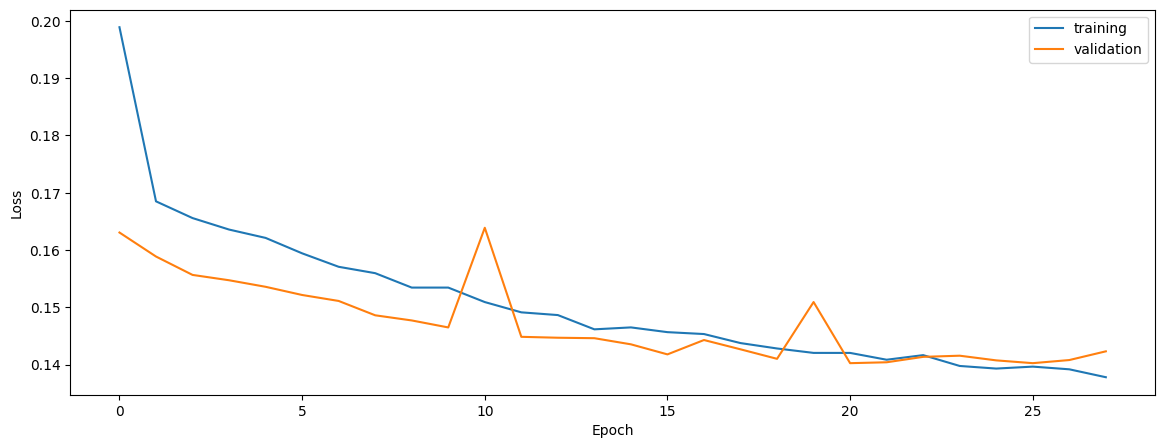

In [12]:
history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [13]:
props2 = props
model2 = model

In [14]:
import numpy as np

def getTrue(threshold):
    props=props1.copy()
    props['threshold'] = threshold
    props['radiomics'] = []
    props['radiomics_vox'] = [{'im':'t1','fe':['k5_b25']}]
    props['balance_data'] = False
    props['include_warp'] = True
    gen = DataGenerator(**props)
    return gen

def getPred(threshold, cla, reg):
    reg = reg[:,0]
    pred = cla.copy()
    pred[:,-1] = np.where(reg < threshold, 1, 0)
    for i in range(cla.shape[-1]-1):
        pred[:,i] = np.where(reg < threshold, 0, pred[:,i])
    return pred

In [15]:
from util import getAccuarcy, predictInBatches

props1['balance_data'] = False
props2['balance_data'] = False
gen1 = DataGenerator(**props1)
gen2 = DataGenerator(**props2)
train1, val1, test1 = gen1.getData()
train2, val2, test2 = gen2.getData()

train_cla = predictInBatches(model1,train1[0],architecture['batch_size'])
val_cla = predictInBatches(model1,val1[0],architecture['batch_size'])
test_cla = predictInBatches(model1,test1[0],architecture['batch_size'])
train_reg = predictInBatches(model2,train2[0],architecture['batch_size'])
val_reg = predictInBatches(model2,val2[0],architecture['batch_size'])
test_reg = predictInBatches(model2,test2[0],architecture['batch_size'])

threshold = props['threshold']

gen = getTrue(threshold)
train_true, val_true, test_true = gen.getData()
train_pred = getPred(threshold, train_cla, train_reg)
val_pred = getPred(threshold, val_cla, val_reg)
test_pred = getPred(threshold, test_cla, test_reg)

print('native')
print(getAccuarcy(train_true[1],train_pred))
print(getAccuarcy(val_true[1],val_pred))
print(getAccuarcy(test_true[1],test_pred))

native
0.676871244961594
0.6706244621342513
0.6193665197853497


In [16]:
print('normalized')
print(getAccuarcy(train_true[1][train_true[2]],train_pred[train_true[2]]))
print(getAccuarcy(val_true[1][val_true[2]],val_pred[val_true[2]]))
print(getAccuarcy(test_true[1][test_true[2]],test_pred[test_true[2]]))

normalized
0.6715847135732926
0.6640994608867862
0.6193860147811256


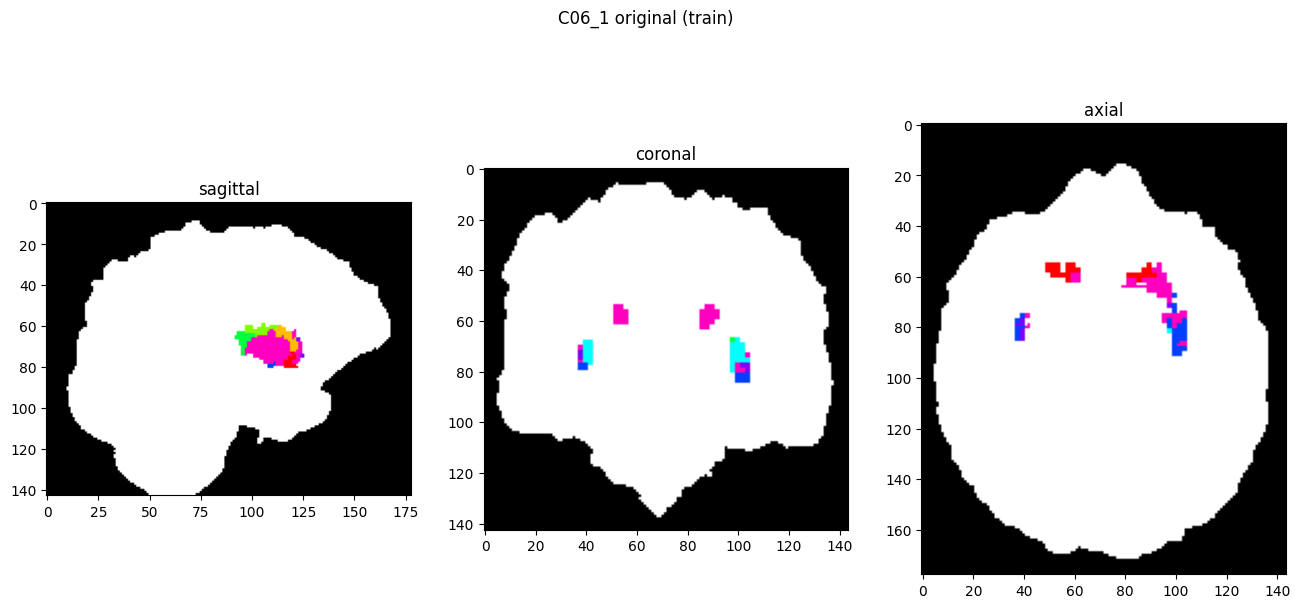

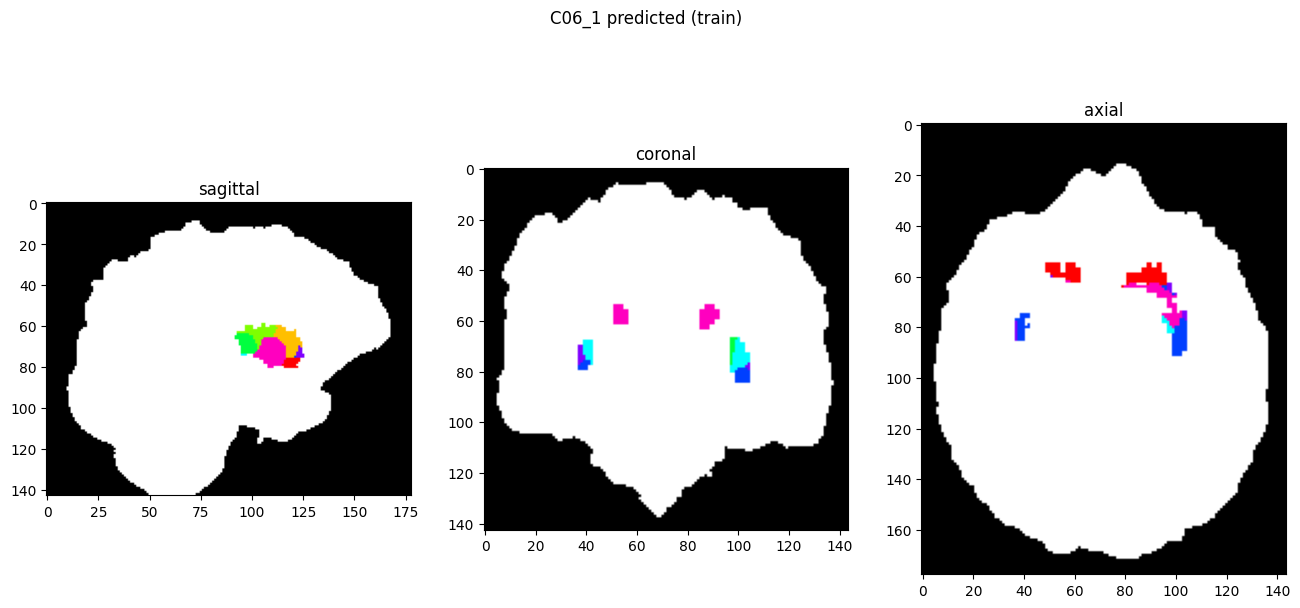

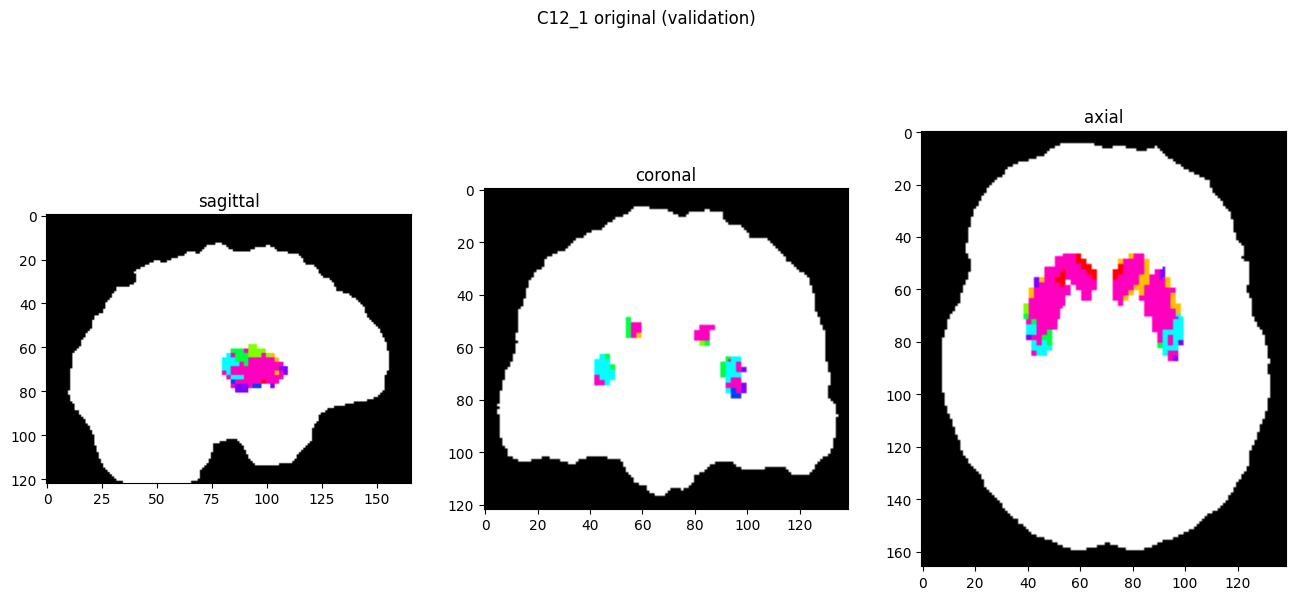

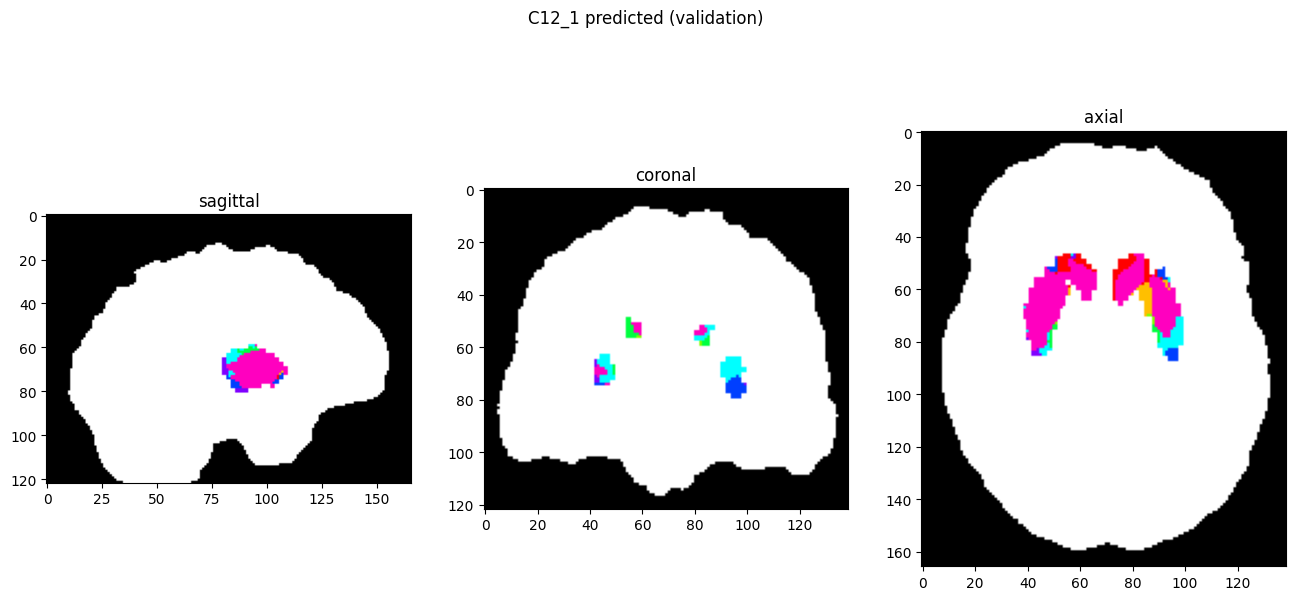

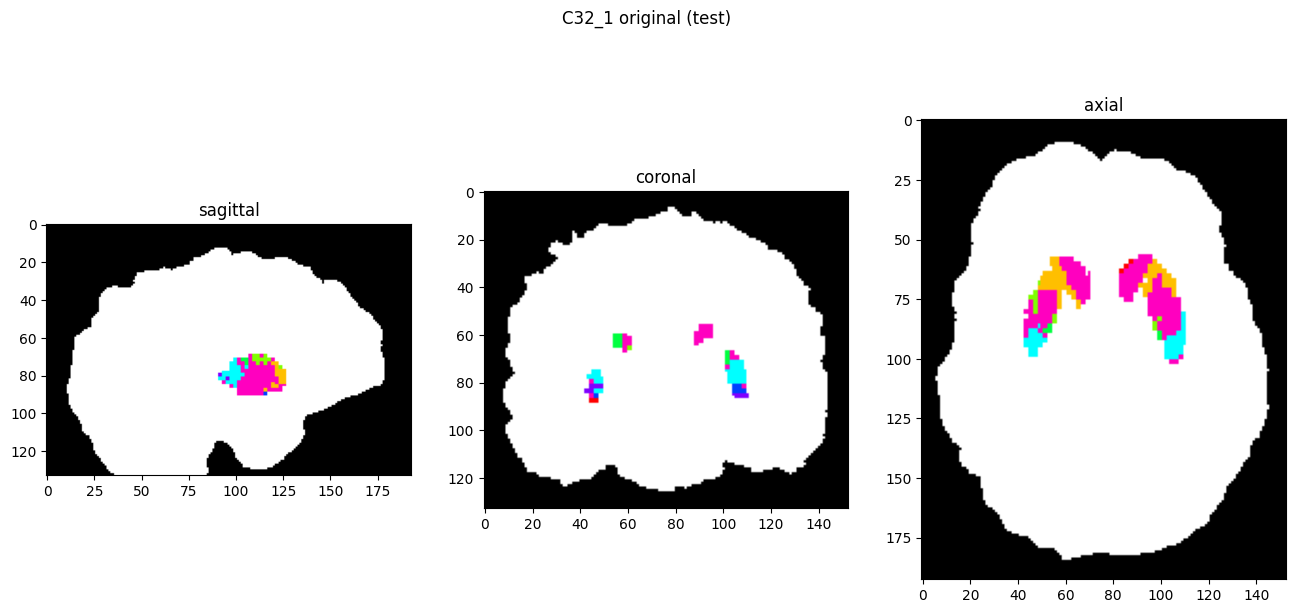

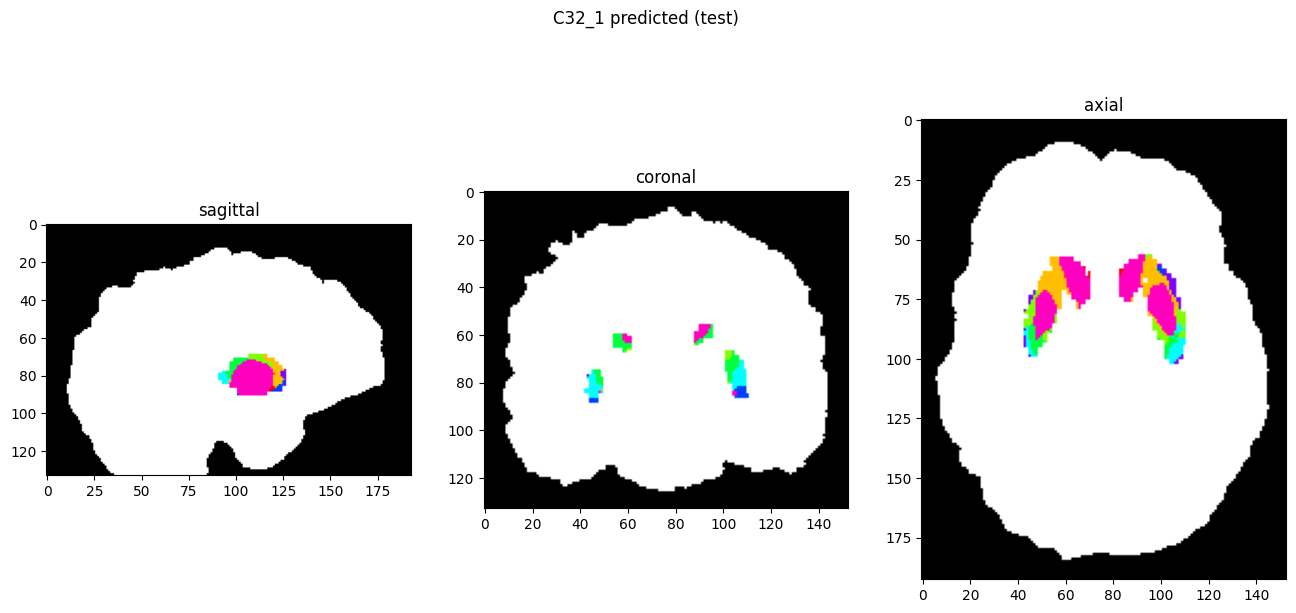

In [17]:
def customPredict(mode):
    idx = {'train':0,'validation':1,'test':2}[mode]
    dat_cla = gen1.getReconstructor(gen1.names[idx][0])
    dat_reg = gen2.getReconstructor(gen2.names[idx][0])
    pred_cla = predictInBatches(model1,dat_cla[0],architecture['batch_size'])
    pred_reg = predictInBatches(model2,dat_reg[0],architecture['batch_size'])
    return getPred(threshold, pred_cla, pred_reg)

showResults(model, gen, threshold=0, predict=customPredict)